<a href="https://colab.research.google.com/github/Ramprashanth17/info6105-Data-Science/blob/main/Interpretability_Assignment3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Interpreting the Models

1. Fitting a Linear Model and Interpreting the regression Co-efficients

In [ ]:
# Importing the required libraries

import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder, FunctionTransformer, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression


from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE


from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)

In [ ]:
pip install category-encoders


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 3.1 MB/s eta 0:00:00


In [ ]:
import category_encoders as ce

In [ ]:
# storing the data to a dataframe for analysis
from google.colab import drive
drive.mount('/content/gdrive')
obesity = pd.read_csv('/content/gdrive/MyDrive/EDA-Assignment_1/ObesityDataSet_raw_and_data_sinthetic.csv')
obesity

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Gender        Age    Height      Weight family_history_with_overweight  \
0     Female  21.000000  1.620000   64.000000                            yes   
1     Female  21.000000  1.520000   56.000000                            yes   
2       Male  23.000000  1.800000   77.000000                            yes   
3       Male  27.000000  1.800000   87.000000                             no   
4       Male  22.000000  1.780000   89.800000                             no   
...      ...        ...       ...         ...                            ...   
2106  Female  20.976842  1.710730  131.408528                            yes   
2107  Female  21.982942  1.748584  133.742943                            yes   
2108  Female  22.524036  1.752206  133.689352                            yes   
2109  Female  24.361936  1.739450  133.346641                            yes   
2110  Female  23.664709  1.738836  133.472641                            yes   

     FAVC  FCVC  NCP       CAEC SMOKE      CH2O  SCC       FAF       TUE  \
0      no   2.0  3.0  Sometimes    no  2.000000   no  0.000000  1.000000   
1      no   3.0  3.0  Sometimes   yes  3.000000  yes  3.000000  0.000000   
2      no   2.0  3.0  Sometimes    no  2.000000   no  2.000000  1.000000   
3      no   3.0  3.0  Sometimes    no  2.000000   no  2.000000  0.000000   
4      no   2.0  1.0  Sometimes    no  2.000000   no  0.000000  0.000000   
...   ...   ...  ...        ...   ...       ...  ...       ...       ...   
2106  yes   3.0  3.0  Sometimes    no  1.728139   no  1.676269  0.906247   
2107  yes   3.0  3.0  Sometimes    no  2.005130   no  1.341390  0.599270   
2108  yes   3.0  3.0  Sometimes    no  2.054193   no  1.414209  0.646288   
2109  yes   3.0  3.0  Sometimes    no  2.852339   no  1.139107  0.586035   
2110  yes   3.0  3.0  Sometimes    no  2.863513   no  1.026452  0.714137   

            CALC                 MTRANS           NObeyesdad  
0             no  Public_Transportation        Normal_Weight  
1      Sometimes  Public_Transportation        Normal_Weight  
2     Frequently  Public_Transportation        Normal_Weight  
3     Frequently                Walking   Overweight_Level_I  
4      Sometimes  Public_Transportation  Overweight_Level_II  
...          ...                    ...                  ...  
2106   Sometimes  Public_Transportation     Obesity_Type_III  
2107   Sometimes  Public_Transportation     Obesity_Type_III  
2108   Sometimes  Public_Transportation     Obesity_Type_III  
2109   Sometimes  Public_Transportation     Obesity_Type_III  
2110   Sometimes  Public_Transportation     Obesity_Type_III  

[2111 rows x 17 columns]

# Data Cleaning


In [ ]:
# Checking for NaN (missing) values
missing_values = obesity.isnull().sum()

# Checking for duplicated rows
duplicates = obesity.duplicated().sum()

print(f"checking missing value\n{missing_values}")
print(f"duplicated values\n{duplicates}")

checking missing value
Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
NObeyesdad                        0
dtype: int64
duplicated values
24


In [ ]:
# Removing duplicated rows from the dataset
obesity = obesity.drop_duplicates()
#check if ther is any remining duplicated values
obesity.duplicated().sum()

0

# Encoding Categorical Columns

Since, we've many categorical columns it's wise to turn them into numerical columns by encoding them.

In [ ]:
columns = obesity.columns
categorical_columns = [c for c in columns if obesity[c].dtypes == 'object']
categorical_columns

['Gender',
 'family_history_with_overweight',
 'FAVC',
 'CAEC',
 'SMOKE',
 'SCC',
 'CALC',
 'MTRANS',
 'NObeyesdad']

In [ ]:
for i in categorical_columns:
    print(f"{i} : {obesity[i].unique()}")

Gender : ['Female' 'Male']
family_history_with_overweight : ['yes' 'no']
FAVC : ['no' 'yes']
CAEC : ['Sometimes' 'Frequently' 'Always' 'no']
SMOKE : ['no' 'yes']
SCC : ['no' 'yes']
CALC : ['no' 'Sometimes' 'Frequently' 'Always']
MTRANS : ['Public_Transportation' 'Walking' 'Automobile' 'Motorbike' 'Bike']
NObeyesdad : ['Normal_Weight' 'Overweight_Level_I' 'Overweight_Level_II'
 'Obesity_Type_I' 'Insufficient_Weight' 'Obesity_Type_II'
 'Obesity_Type_III']


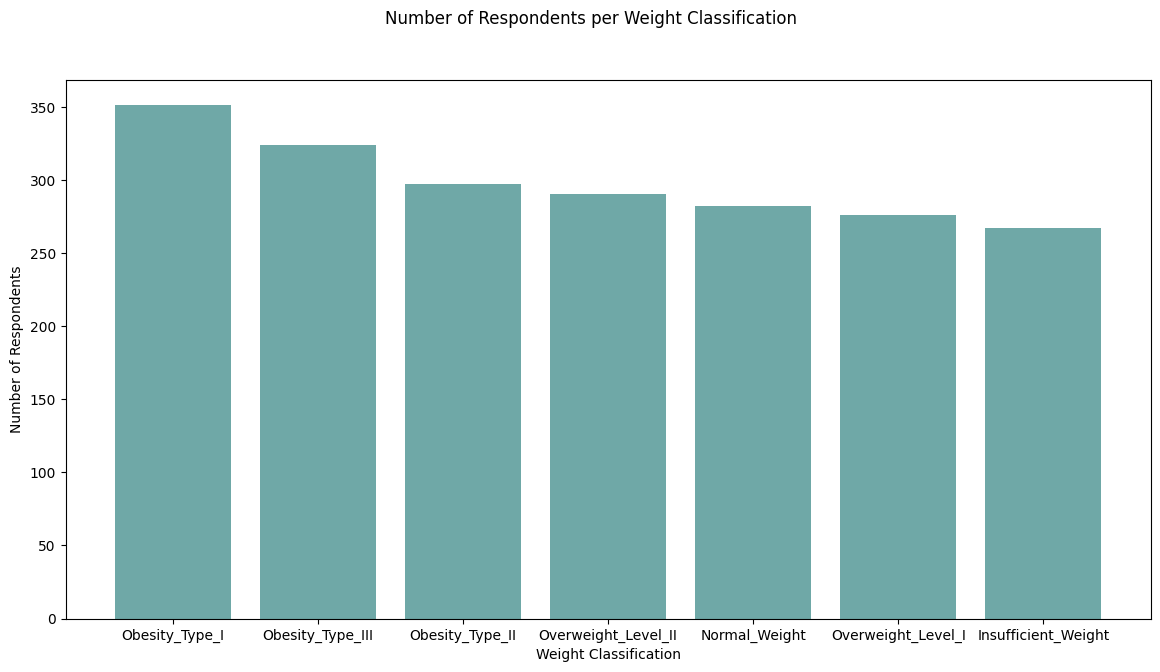

In [ ]:
fig = plt.figure(figsize = (14, 7))
fig.suptitle("Number of Respondents per Weight Classification")

#Count the number of datapoints attributed with each weight category
counts = obesity["NObeyesdad"].value_counts()
plt.bar(counts.index, counts.values, color="#6fa8a7")
plt.xlabel("Weight Classification")
plt.ylabel("Number of Respondents")
plt.show()





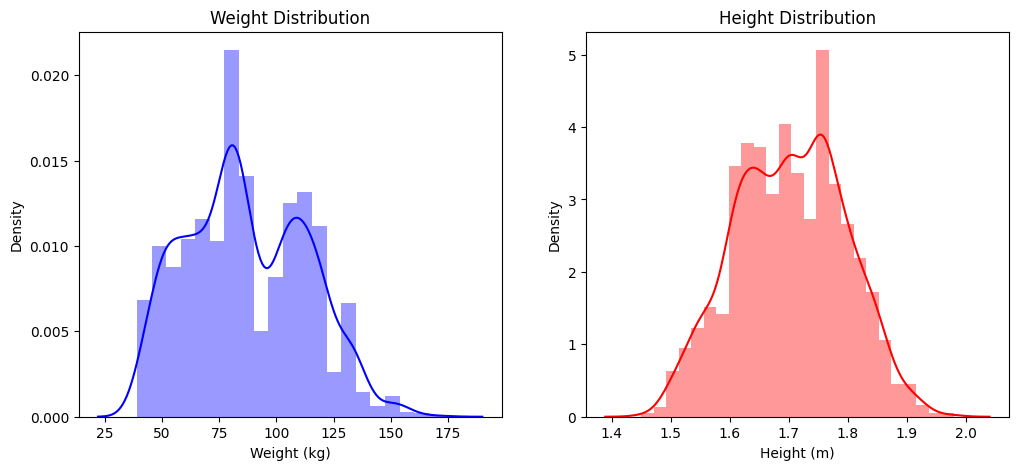

In [ ]:
import seaborn as sns
plt.figure(figsize=(12,5))

#Weight distributon suplot
plt.subplot(1, 2, 1)
sns.distplot(obesity["Weight"], color="b").set_title('Weight Distribution')
plt.xlabel("Weight (kg)")

#Height distribution subplot
plt.subplot(1, 2, 2)
sns.distplot(obesity["Height"], color="r").set_title('Height Distribution')
plt.xlabel("Height (m)")

plt.show()

<Axes: >

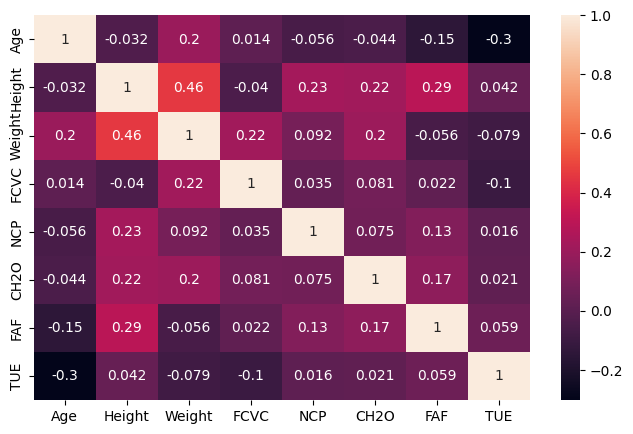

In [ ]:
# Finding the features by heatmap
plt.figure(figsize=(8,5))
sns.heatmap(obesity.corr(), annot = True)

Thus, from the heatmap, we can figure out that "height" and "weight" are two of the most important predictor variables, followed by "FAF", "FCVC" these columns have positive relations whereas TUE etc have negative corelations.

In [ ]:
# Splitting the data into X and y to fit a linear model
X = obesity.iloc[:,:-1]
y = obesity.iloc[:, -1]
y = pd.DataFrame(y, columns=['NObeyesdad'])

In [ ]:
labels = ['Normal_Weight', 'Overweight_Level_I', 'Overweight_Level_II', 'Obesity_Type_I', 'Insufficient_Weight', 'Obesity_Type_II', 'Obesity_Type_III']

# Create a dictionary to map labels to numbers starting from 1
label_to_number = {label: i + 1 for i, label in enumerate(labels)}

# Map the condition labels to numeric values
y['NObeyesdad'] = y['NObeyesdad'].map(label_to_number)
y.head()

NObeyesdad
0           1
1           1
2           1
3           2
4           3

Gender, FAVC, SMOKE, SCC , family_history_with_overweight (Binary Categories):
These features have only two categories and are best represented by a binary format.

CALC, MTRANS (Multi-Category Nominal):
These features are nominal with no inherent order. One-hot encoding creates new columns indicating the presence of each possible value.

CAEC (Ordinal Category):
If 'CAEC' has an inherent order (e.g., never, sometimes, frequently, always), ordinal encoding can be used, where each category is assigned an integer based on the order.

In [ ]:
# Custom function for binary encoding
def binary_encode(obesity, columns):
    obesity = obesity.copy() #ensure that the function is safe and does not modify the DataFrame passed to it unexpectedly.
    label_encoder = LabelEncoder()
    for col in columns:
        obesity[col] = label_encoder.fit_transform(obesity[col])
    return obesity

# Columns for binary encoding, one-hot encoding, and category encoding
binary_columns = ['Gender', 'FAVC', 'SMOKE', 'SCC', 'family_history_with_overweight']
onehot_encoded_columns = ['CALC', 'MTRANS']
category_encoded_columns = ['CAEC']

# Creating a pipeline for binary encoding
binary_pipeline = Pipeline(steps=[
    ('binary_encode', FunctionTransformer(binary_encode, kw_args={'columns': binary_columns}))
])

# Creating a pipeline for category encoding
category_pipeline = Pipeline(steps=[
    ('category_encode', ce.OrdinalEncoder(cols=category_encoded_columns))
])

# Creating the ColumnTransformer
categorical_transformer = ColumnTransformer(
    transformers=[
        ('binary', binary_pipeline, binary_columns),
        ('onehot', OneHotEncoder(), onehot_encoded_columns),
        ('category', category_pipeline, category_encoded_columns)
    ],
    remainder='passthrough'  # leave the rest of the columns unchanged
)

# Applying the ColumnTransformer to the DataFrame
X_categorical_transformed = categorical_transformer.fit_transform(X)

# Getting new column names
binary_encoded_names = binary_columns  # Binary encoded columns names remain the same
onehot_encoded_names = categorical_transformer.named_transformers_['onehot'].get_feature_names_out(onehot_encoded_columns)
category_encoded_names = categorical_transformer.named_transformers_['category'].get_feature_names_out(category_encoded_columns)

new_columns = binary_encoded_names + list(onehot_encoded_names) + list(category_encoded_names)
new_columns += [col for col in X.columns if col not in binary_columns + onehot_encoded_columns + category_encoded_columns]

# Creating the new DataFrame with the new column names
obesity_encoded_obesity = pd.DataFrame(X_categorical_transformed, columns=new_columns)

obesity_encoded_obesity.head()

Gender  FAVC  SMOKE  SCC  family_history_with_overweight  CALC_Always  \
0     0.0   0.0    0.0  0.0                             1.0          0.0   
1     0.0   0.0    1.0  1.0                             1.0          0.0   
2     1.0   0.0    0.0  0.0                             1.0          0.0   
3     1.0   0.0    0.0  0.0                             0.0          0.0   
4     1.0   0.0    0.0  0.0                             0.0          0.0   

   CALC_Frequently  CALC_Sometimes  CALC_no  MTRANS_Automobile  MTRANS_Bike  \
0              0.0             0.0      1.0                0.0          0.0   
1              0.0             1.0      0.0                0.0          0.0   
2              1.0             0.0      0.0                0.0          0.0   
3              1.0             0.0      0.0                0.0          0.0   
4              0.0             1.0      0.0                0.0          0.0   

   MTRANS_Motorbike  MTRANS_Public_Transportation  MTRANS_Walking  CAEC   Age  \
0               0.0                           1.0             0.0   1.0  21.0   
1               0.0                           1.0             0.0   1.0  21.0   
2               0.0                           1.0             0.0   1.0  23.0   
3               0.0                           0.0             1.0   1.0  27.0   
4               0.0                           1.0             0.0   1.0  22.0   

   Height  Weight  FCVC  NCP  CH2O  FAF  TUE  
0    1.62    64.0   2.0  3.0   2.0  0.0  1.0  
1    1.52    56.0   3.0  3.0   3.0  3.0  0.0  
2    1.80    77.0   2.0  3.0   2.0  2.0  1.0  
3    1.80    87.0   3.0  3.0   2.0  2.0  0.0  
4    1.78    89.8   2.0  1.0   2.0  0.0  0.0

In [ ]:
obesity_encoded_obesity.describe()

Gender         FAVC        SMOKE          SCC  \
count  2087.000000  2087.000000  2087.000000  2087.000000   
mean      0.504073     0.883565     0.021083     0.045999   
std       0.500103     0.320823     0.143695     0.209533   
min       0.000000     0.000000     0.000000     0.000000   
25%       0.000000     1.000000     0.000000     0.000000   
50%       1.000000     1.000000     0.000000     0.000000   
75%       1.000000     1.000000     0.000000     0.000000   
max       1.000000     1.000000     1.000000     1.000000   

       family_history_with_overweight  CALC_Always  CALC_Frequently  \
count                     2087.000000  2087.000000      2087.000000   
mean                         0.825108     0.000479         0.033541   
std                          0.379966     0.021890         0.180088   
min                          0.000000     0.000000         0.000000   
25%                          1.000000     0.000000         0.000000   
50%                          1.000000     0.000000         0.000000   
75%                          1.000000     0.000000         0.000000   
max                          1.000000     1.000000         1.000000   

       CALC_Sometimes      CALC_no  MTRANS_Automobile  MTRANS_Bike  \
count     2087.000000  2087.000000        2087.000000  2087.000000   
mean         0.661236     0.304744           0.218495     0.003354   
std          0.473403     0.460409           0.413324     0.057831   
min          0.000000     0.000000           0.000000     0.000000   
25%          0.000000     0.000000           0.000000     0.000000   
50%          1.000000     0.000000           0.000000     0.000000   
75%          1.000000     1.000000           0.000000     0.000000   
max          1.000000     1.000000           1.000000     1.000000   

       MTRANS_Motorbike  MTRANS_Public_Transportation  MTRANS_Walking  \
count       2087.000000                   2087.000000     2087.000000   
mean           0.005271                      0.746526        0.026354   
std            0.072426                      0.435104        0.160223   
min            0.000000                      0.000000        0.000000   
25%            0.000000                      0.000000        0.000000   
50%            0.000000                      1.000000        0.000000   
75%            0.000000                      1.000000        0.000000   
max            1.000000                      1.000000        1.000000   

              CAEC          Age       Height       Weight         FCVC  \
count  2087.000000  2087.000000  2087.000000  2087.000000  2087.000000   
mean      1.217058    24.353090     1.702674    86.858730     2.421466   
std       0.572070     6.368801     0.093186    26.190847     0.534737   
min       1.000000    14.000000     1.450000    39.000000     1.000000   
25%       1.000000    19.915937     1.630178    66.000000     2.000000   
50%       1.000000    22.847618     1.701584    83.101100     2.396265   
75%       1.000000    26.000000     1.769491   108.015907     3.000000   
max       4.000000    61.000000     1.980000   173.000000     3.000000   

               NCP         CH2O          FAF          TUE  
count  2087.000000  2087.000000  2087.000000  2087.000000  
mean      2.701179     2.004749     1.012812     0.663035  
std       0.764614     0.608284     0.853475     0.608153  
min       1.000000     1.000000     0.000000     0.000000  
25%       2.697467     1.590922     0.124505     0.000000  
50%       3.000000     2.000000     1.000000     0.630866  
75%       3.000000     2.466193     1.678102     1.000000  
max       4.000000     3.000000     3.000000     2.000000

In [ ]:
print(len(obesity_encoded_obesity), len(y))

2087 2087


In [ ]:
#Performing a Train-Test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(obesity_encoded_obesity, y, test_size=0.25, random_state=42)

# Evaluating the linear model

Since linear regression is out of question as there are multiple independent values and only one dependent values. We'll be going through with logistic regression.

In [ ]:
lr = LogisticRegression(max_iter=1000)

**Fitting the model**



In [ ]:
lr.fit(X_train,y_train)

LogisticRegression(max_iter=1000)

**Model accuracy**
A model's accuracy is the proportion of classes that the model correctly predicts. is Compute and print the accuracy of lr by using the .score() method.

In [ ]:
print(lr.score(X_train,y_train))

0.8306709265175719


# Sequential Forward Selection

It's time to select the features

In [ ]:
sfs = SFS(lr,
         k_features=10,
         forward = True,
         floating=False,
         cv=0,
         scoring='accuracy')

In [ ]:
sfs.fit(X_train,y_train)

SequentialFeatureSelector(cv=0, estimator=LogisticRegression(max_iter=1000),
                          k_features=(10, 10), scoring='accuracy')

In [ ]:
print(sfs.subsets_[10])

{'feature_idx': (0, 1, 5, 6, 8, 9, 11, 15, 16, 17), 'cv_scores': array([0.83450479]), 'avg_score': 0.8345047923322684, 'feature_names': ('Gender', 'FAVC', 'CALC_Always', 'CALC_Frequently', 'CALC_no', 'MTRANS_Automobile', 'MTRANS_Motorbike', 'Age', 'Height', 'Weight')}


In [ ]:
# Print the chosen feature names
print(print(sfs.subsets_[10]['feature_names']))
# Print the accuracy of the model after sequential forward selection
print(sfs.subsets_[10]['avg_score'])

('Gender', 'FAVC', 'CALC_Always', 'CALC_Frequently', 'CALC_no', 'MTRANS_Automobile', 'MTRANS_Motorbike', 'Age', 'Height', 'Weight')
None
0.8345047923322684


<Figure size 2000x3000 with 0 Axes>

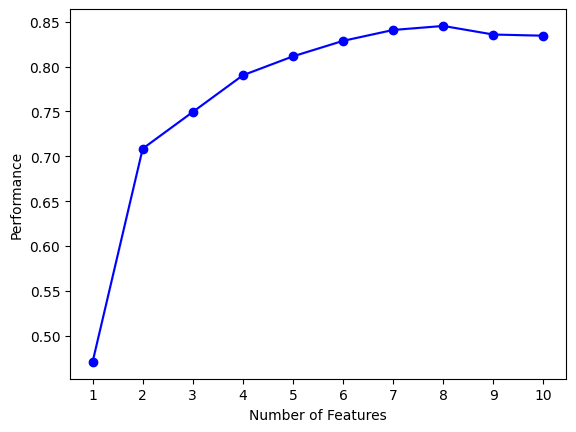

In [ ]:
%matplotlib inline

plt.figure(figsize=(20, 30))  # Define the figure size before plotting
plot_sfs(sfs.get_metric_dict())  # Your plotting function should come after setting the figure size
plt.show()

# Grid Search


In [ ]:
from sklearn.model_selection import GridSearchCV, cross_val_score

# Define the parameter grid for Grid Search
param_grid = {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2'], 'max_iter': [100, 200, 500, 1000]}

In [ ]:
# Perform Grid Search with cross-validation
grid_search = GridSearchCV(estimator=lr, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000),
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'max_iter': [100, 200, 500, 1000],
                         'penalty': ['l1', 'l2']},
             scoring='accuracy')

In [ ]:
# Best parameters
best_params = grid_search.best_params_

# Initialize the logistic regression model with the best parameters
best_lr = LogisticRegression(**best_params)

# Cross-validation scores
cross_val_scores = cross_val_score(best_lr, X_train, y_train, cv=5, scoring='accuracy')

# Print the best parameters and cross-validation scores
print("Best Parameters:", best_params)
print("Cross-Validation Accuracy Scores:", cross_val_scores)

Best Parameters: {'C': 100, 'max_iter': 1000, 'penalty': 'l2'}
Cross-Validation Accuracy Scores: [0.85303514 0.85942492 0.84345048 0.86900958 0.86900958]


In [ ]:
# Calculate mean and standard deviation of cross-validation scores
mean_cv_score = cross_val_scores.mean()
std_cv_score = cross_val_scores.std()

# Print mean and standard deviation
print(f"Mean Cross-Validation Accuracy: {mean_cv_score}")
print(f"Standard Deviation of Cross-Validation Accuracy: {std_cv_score}")

# Retrain the model on the entire dataset
best_lr.fit(obesity_encoded_obesity, y)

# If you have a separate test set, evaluate the model on it
# test_accuracy = best_lr.score(X_test, y_test) # Uncomment if you have a test set

# Final model evaluation
final_accuracy = best_lr.score(X_test, y_test)

# Print the final model accuracy
print(f"Final Model Accuracy on Training Data: {final_accuracy}")

Mean Cross-Validation Accuracy: 0.8587859424920128
Standard Deviation of Cross-Validation Accuracy: 0.009774478300816836
Final Model Accuracy on Training Data: 0.8620689655172413


In [ ]:
best_lr

LogisticRegression(C=100, max_iter=1000)

# Using SHAP analysis on Linear Model


In [ ]:
pip install shap

  0%|          | 0/522 [00:00<?, ?it/s]

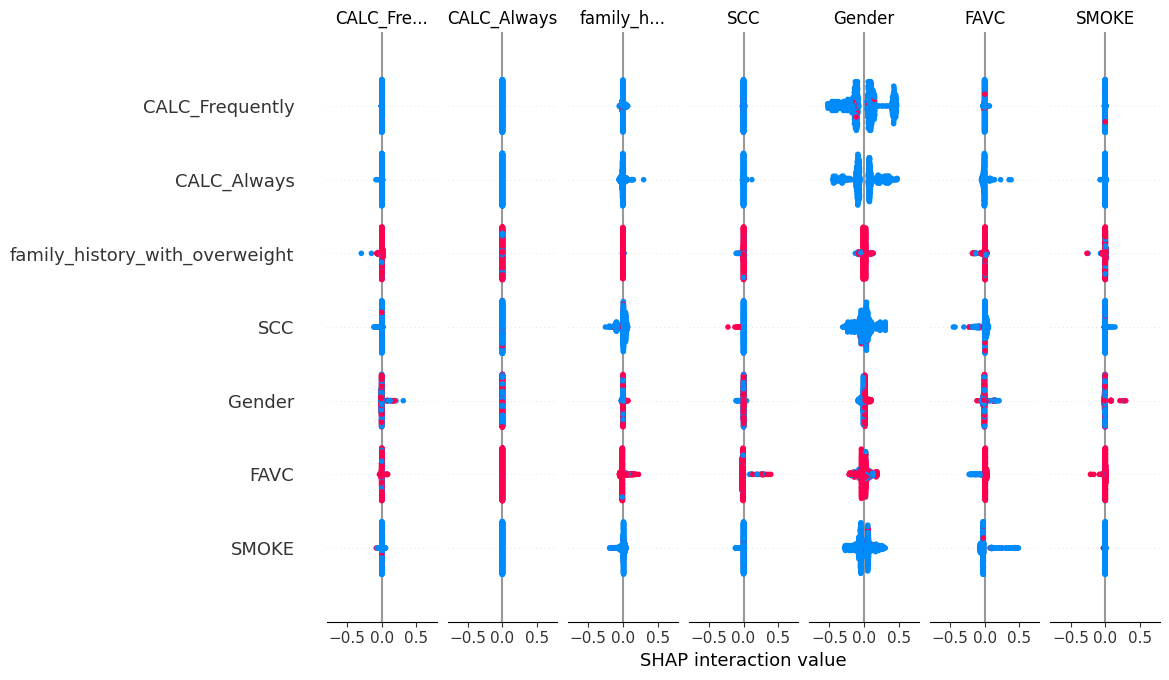

In [ ]:
import shap
from sklearn.linear_model import LogisticRegression

# Train the logistic regression model
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

# Create the SHAP explainer using the test data
lr_explainer = shap.KernelExplainer(lr.predict_proba, X_test)

# Calculate SHAP values on the test data
shap_values = lr_explainer.shap_values(X_test)

# Generate SHAP summary plot for feature importance insights
shap.summary_plot(shap_values, X_test)  # Visualize feature importance





# Interpreting the SHAP values for Linear Model

Important Features:

Age: The age feature seems to have the strongest positive impact on the model's predictions. This suggests that as the value of age increases, the model is more likely to predict a positive outcome (potentially indicating obesity).
Gender: Gender also appears to be an influential feature. The impact seems to vary depending on the specific gender value (possibly male or female). A positive SHAP value for a particular gender indicates it leans towards a positive prediction (obesity), while a negative value leans towards a negative prediction (not obese).
TUE: The TUE feature has a noticeable impact, with both positive and negative values. This suggests TUE interacts with other features in the model's decision-making process. A positive SHAP value for a particular TUE value indicates it contributes to a positive prediction, and vice versa.
Other Features:

The remaining features (FCVC, NCP, CH2O, FAF) appear to have less prominent but potentially still influential effects on the model's predictions. Their impact seems to vary depending on the specific feature value and how they interact with other features.

# Fitting Tree based model and interpreting the nodes


In [ ]:
# Importing the required libraries again!

%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import make_scorer, f1_score, accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score




In [ ]:
pip install scikit-plot

In [ ]:
# storing the data to a dataframe for analysis
from google.colab import drive
drive.mount('/content/gdrive')
obesity_data = pd.read_csv('/content/gdrive/MyDrive/EDA-Assignment_1/ObesityDataSet_raw_and_data_sinthetic.csv')
obesity_data

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Gender        Age    Height      Weight family_history_with_overweight  \
0     Female  21.000000  1.620000   64.000000                            yes   
1     Female  21.000000  1.520000   56.000000                            yes   
2       Male  23.000000  1.800000   77.000000                            yes   
3       Male  27.000000  1.800000   87.000000                             no   
4       Male  22.000000  1.780000   89.800000                             no   
...      ...        ...       ...         ...                            ...   
2106  Female  20.976842  1.710730  131.408528                            yes   
2107  Female  21.982942  1.748584  133.742943                            yes   
2108  Female  22.524036  1.752206  133.689352                            yes   
2109  Female  24.361936  1.739450  133.346641                            yes   
2110  Female  23.664709  1.738836  133.472641                            yes   

     FAVC  FCVC  NCP       CAEC SMOKE      CH2O  SCC       FAF       TUE  \
0      no   2.0  3.0  Sometimes    no  2.000000   no  0.000000  1.000000   
1      no   3.0  3.0  Sometimes   yes  3.000000  yes  3.000000  0.000000   
2      no   2.0  3.0  Sometimes    no  2.000000   no  2.000000  1.000000   
3      no   3.0  3.0  Sometimes    no  2.000000   no  2.000000  0.000000   
4      no   2.0  1.0  Sometimes    no  2.000000   no  0.000000  0.000000   
...   ...   ...  ...        ...   ...       ...  ...       ...       ...   
2106  yes   3.0  3.0  Sometimes    no  1.728139   no  1.676269  0.906247   
2107  yes   3.0  3.0  Sometimes    no  2.005130   no  1.341390  0.599270   
2108  yes   3.0  3.0  Sometimes    no  2.054193   no  1.414209  0.646288   
2109  yes   3.0  3.0  Sometimes    no  2.852339   no  1.139107  0.586035   
2110  yes   3.0  3.0  Sometimes    no  2.863513   no  1.026452  0.714137   

            CALC                 MTRANS           NObeyesdad  
0             no  Public_Transportation        Normal_Weight  
1      Sometimes  Public_Transportation        Normal_Weight  
2     Frequently  Public_Transportation        Normal_Weight  
3     Frequently                Walking   Overweight_Level_I  
4      Sometimes  Public_Transportation  Overweight_Level_II  
...          ...                    ...                  ...  
2106   Sometimes  Public_Transportation     Obesity_Type_III  
2107   Sometimes  Public_Transportation     Obesity_Type_III  
2108   Sometimes  Public_Transportation     Obesity_Type_III  
2109   Sometimes  Public_Transportation     Obesity_Type_III  
2110   Sometimes  Public_Transportation     Obesity_Type_III  

[2111 rows x 17 columns]

In [ ]:
obesity_data.head()

Gender   Age  Height  Weight family_history_with_overweight FAVC  FCVC  \
0  Female  21.0    1.62    64.0                            yes   no   2.0   
1  Female  21.0    1.52    56.0                            yes   no   3.0   
2    Male  23.0    1.80    77.0                            yes   no   2.0   
3    Male  27.0    1.80    87.0                             no   no   3.0   
4    Male  22.0    1.78    89.8                             no   no   2.0   

   NCP       CAEC SMOKE  CH2O  SCC  FAF  TUE        CALC  \
0  3.0  Sometimes    no   2.0   no  0.0  1.0          no   
1  3.0  Sometimes   yes   3.0  yes  3.0  0.0   Sometimes   
2  3.0  Sometimes    no   2.0   no  2.0  1.0  Frequently   
3  3.0  Sometimes    no   2.0   no  2.0  0.0  Frequently   
4  1.0  Sometimes    no   2.0   no  0.0  0.0   Sometimes   

                  MTRANS           NObeyesdad  
0  Public_Transportation        Normal_Weight  
1  Public_Transportation        Normal_Weight  
2  Public_Transportation        Normal_Weight  
3                Walking   Overweight_Level_I  
4  Public_Transportation  Overweight_Level_II

In [ ]:
obesity_data.shape

(2111, 17)

# EDA for tree model


In [ ]:
obesity_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          2111 non-null   object 
 1   Age                             2111 non-null   float64
 2   Height                          2111 non-null   float64
 3   Weight                          2111 non-null   float64
 4   family_history_with_overweight  2111 non-null   object 
 5   FAVC                            2111 non-null   object 
 6   FCVC                            2111 non-null   float64
 7   NCP                             2111 non-null   float64
 8   CAEC                            2111 non-null   object 
 9   SMOKE                           2111 non-null   object 
 10  CH2O                            2111 non-null   float64
 11  SCC                             2111 non-null   object 
 12  FAF                             21

In [ ]:
def count_values(dataset, cat_variable, order = None):
    """
    Function: Counts values in each category and displays them on a plot.

    Parameters: Dataset, category feature, and order of appearance (order is optional).
    """
    ax = sns.countplot(x = cat_variable, data = dataset, palette = "Blues_r", order = order)
    for p in ax.patches:
        ax.annotate(f"\n{p.get_height()}", (p.get_x()+0.2, p.get_height()),
                    ha = "center", va = "top", color = "white", size = 10)

    plt.title(f"Number of items in each {cat_variable} category")
    plt.show()

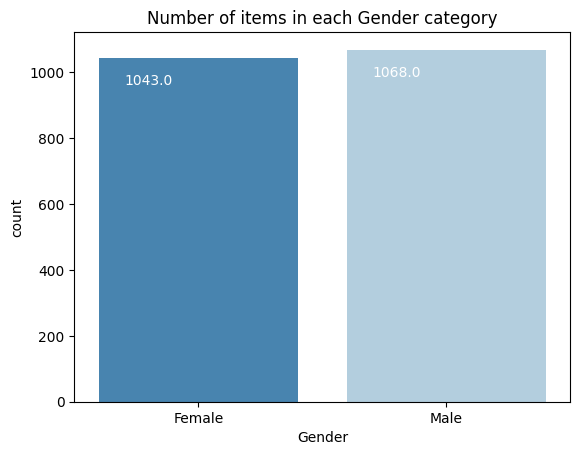

In [ ]:
count_values(obesity_data, "Gender")

In [ ]:
def plot_distribution(dataset, feature):
    """
    Function: Computes and displays distribution of features with continuous values; plots their mean and median.

    Parameters: Dataset and feature with continuous values.
    """
    plt.hist(dataset[feature], bins = "fd")

    plt.axvline(dataset[feature].mean(), color = "red", label = "mean")
    plt.axvline(dataset[feature].median(), color = "orange", label = "median")

    plt.xlabel(f"{feature}")
    plt.ylabel("Count")
    plt.legend()
    plt.title(f"Distribution of values in {feature}")
    plt.show()

In [ ]:
obesity_data["Age"].describe()

count    2111.000000
mean       24.312600
std         6.345968
min        14.000000
25%        19.947192
50%        22.777890
75%        26.000000
max        61.000000
Name: Age, dtype: float64

In [ ]:
obesity_data["Age"].median()

22.77789

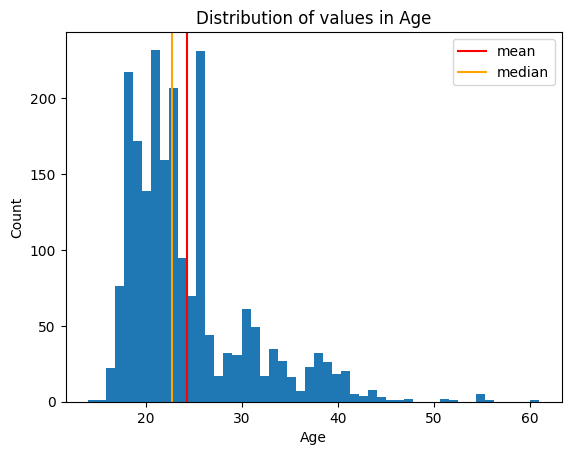

In [ ]:
plot_distribution(obesity_data, "Age")

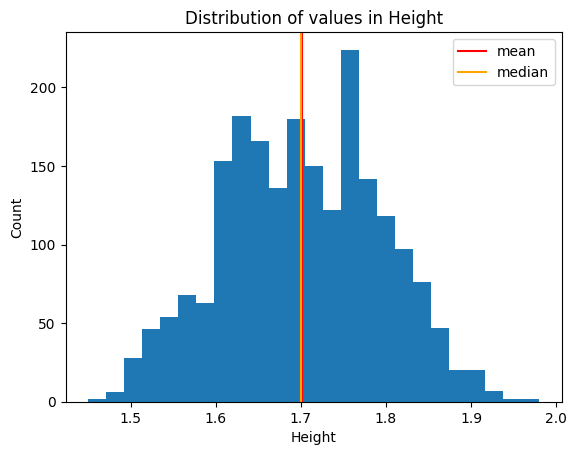

In [ ]:
plot_distribution(obesity_data, "Height")

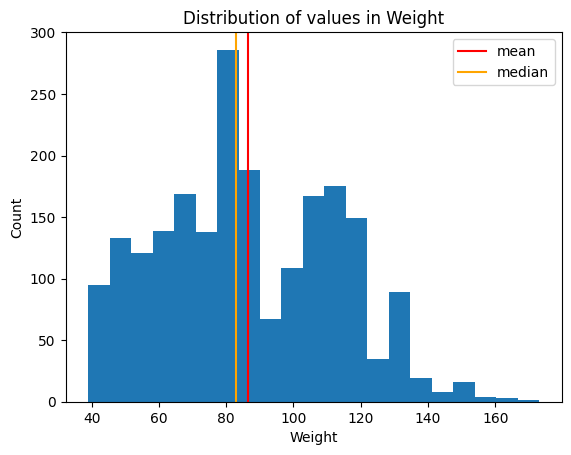

In [ ]:
plot_distribution(obesity_data, "Weight")

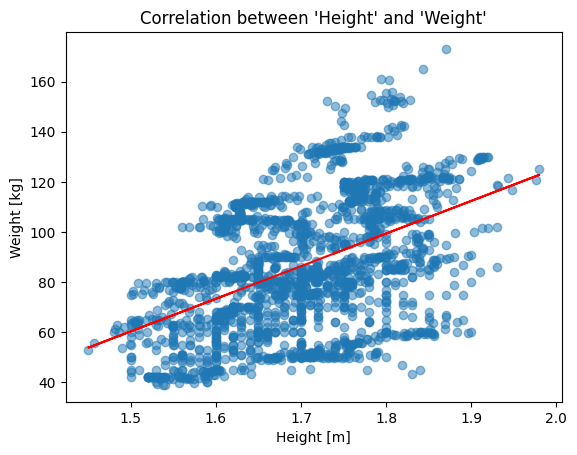

In [ ]:
plt.scatter(obesity_data["Height"], obesity_data["Weight"], alpha = 0.5)
m, b = np.polyfit(obesity_data["Height"], obesity_data["Weight"], 1)
plt.plot(obesity_data["Height"], m * obesity_data["Height"] + b, color = "red")

plt.xlabel("Height [m]")
plt.ylabel("Weight [kg]")
plt.title("Correlation between 'Height' and 'Weight'")
plt.show()

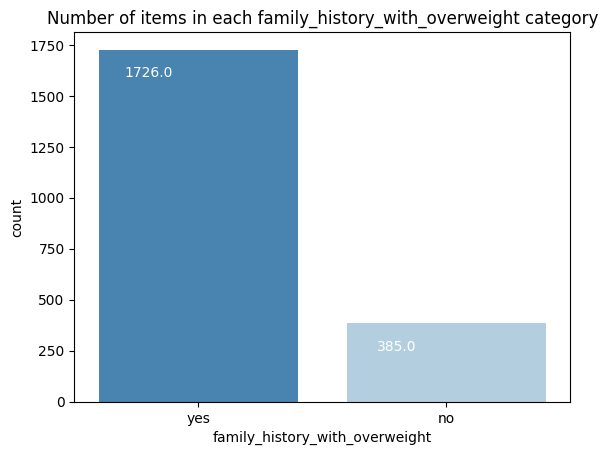

In [ ]:
count_values(obesity_data, "family_history_with_overweight")

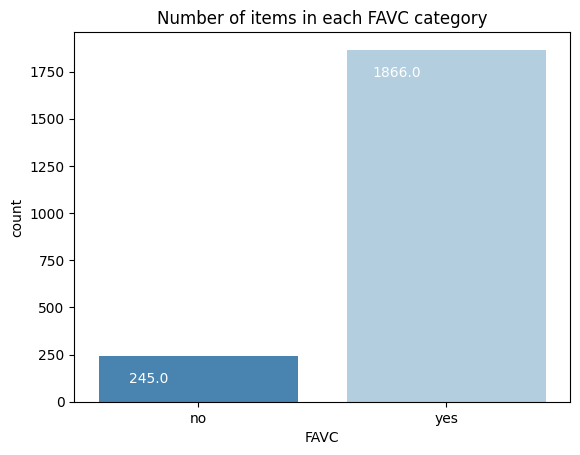

In [ ]:
count_values(obesity_data, "FAVC")

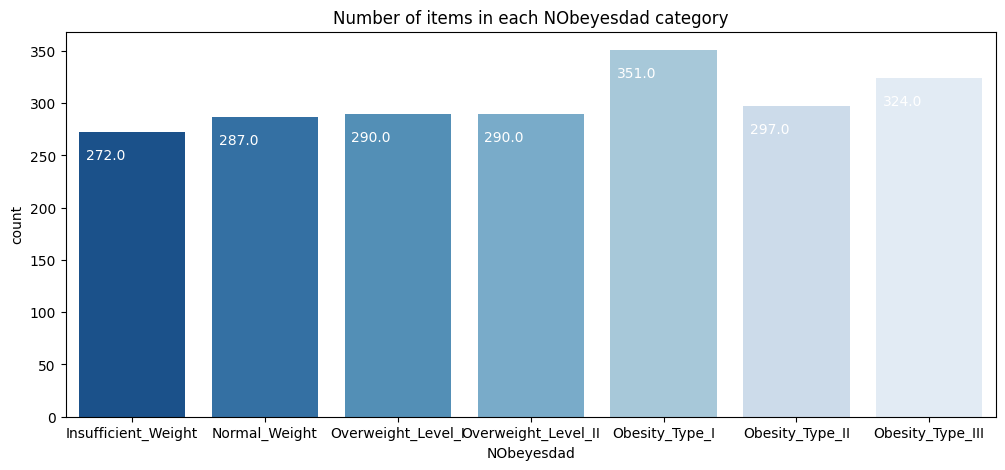

In [ ]:
plt.figure(figsize = (12, 5))
count_values(obesity_data, "NObeyesdad", ["Insufficient_Weight", "Normal_Weight", "Overweight_Level_I", "Overweight_Level_II", "Obesity_Type_I", "Obesity_Type_II", "Obesity_Type_III"])

In [ ]:
def cross_plot(dataset, lead_category, sup_category, order = None):
    """
    Function: Plots interaction between two categorical variables.

    Parameters: Dataset, lead category, suplemental category, and order of appearance (order is optional).
    """

    sns.countplot(x = lead_category, hue = sup_category, data = dataset, order = order, palette = "Blues_r")

    plt.show()

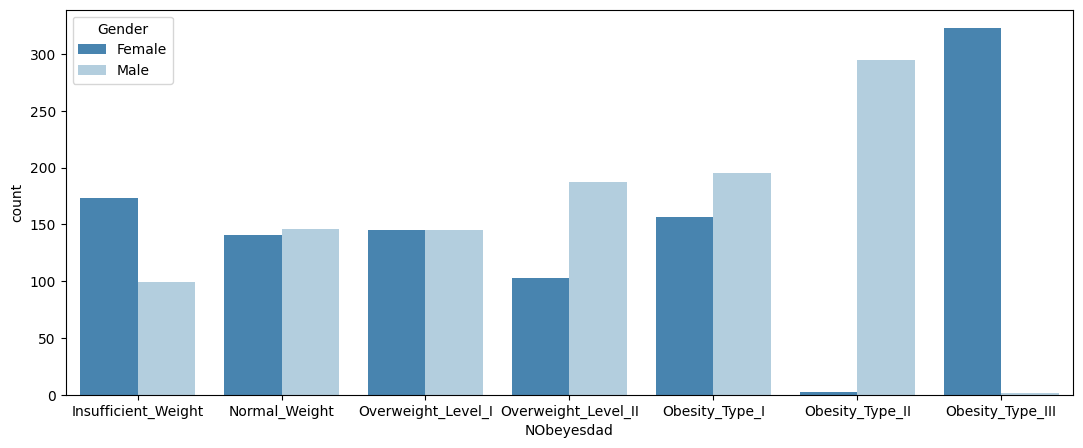

In [ ]:
plt.figure(figsize = (13, 5))
cross_plot(obesity_data, "NObeyesdad", "Gender", ["Insufficient_Weight", "Normal_Weight", "Overweight_Level_I", "Overweight_Level_II", "Obesity_Type_I", "Obesity_Type_II", "Obesity_Type_III"])

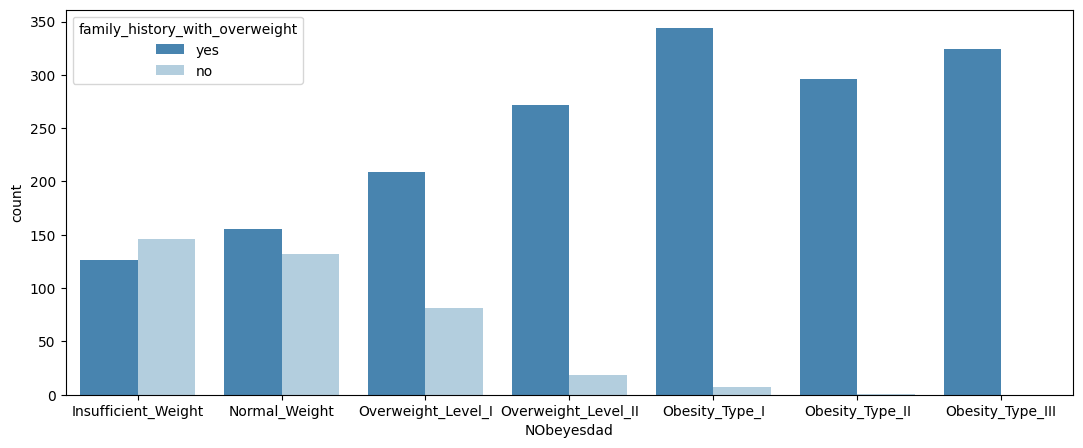

In [ ]:
plt.figure(figsize = (13, 5))
cross_plot(obesity_data, "NObeyesdad", "family_history_with_overweight", ["Insufficient_Weight", "Normal_Weight", "Overweight_Level_I", "Overweight_Level_II", "Obesity_Type_I", "Obesity_Type_II", "Obesity_Type_III"])

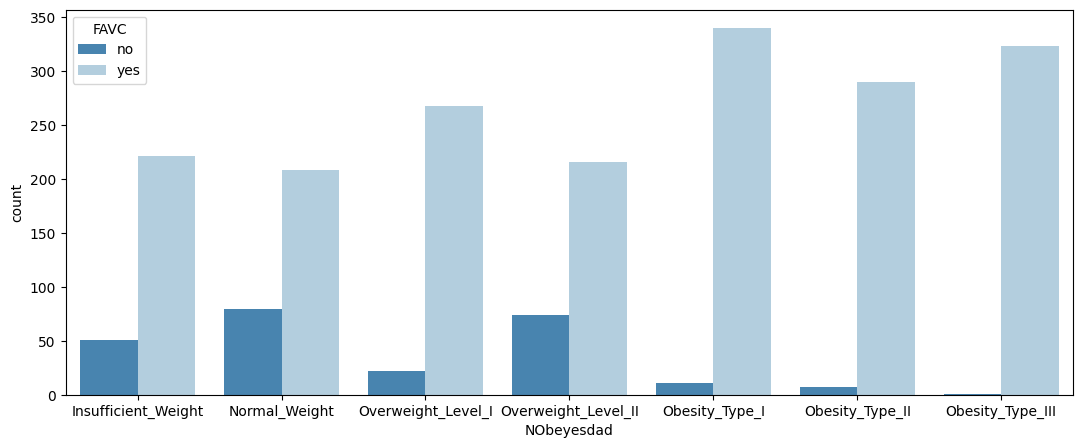

In [ ]:
plt.figure(figsize = (13, 5))
cross_plot(obesity_data, "NObeyesdad", "FAVC", ["Insufficient_Weight", "Normal_Weight", "Overweight_Level_I", "Overweight_Level_II", "Obesity_Type_I", "Obesity_Type_II", "Obesity_Type_III"])

In [ ]:
obesity_numeric = obesity_data[["Age", "Height", "Weight", "FCVC", "NCP", "CH2O", "FAF", "TUE"]]

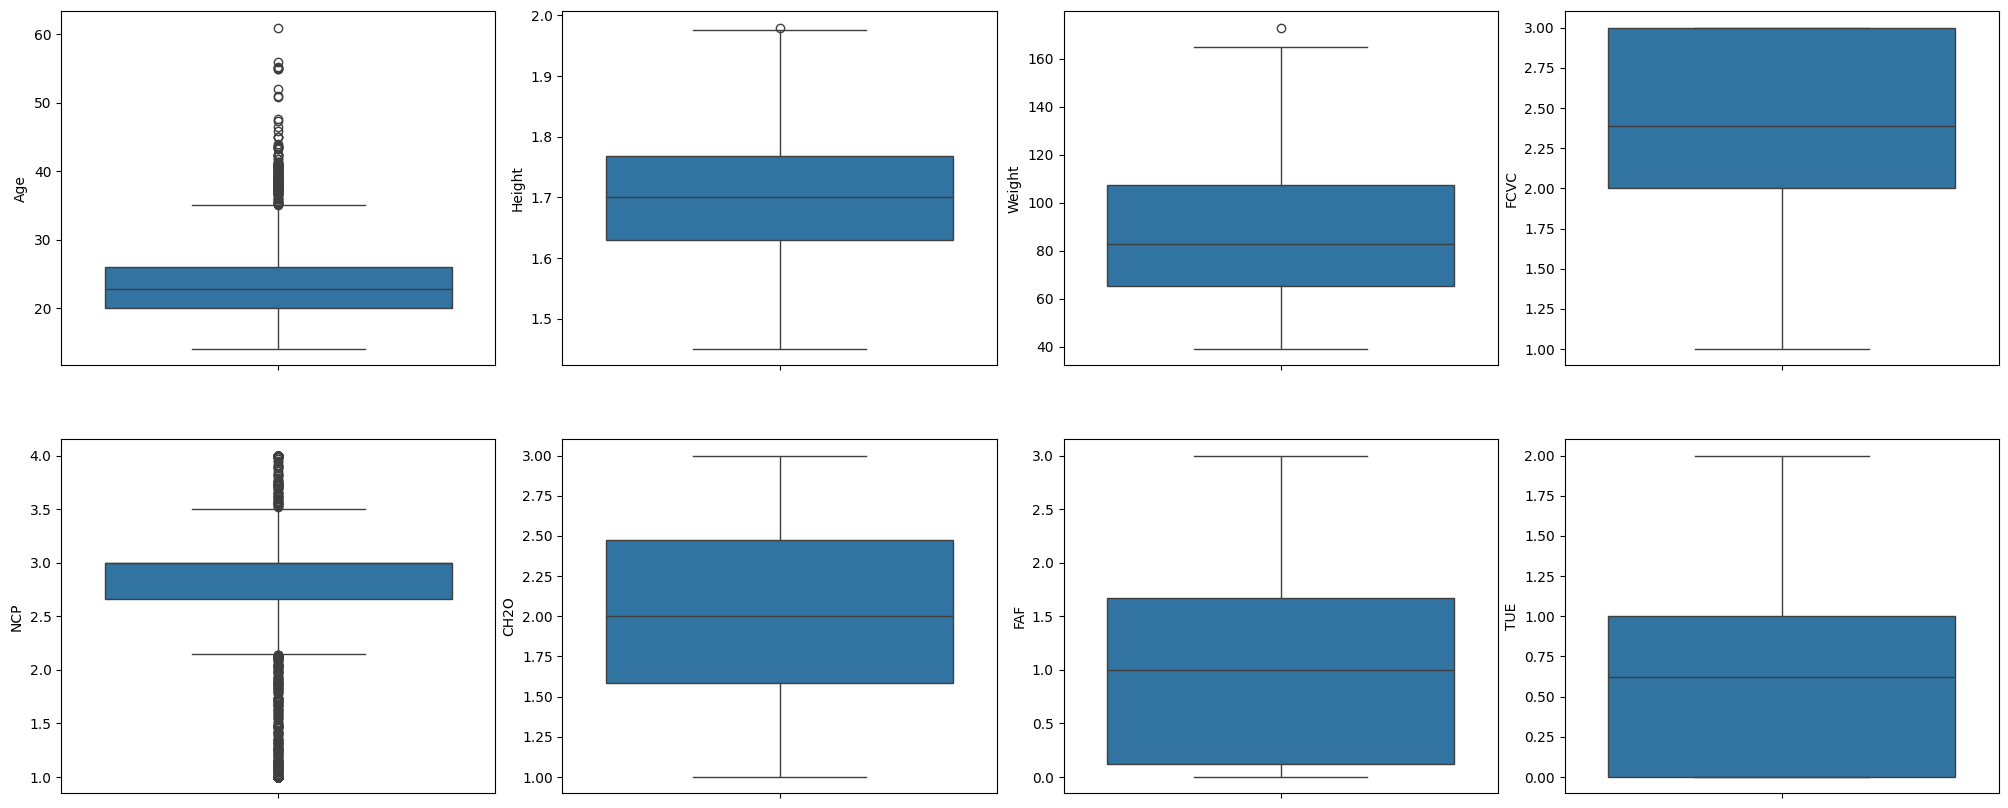

In [ ]:
fig, axs = plt.subplots(ncols = 4, nrows = 2, figsize = (20, 8))
# fig.delaxes(axs[1][3])
idx = 0
axs = axs.flatten()
for k, v in obesity_numeric.items():
    sns.boxplot(y = k, data = obesity_numeric, ax = axs[idx])
    idx += 1
plt.tight_layout(pad = 0.4, w_pad = 0.5, h_pad = 5.0)

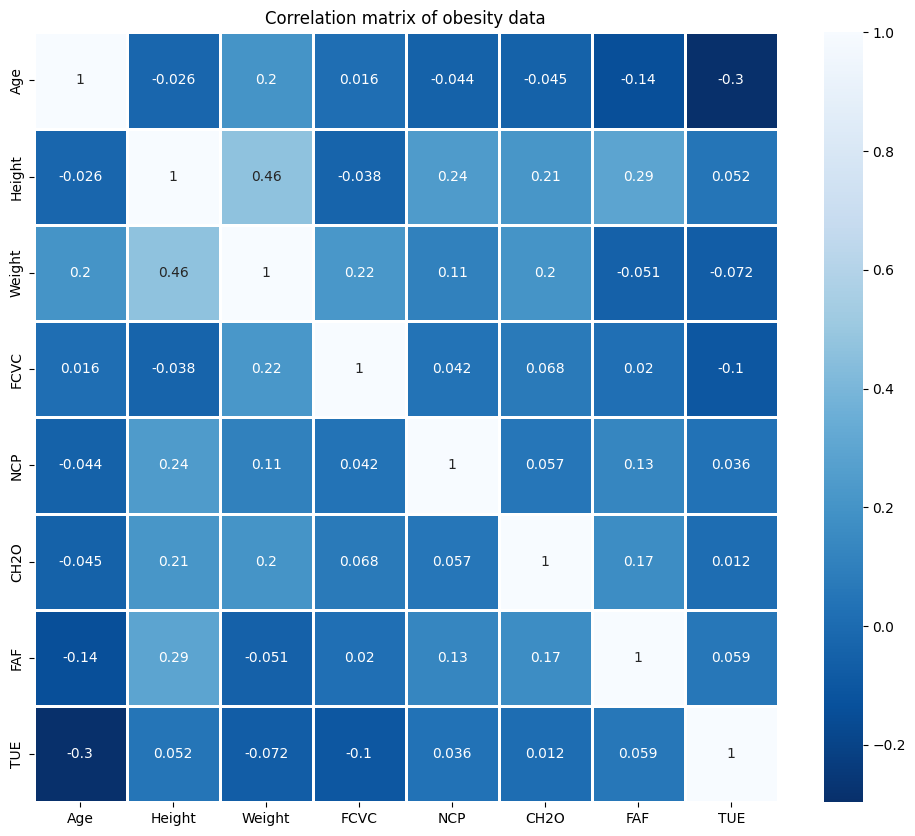

In [ ]:
plt.figure(figsize = (12, 10))
sns.heatmap(obesity_data.corr(),
           annot = True,
           cmap = "Blues_r",
           linewidths = 2,
           linecolor = "white")
plt.title("Correlation matrix of obesity data")
plt.show()

# Encoding features


In [ ]:
obesity_dummies = pd.get_dummies(obesity_data[["Gender", "family_history_with_overweight", "FAVC", "CAEC", "SMOKE", "SCC", "CALC", "MTRANS"]])

In [ ]:
obesity_lab = obesity_data[["NObeyesdad"]]

In [ ]:
obesity_concatenated = pd.concat([obesity_numeric, obesity_dummies, obesity_lab], axis = 1)

In [ ]:
obesity_concatenated.head()

Age  Height  Weight  FCVC  NCP  CH2O  FAF  TUE  Gender_Female  \
0  21.0    1.62    64.0   2.0  3.0   2.0  0.0  1.0              1   
1  21.0    1.52    56.0   3.0  3.0   3.0  3.0  0.0              1   
2  23.0    1.80    77.0   2.0  3.0   2.0  2.0  1.0              0   
3  27.0    1.80    87.0   3.0  3.0   2.0  2.0  0.0              0   
4  22.0    1.78    89.8   2.0  1.0   2.0  0.0  0.0              0   

   Gender_Male  family_history_with_overweight_no  \
0            0                                  0   
1            0                                  0   
2            1                                  0   
3            1                                  1   
4            1                                  1   

   family_history_with_overweight_yes  FAVC_no  FAVC_yes  CAEC_Always  \
0                                   1        1         0            0   
1                                   1        1         0            0   
2                                   1        1         0            0   
3                                   0        1         0            0   
4                                   0        1         0            0   

   CAEC_Frequently  CAEC_Sometimes  CAEC_no  SMOKE_no  SMOKE_yes  SCC_no  \
0                0               1        0         1          0       1   
1                0               1        0         0          1       0   
2                0               1        0         1          0       1   
3                0               1        0         1          0       1   
4                0               1        0         1          0       1   

   SCC_yes  CALC_Always  CALC_Frequently  CALC_Sometimes  CALC_no  \
0        0            0                0               0        1   
1        1            0                0               1        0   
2        0            0                1               0        0   
3        0            0                1               0        0   
4        0            0                0               1        0   

   MTRANS_Automobile  MTRANS_Bike  MTRANS_Motorbike  \
0                  0            0                 0   
1                  0            0                 0   
2                  0            0                 0   
3                  0            0                 0   
4                  0            0                 0   

   MTRANS_Public_Transportation  MTRANS_Walking           NObeyesdad  
0                             1               0        Normal_Weight  
1                             1               0        Normal_Weight  
2                             1               0        Normal_Weight  
3                             0               1   Overweight_Level_I  
4                             1               0  Overweight_Level_II

In [ ]:
obesity_label = obesity_concatenated["NObeyesdad"]
obesity_features = obesity_concatenated.drop("NObeyesdad", axis = 1)

In [ ]:
obesity_label

0             Normal_Weight
1             Normal_Weight
2             Normal_Weight
3        Overweight_Level_I
4       Overweight_Level_II
               ...         
2106       Obesity_Type_III
2107       Obesity_Type_III
2108       Obesity_Type_III
2109       Obesity_Type_III
2110       Obesity_Type_III
Name: NObeyesdad, Length: 2111, dtype: object

In [ ]:
obesity_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 31 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Age                                 2111 non-null   float64
 1   Height                              2111 non-null   float64
 2   Weight                              2111 non-null   float64
 3   FCVC                                2111 non-null   float64
 4   NCP                                 2111 non-null   float64
 5   CH2O                                2111 non-null   float64
 6   FAF                                 2111 non-null   float64
 7   TUE                                 2111 non-null   float64
 8   Gender_Female                       2111 non-null   uint8  
 9   Gender_Male                         2111 non-null   uint8  
 10  family_history_with_overweight_no   2111 non-null   uint8  
 11  family_history_with_overweight_yes  2111 no

In [ ]:
obesity_features = obesity_features.astype("float")

In [ ]:
obesity_features_scaled = MinMaxScaler().fit_transform(obesity_features)

In [ ]:
obesity_features_scaled.min(axis = 1), obesity_features_scaled.max(axis = 1)

(array([0., 0., 0., ..., 0., 0., 0.]), array([1., 1., 1., ..., 1., 1., 1.]))

In [ ]:
encoder = LabelEncoder()

In [ ]:
encoder.fit(obesity_label)

LabelEncoder()

In [ ]:
list(encoder.classes_)

['Insufficient_Weight',
 'Normal_Weight',
 'Obesity_Type_I',
 'Obesity_Type_II',
 'Obesity_Type_III',
 'Overweight_Level_I',
 'Overweight_Level_II']

In [ ]:
obesity_labels_encoded = encoder.transform(obesity_label)

In [ ]:
obesity_labels_encoded

array([1, 1, 1, ..., 4, 4, 4])

**Train -test split**

In [ ]:
obesity_features_tr, obesity_features_ts, obesity_labels_tr, obesity_labels_ts = train_test_split(
                obesity_features, obesity_labels_encoded,
                test_size = 0.2, stratify = obesity_labels_encoded,
                random_state = 42) # shuffle=True

In [ ]:
obesity_features_tr.shape, obesity_labels_tr.shape, obesity_features_ts.shape, obesity_labels_ts.shape

((1688, 31), (1688,), (423, 31), (423,))

In [ ]:
Counter(obesity_labels_tr)

Counter({5: 232, 1: 229, 6: 232, 0: 218, 3: 237, 4: 259, 2: 281})

In [ ]:
Counter(obesity_labels_ts)

Counter({0: 54, 1: 58, 6: 58, 4: 65, 3: 60, 2: 70, 5: 58})

# Train model to classify data into obesity categories


In [ ]:
f1 = make_scorer(f1_score, average = "weighted")

In [ ]:
params = {
    "max_depth": [5, 7, 9, 11, 13, 15]
}

In [ ]:
grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid = params, cv = 5, scoring = f1)

In [ ]:
grid_search.fit(obesity_features_tr, obesity_labels_tr)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [5, 7, 9, 11, 13, 15]},
             scoring=make_scorer(f1_score, average=weighted))

In [ ]:
grid_search.cv_results_

{'mean_fit_time': array([0.01514997, 0.01227851, 0.01393762, 0.0131896 , 0.01390038,
        0.01496921]),
 'std_fit_time': array([7.22071739e-03, 6.35775146e-04, 1.26487442e-03, 9.21459154e-05,
        1.06492764e-03, 2.84791837e-03]),
 'mean_score_time': array([0.00492373, 0.00465121, 0.00510049, 0.00441008, 0.00450611,
        0.00462584]),
 'std_score_time': array([5.58417695e-04, 2.94190465e-04, 7.10169878e-04, 6.96746062e-05,
        1.25716107e-04, 4.49583188e-04]),
 'param_max_depth': masked_array(data=[5, 7, 9, 11, 13, 15],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 5},
  {'max_depth': 7},
  {'max_depth': 9},
  {'max_depth': 11},
  {'max_depth': 13},
  {'max_depth': 15}],
 'split0_test_score': array([0.77086901, 0.87205324, 0.90417874, 0.91106588, 0.91686586,
        0.90791357]),
 'split1_test_score': array([0.82670016, 0.91510327, 0.92620766, 0.93809226, 0.93237201,
        0.92

In [ ]:
grid_search.best_params_

{'max_depth': 13}

**Evaluate and train model**

In [ ]:
model_tree = DecisionTreeClassifier(max_depth = 13, random_state = 42)

In [ ]:
def train_predict_score(estimator, train_features, train_labels, test_features, test_labels):
    """
    Function: Trains model, predict classes and computes accuracy and f1 score.

    Parameters: estimator, X_train, y_train, X_test, y_test.
    """
    estimator.fit(train_features, train_labels)

    print(f"Accuracy on Train data: {accuracy_score(train_labels, estimator.predict(train_features))}")
    print(f"F1 score on Train data: {f1_score(train_labels, estimator.predict(train_features), average = 'weighted')}")
    print(f"Accuracy on Test data: {accuracy_score(test_labels, estimator.predict(test_features))}")
    print(f"F1 on Test data: {f1_score(test_labels, estimator.predict(test_features), average = 'weighted')}")

In [ ]:
train_predict_score(model_tree, obesity_features_tr, obesity_labels_tr, obesity_features_ts, obesity_labels_ts)

Accuracy on Train data: 1.0
F1 score on Train data: 1.0
Accuracy on Test data: 0.9148936170212766
F1 on Test data: 0.9152724912457364


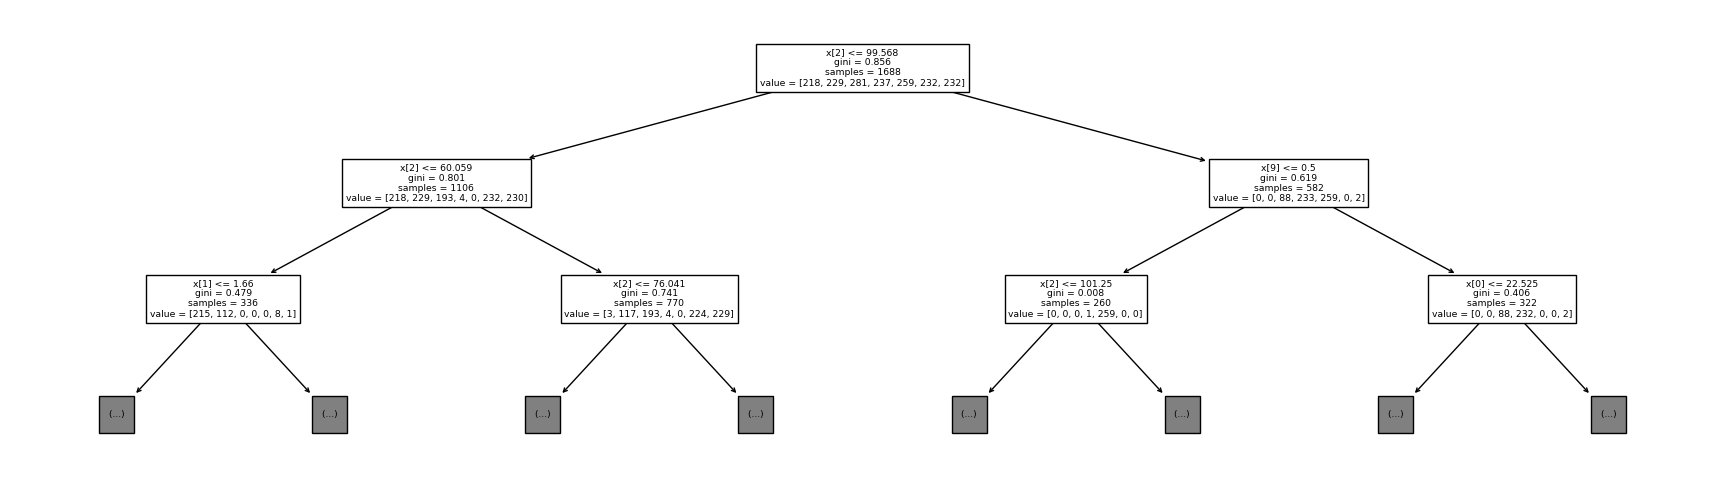

In [ ]:
plt.figure(figsize = (22, 6))
plot_tree(model_tree, max_depth = 2)
plt.show()

In [ ]:
print(classification_report(obesity_labels_ts, model_tree.predict(obesity_features_ts)))

              precision    recall  f1-score   support

           0       0.96      0.87      0.91        54
           1       0.80      0.84      0.82        58
           2       0.91      0.96      0.93        70
           3       0.97      0.95      0.96        60
           4       1.00      0.98      0.99        65
           5       0.86      0.86      0.86        58
           6       0.91      0.91      0.91        58

    accuracy                           0.91       423
   macro avg       0.92      0.91      0.91       423
weighted avg       0.92      0.91      0.92       423



In [ ]:
model_tree.classes_

array([0, 1, 2, 3, 4, 5, 6])

In [ ]:
list(encoder.classes_)

['Insufficient_Weight',
 'Normal_Weight',
 'Obesity_Type_I',
 'Obesity_Type_II',
 'Obesity_Type_III',
 'Overweight_Level_I',
 'Overweight_Level_II']

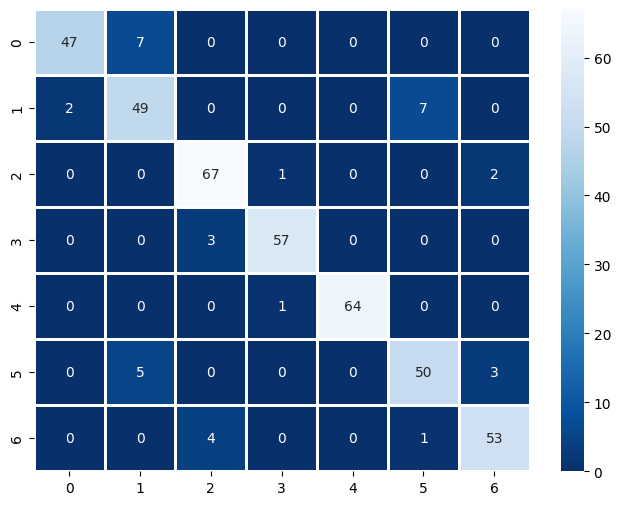

In [ ]:
plt.figure(figsize = (8, 6))
sns.heatmap(confusion_matrix(obesity_labels_ts, model_tree.predict(obesity_features_ts)),
           annot = True,
           fmt = ".0f",
           cmap = "Blues_r",
           linewidths = 2,
           linecolor = "white",
           xticklabels = model_tree.classes_,
           yticklabels = model_tree.classes_)
plt.show()

In [ ]:
obesity_score_probability = model_tree.predict_proba(obesity_features_ts)

In [ ]:
obesity_score_probability

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]])

In [ ]:
roc_auc_score(obesity_labels_ts, obesity_score_probability, multi_class = "ovr")

0.948826099443833

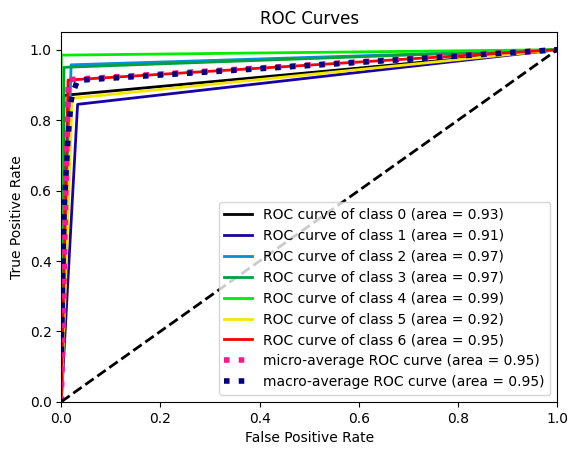

In [ ]:
import scikitplot as skplt
skplt.metrics.plot_roc(obesity_labels_ts, obesity_score_probability)
plt.show()

# Running SHAP analysis on the Tree model



In [ ]:
import shap
from sklearn.metrics import accuracy_score, f1_score

def train_predict_score(estimator, train_features, train_labels, test_features, test_labels):
    """
    Function: Trains model, predicts classes, computes accuracy and F1 score, and performs SHAP analysis.

    Parameters: estimator, train_features, train_labels, test_features, test_labels.
    """
    # Train the model
    estimator.fit(train_features, train_labels)

    # Print accuracy and F1 scores on train data
    train_pred = estimator.predict(train_features)
    print(f"Accuracy on Train data: {accuracy_score(train_labels, train_pred)}")
    print(f"F1 score on Train data: {f1_score(train_labels, train_pred, average='weighted')}")

    # Print accuracy and F1 scores on test data
    test_pred = estimator.predict(test_features)
    print(f"Accuracy on Test data: {accuracy_score(test_labels, test_pred)}")
    print(f"F1 on Test data: {f1_score(test_labels, test_pred, average='weighted')}")

    # Calculate SHAP values
    explainer = shap.TreeExplainer(estimator)
    shap_values = explainer.shap_values(test_features)

    # Generate SHAP summary plot for feature importance insights
    shap.summary_plot(shap_values, test_features)


Accuracy on Train data: 1.0
F1 score on Train data: 1.0
Accuracy on Test data: 0.9406130268199234
F1 on Test data: 0.9402249016198095


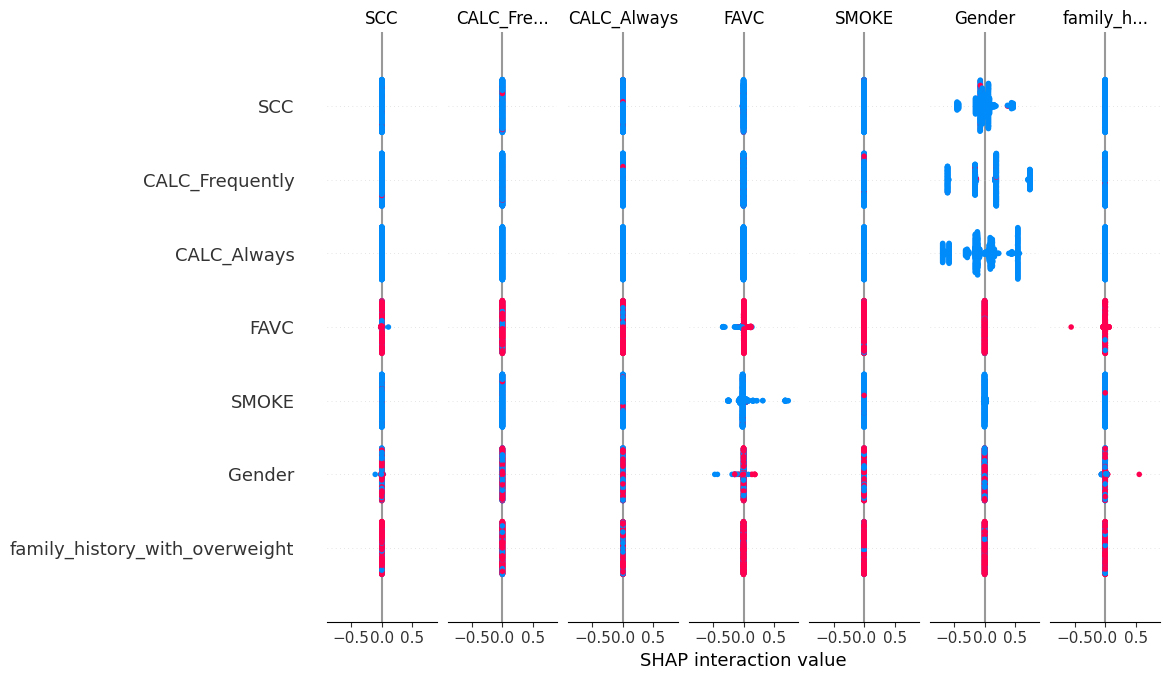

In [ ]:

model_tree = DecisionTreeClassifier(max_depth=13, random_state=42)
train_predict_score(model_tree, X_train, y_train, X_test, y_test)



# Interpreting the SHAP results of Tree model

Here’s what we can infer from the plot:

For people with no family history of overweight (the leftmost section of the plot), there is a negative relationship between smoking frequency and SCC. This means that as smoking frequency increases, the SCC score decreases.
For people with a family history of overweight (the rightmost section of the plot), the relationship between smoking frequency and SCC is positive. This means that as smoking frequency increases, the SCC score increases.
Overall, the plot suggests that there is an interaction effect between family history with overweight and smoking frequency on SCC.

# AUTO ML



**Using H2O to findout the best fitting model to our dataset**


Import the h2o Python module and H2OAutoML class and initialize a local H2O cluster.

In [ ]:
!pip install requests
!pip install tabulate
!pip install "colorama>=0.3.8"
!pip install future
!pip install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o

Looking in links: http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html


In [ ]:
# Installing packages and libraries required to run h2o

import glob, re
import numpy as np
import pandas as pd
from sklearn import *
from datetime import datetime
from xgboost import XGBRegressor
import h2o
from h2o.automl import H2OAutoML

In [ ]:
# Initializing the h2o cluster
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.22" 2024-01-16; OpenJDK Runtime Environment (build 11.0.22+7-post-Ubuntu-0ubuntu222.04.1); OpenJDK 64-Bit Server VM (build 11.0.22+7-post-Ubuntu-0ubuntu222.04.1, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.10/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp4i8jk6r_
  JVM stdout: /tmp/tmp4i8jk6r_/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp4i8jk6r_/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  -----------------------------------------------------------------------------------------
H2O_cluster_uptime:         04 secs
H2O_cluster_timezone:       Etc/UTC
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.46.0.1
H2O_cluster_version_age:    3 days
H2O_cluster_name:           H2O_from_python_unknownUser_9pwfnt
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    3.170 Gb
H2O_cluster_total_cores:    2
H2O_cluster_allowed_cores:  2
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://127.0.0.1:54321
H2O_connection_proxy:       {"http": null, "https": null, "colab_language_server": "/usr/colab/bin/language_service"}
H2O_internal_security:      False
Python_version:             3.10.12 final
--------------------------  -----------------------------------------------------------------------------------------

In [ ]:
# Reading the csv file of our dataset
from google.colab import drive
drive.mount('/content/gdrive')
data = pd.read_csv('/content/gdrive/MyDrive/EDA-Assignment_1/ObesityDataSet_raw_and_data_sinthetic.csv')
data.head()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Gender   Age  Height  Weight family_history_with_overweight FAVC  FCVC  \
0  Female  21.0    1.62    64.0                            yes   no   2.0   
1  Female  21.0    1.52    56.0                            yes   no   3.0   
2    Male  23.0    1.80    77.0                            yes   no   2.0   
3    Male  27.0    1.80    87.0                             no   no   3.0   
4    Male  22.0    1.78    89.8                             no   no   2.0   

   NCP       CAEC SMOKE  CH2O  SCC  FAF  TUE        CALC  \
0  3.0  Sometimes    no   2.0   no  0.0  1.0          no   
1  3.0  Sometimes   yes   3.0  yes  3.0  0.0   Sometimes   
2  3.0  Sometimes    no   2.0   no  2.0  1.0  Frequently   
3  3.0  Sometimes    no   2.0   no  2.0  0.0  Frequently   
4  1.0  Sometimes    no   2.0   no  0.0  0.0   Sometimes   

                  MTRANS           NObeyesdad  
0  Public_Transportation        Normal_Weight  
1  Public_Transportation        Normal_Weight  
2  Public_Transportation        Normal_Weight  
3                Walking   Overweight_Level_I  
4  Public_Transportation  Overweight_Level_II

In [ ]:
data.corr().unstack().sort_values().drop_duplicates()
#checking correlation between variables

<ipython-input-8-34eef0e2a2a8>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data.corr().unstack().sort_values().drop_duplicates()


TUE     Age      -0.296931
FAF     Age      -0.144938
FCVC    TUE      -0.101135
TUE     Weight   -0.071561
Weight  FAF      -0.051436
Age     CH2O     -0.045304
NCP     Age      -0.043944
Height  FCVC     -0.038121
        Age      -0.025958
TUE     CH2O      0.011965
Age     FCVC      0.016291
FAF     FCVC      0.019939
NCP     TUE       0.036326
FCVC    NCP       0.042216
TUE     Height    0.051912
CH2O    NCP       0.057088
FAF     TUE       0.058562
FCVC    CH2O      0.068461
Weight  NCP       0.107469
NCP     FAF       0.129504
FAF     CH2O      0.167236
Weight  CH2O      0.200575
        Age       0.202560
CH2O    Height    0.213376
FCVC    Weight    0.216125
Height  NCP       0.243672
FAF     Height    0.294709
Height  Weight    0.463136
Age     Age       1.000000
dtype: float64

In [ ]:
#Importing our dataset with H2O.
df = h2o.import_file('/content/ObesityDataSet_raw_and_data_sinthetic.csv')

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [ ]:
df.types

{'Gender': 'enum',
 'Age': 'real',
 'Height': 'real',
 'Weight': 'real',
 'family_history_with_overweight': 'enum',
 'FAVC': 'enum',
 'FCVC': 'real',
 'NCP': 'real',
 'CAEC': 'enum',
 'SMOKE': 'enum',
 'CH2O': 'real',
 'SCC': 'enum',
 'FAF': 'real',
 'TUE': 'real',
 'CALC': 'enum',
 'MTRANS': 'enum',
 'NObeyesdad': 'enum'}

In [ ]:
df.describe()

Rows:2111
Cols:17

Gender    Age                 Height              Weight              family_history_with_overweight    FAVC    FCVC               NCP                 CAEC       SMOKE    CH2O                SCC    FAF                 TUE                 CALC        MTRANS                 NObeyesdad
-------  --------  ------------------  ------------------  ------------------  --------------------------------  ------  -----------------  ------------------  ---------  -------  ------------------  -----  ------------------  ------------------  ----------  ---------------------  -------------------
type     enum      real                real                real                enum                              enum    real               real                enum       enum     real                enum   real                real                enum        enum                   enum
mins               14.0                1.45                39.0                                                          1.0                1.0                                     1.0                        0.0                 0.0
mean               24.312599908574136  1.7016773533870204  86.58605812648032                                             2.419043061582189  2.6856280497394596                      2.0080114040738986         1.0102976958787304  0.6578659237328283
maxs               61.0                1.98                173.0                                                         3.0                4.0                                     3.0                        3.0                 2.0
sigma              6.345968273732234   0.09330481986792    26.191171745204677                                            0.5339265785033    0.7780386488418612                      0.6129534517968722         0.8505924308366978  0.6089272596763782
zeros              0                   0                   0                                                             0                  0                                       0                          411                 557
missing  0         0                   0                   0                   0                                 0       0                  0                   0          0        0                   0      0                   0                   0           0                      0
0        Female    21.0                1.62                64.0                yes                               no      2.0                3.0                 Sometimes  no       2.0                 no     0.0                 1.0                 no          Public_Transportation  Normal_Weight
1        Female    21.0                1.52                56.0                yes                               no      3.0                3.0                 Sometimes  yes      3.0                 yes    3.0                 0.0                 Sometimes   Public_Transportation  Normal_Weight
2        Male      23.0                1.8                 77.0                yes                               no      2.0                3.0                 Sometimes  no       2.0                 no     2.0                 1.0                 Frequently  Public_Transportation  Normal_Weight
3        Male      27.0                1.8                 87.0                no                                no      3.0                3.0                 Sometimes  no       2.0                 no     2.0                 0.0                 Frequently  Walking                Overweight_Level_I
4        Male      22.0                1.78                89.8                no                                no      2.0                1.0                 Sometimes  no       2.0                 no     0.0                 0.0                 Sometimes   Public_Transportation  Overweight_Level_II
5        Male      29.0                1.62                53.0                no                                yes     2.0                3.0                 Sometim

In [ ]:
#Splitting our dataset into 3 datasets, one for training, other for testing and last one for validation purposes. (0.7,0.15,0.15 split)
df_train,df_test,df_valid = df.split_frame(ratios=[.7, .15])

In [ ]:
df_train

Gender      Age    Height    Weight  family_history_with_overweight    FAVC      FCVC    NCP  CAEC        SMOKE      CH2O  SCC      FAF    TUE  CALC        MTRANS                 NObeyesdad
--------  -----  --------  --------  --------------------------------  ------  ------  -----  ----------  -------  ------  -----  -----  -----  ----------  ---------------------  -------------------
Female       21      1.62        64  yes                               no           2      3  Sometimes   no            2  no         0      1  no          Public_Transportation  Normal_Weight
Female       21      1.52        56  yes                               no           3      3  Sometimes   yes           3  yes        3      0  Sometimes   Public_Transportation  Normal_Weight
Male         23      1.8         77  yes                               no           2      3  Sometimes   no            2  no         2      1  Frequently  Public_Transportation  Normal_Weight
Male         27      1.8         87  no                                no           3      3  Sometimes   no            2  no         2      0  Frequently  Walking                Overweight_Level_I
Female       23      1.5         55  yes                               yes          3      3  Sometimes   no            2  no         1      0  Sometimes   Motorbike              Normal_Weight
Male         22      1.64        53  no                                no           2      3  Sometimes   no            2  no         3      0  Sometimes   Public_Transportation  Normal_Weight
Male         24      1.78        64  yes                               yes          3      3  Sometimes   no            2  no         1      1  Frequently  Public_Transportation  Normal_Weight
Male         22      1.72        68  yes                               yes          2      3  Sometimes   no            2  no         1      1  no          Public_Transportation  Normal_Weight
Male         26      1.85       105  yes                               yes          3      3  Frequently  no            3  no         2      2  Sometimes   Public_Transportation  Obesity_Type_I
Female       21      1.72        80  yes                               yes          2      3  Frequently  no            2  yes        2      1  Sometimes   Public_Transportation  Overweight_Level_II
[1506 rows x 17 columns]

In [ ]:
#Removing target variable from dataset. to create input varaibles and output (or) target variable.
y = "NObeyesdad"
x = df.columns
x.remove(y)

In [ ]:
#Using H2O automl
#Setting models thresold to "10", more models we use it takes more time to come up with the best model and hyperparameters.
#To create a simpler model we are excluding "StackedEnsemble" and "DeepLearning", tho they are really good.
aml = H2OAutoML(max_models = 10, seed = 10, exclude_algos = ["StackedEnsemble", "DeepLearning"], verbosity="info", nfolds=0)
#taken from references

In [ ]:
#starting the automl process
#It will test all the 10 models and update the leading model according to performance.
#We can see for the variable importance at the end as well. Gives us rough Idea of which
#variable will it be using for the prediction purposes.
aml.train(x = x, y = y, training_frame = df_train, validation_frame=df_valid)

AutoML progress: |
21:17:29.723: Project: AutoML_1_20240316_211729
21:17:29.724: Cross-validation disabled by user: no fold column nor nfolds > 1.
21:17:29.725: Setting stopping tolerance adaptively based on the training frame: 0.025768403601503658
21:17:29.726: Build control seed: 10
21:17:29.731: training frame: Frame key: AutoML_1_20240316_211729_training_py_2_sid_a974    cols: 17    rows: 1506  chunks: 8    size: 94682  checksum: -861883743555384682
21:17:29.733: validation frame: Frame key: py_4_sid_a974    cols: 17    rows: 295  chunks: 8    size: 57077  checksum: -6666403927262871553
21:17:29.738: leaderboard frame: Frame key: py_4_sid_a974    cols: 17    rows: 295  chunks: 8    size: 57077  checksum: -6666403927262871553
21:17:29.738: blending frame: NULL
21:17:29.739: response column: NObeyesdad
21:17:29.739: fold column: null
21:17:29.739: weights column: null
21:17:29.790: Loading execution steps: [{XGBoost : [def_2 (1g, 10w), def_1 (2g, 10w), def_3 (3g, 10w), grid_1 (4g, 90

Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_3_AutoML_1_20240316_211729


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    110                770                         503076                 4            8            7.98961       5             80            47.2883

ModelMetricsMultinomial: gbm
** Reported on train data. **

MSE: 2.3761946765838217e-07
RMSE: 0.0004874622730616003
LogLoss: 0.00019165418777132914
Mean Per-Class Error: 0.0
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
Insufficient_Weight    Normal_Weight    Obesity_Type_I    Obesity_Type_II    Obesity_Type_III    Overweight_Level_I    Overweight_Level_II    Error    Rate
---------------------  ---------------  ----------------  -----------------  ------------------  --------------------  ---------------------  -------  ---------
203                    0                0                 0                  0                   0                     0                      0        0 / 203
0                      193              0                 0                  0                   0                     0                      0        0 / 193
0                      0                256               0                  0                   0                     0                      0        0 / 256
0                      0                0                 196                0                   0                     0                      0        0 / 196
0                      0                0                 0                  228                 0                     0                      0        0 / 228
0                      0                0                 0                  0                   223                   0                      0        0 / 223
0                      0                0                 0                  0                   0                     207                    0        0 / 207
203                    193              256               196                228                 223                   207                    0        0 / 1,506

Top-7 Hit Ratios: 
k    hit_ratio
---  -----------
1    1
2    1
3    1
4    1
5    1
6    1
7    1

ModelMetricsMultinomial: gbm
** Reported on validation data. **

MSE: 0.02050649742954201
RMSE: 0.1432008988433453
LogLoss: 0.07361481046850335
Mean Per-Class Error: 0.021659715840814307
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
Insufficient_Weight    Normal_Weight    Obesity_Type_I    Obesity_Type_II    Obesity_Type_III    Overweight_Level_I    Overweight_Level_II    Error      Rate
---------------------  ---------------  ----------------  -----------------  ------------------  --------------------  ---------------------  ---------  -------
38                     0                0                 0                  0                   0                     0                      0          0 / 38
0                      41               0    

**Variable Importance**

Weight

Height

Gender

FCVC

Age

are the most important variables for predicitng the obesity levels.

In [ ]:
#Creates the leader Board for all out models, ranking them by their performance(default: mean_per_class_error	)
#We can also observe that as we go below the leaderboard the logloss, rmse and mse are increasing as well.
#Here from the leaderboard we have "GBM_2_AutoML_1_20240316_211729	" as the leader(best performing) model .

lb = aml.leaderboard

In [ ]:
lb.head()

model_id                              mean_per_class_error    logloss      rmse        mse
----------------------------------  ----------------------  ---------  --------  ---------
GBM_3_AutoML_1_20240316_211729                   0.0216597  0.0736148  0.143201  0.0205065
GBM_2_AutoML_1_20240316_211729                   0.0218421  0.0591114  0.130076  0.0169197
GBM_5_AutoML_1_20240316_211729                   0.0252647  0.0696465  0.134604  0.0181183
GBM_4_AutoML_1_20240316_211729                   0.0254471  0.0778002  0.152141  0.0231468
XGBoost_3_AutoML_1_20240316_211729               0.0287694  0.10104    0.16277   0.0264939
GBM_1_AutoML_1_20240316_211729                   0.029729   0.0973464  0.167358  0.0280087
XGBoost_2_AutoML_1_20240316_211729               0.0401719  0.148268   0.202609  0.0410505
DRF_1_AutoML_1_20240316_211729                   0.0427893  0.252143   0.27261   0.0743162
XGBoost_1_AutoML_1_20240316_211729               0.0543203  0.19787    0.234349  0.0549194
XRT_1_AutoML_1_20240316_211729                   0.054603   0.325745   0.307499  0.0945556
[10 rows x 5 columns]

In [ ]:
#Using the leader model for prediction.
OverWeight_pred=aml.leader.predict(df_test)

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


In [ ]:
OverWeight_pred.head()
#predicitions

predict                Insufficient_Weight    Normal_Weight    Obesity_Type_I    Obesity_Type_II    Obesity_Type_III    Overweight_Level_I    Overweight_Level_II
-------------------  ---------------------  ---------------  ----------------  -----------------  ------------------  --------------------  ---------------------
Normal_Weight                  3.05157e-05      0.99974           1.34093e-05        2.01009e-06         6.91011e-07           0.000206227            6.7505e-06
Obesity_Type_I                 1.60104e-06      5.7564e-05        0.997222           5.69585e-07         4.65456e-07           0.00130406             0.0014136
Overweight_Level_II            3.46407e-06      2.15454e-05       0.00136542         6.66493e-07         9.18265e-07           0.000250476            0.998358
Overweight_Level_I             0.00020035       0.0344799         0.00028547         0.000106125         1.04692e-05           0.941198               0.0237197
Normal_Weight                  2.81331e-06      0.997413          3.28387e-05        1.68768e-06         7.51954e-07           0.00252233             2.67611e-05
Normal_Weight                  0.000404986      0.999579          1.73773e-06        2.57049e-07         1.89646e-07           7.64832e-06            5.98709e-06
Overweight_Level_II            1.83192e-05      0.0581784         1.45326e-05        2.45127e-06         2.48908e-06           0.0019679              0.939816
Normal_Weight                  1.02626e-05      0.999678          3.66272e-06        1.82859e-06         4.26257e-07           0.00029607             9.73212e-06
Normal_Weight                  2.04203e-06      0.94594           1.7536e-05         8.82485e-07         5.23844e-07           0.0540278              1.12473e-05
Normal_Weight                  0.00777719       0.990836          0.00026457         1.2563e-05          7.59892e-06           0.00100193             9.99104e-05
[10 rows x 8 columns]

In [ ]:
aml.leader.model_performance(df_test)
#creating a performance report for the leading model (GBM_2_AutoML_1_20240316_211729)

ModelMetricsMultinomial: gbm
** Reported on test data. **

MSE: 0.032669465370547116
RMSE: 0.1807469650382742
LogLoss: 0.15527543497627216
Mean Per-Class Error: 0.042413416979695105
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
Insufficient_Weight    Normal_Weight    Obesity_Type_I    Obesity_Type_II    Obesity_Type_III    Overweight_Level_I    Overweight_Level_II    Error      Rate
---------------------  ---------------  ----------------  -----------------  ------------------  --------------------  ---------------------  ---------  --------
30                     1                0                 0                  0                   0                     0                      0.0322581  1 / 31
1                      46               0                 0                  0                   3                     1                      0.0980392  5 / 51
0                      0                46                0                  0                   0                     2                      0.0416667  2 / 48
0                      0                1                 49                 1                   0                     0                      0.0392157  2 / 51
0                      0                0                 0                  58                  0                     0                      0          0 / 58
0                      3                0                 0                  0                   32                    0                      0.0857143  3 / 35
0                      0                0                 0                  0                   0                     36                     0          0 / 36
31                     50               47                49                 59                  35                    39                     0.0419355  13 / 310

Top-7 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.958064
2    0.993548
3    0.996774
4    0.996774
5    0.996774
6    1
7    1

In [ ]:
model_ids = list(aml.leaderboard['model_id'].as_data_frame().iloc[:,0])

/usr/local/lib/python3.10/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


In [ ]:
model_ids
#all the models that were used in the automl are below


['GBM_3_AutoML_1_20240316_211729',
 'GBM_2_AutoML_1_20240316_211729',
 'GBM_5_AutoML_1_20240316_211729',
 'GBM_4_AutoML_1_20240316_211729',
 'XGBoost_3_AutoML_1_20240316_211729',
 'GBM_1_AutoML_1_20240316_211729',
 'XGBoost_2_AutoML_1_20240316_211729',
 'DRF_1_AutoML_1_20240316_211729',
 'XGBoost_1_AutoML_1_20240316_211729',
 'XRT_1_AutoML_1_20240316_211729']

In [ ]:
aml.leader.confusion_matrix(df_test)
#Using confusion matrix to

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
Insufficient_Weight    Normal_Weight    Obesity_Type_I    Obesity_Type_II    Obesity_Type_III    Overweight_Level_I    Overweight_Level_II    Error      Rate
---------------------  ---------------  ----------------  -----------------  ------------------  --------------------  ---------------------  ---------  --------
30                     1                0                 0                  0                   0                     0                      0.0322581  1 / 31
1                      46               0                 0                  0                   3                     1                      0.0980392  5 / 51
0                      0                46                0                  0                   0                     2                      0.0416667  2 / 48
0                      0                1                 49                 1                   0                     0                      0.0392157  2 / 51
0                      0                0                 0                  58                  0                     0                      0          0 / 58
0                      3                0                 0                  0                   32                    0                      0.0857143  3 / 35
0                      0                0                 0                  0                   0                     36                     0          0 / 36
31                     50               47                49                 59                  35                    39                     0.0419355  13 / 310

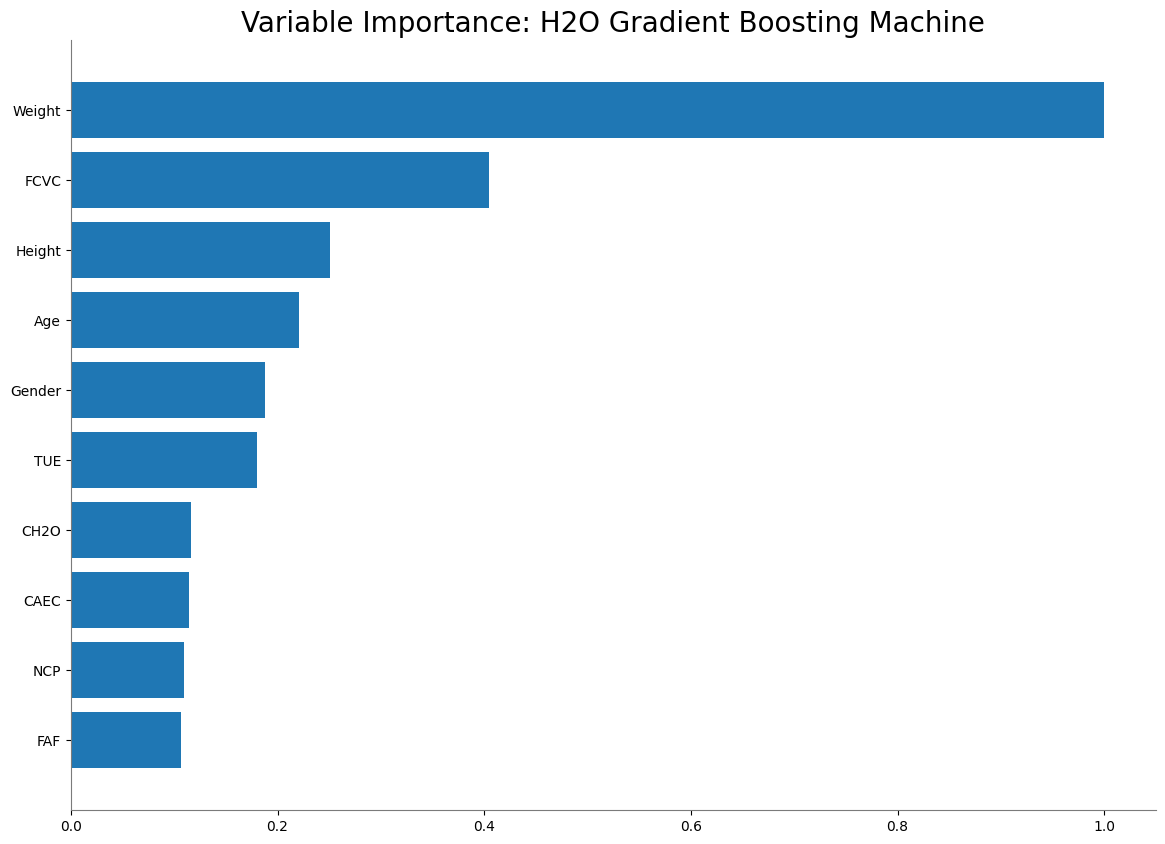

<Figure size 640x480 with 0 Axes>

In [ ]:
aml.leader.varimp_plot()
#variance importance plot for the leader model.

# 4. Performing SHAP Analysis on the H2O AutoML model

In [ ]:
pip install shap

# Leaderboard

> Leaderboard shows models with their metrics. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id                              mean_per_class_error    logloss      rmse        mse    training_time_ms    predict_time_per_row_ms  algo
----------------------------------  ----------------------  ---------  --------  ---------  ------------------  -------------------------  -------
GBM_5_AutoML_1_20240316_211729                   0.0337235   0.153458  0.168079  0.0282505                6506                   0.538682  GBM
GBM_2_AutoML_1_20240316_211729                   0.0342502   0.154329  0.172066  0.0296069                7446                   0.869465  GBM
XGBoost_3_AutoML_1_20240316_211729               0.0354173   0.130811  0.182803  0.0334171                3067                   0.090013  XGBoost
GBM_1_AutoML_1_20240316_211729                   0.0376917   0.123822  0.18259   0.0333392               11057                   0.72843   GBM
GBM_4_AutoML_1_20240316_211729                   0.0396123   0.142359  0.176508  0.0311551                5238                   0.637842  GBM
GBM_3_AutoML_1_20240316_211729                   0.0424134   0.155275  0.180747  0.0326695                7739                   0.667535  GBM
XGBoost_2_AutoML_1_20240316_211729               0.043294    0.147078  0.197501  0.0390066                3111                   0.123268  XGBoost
XGBoost_1_AutoML_1_20240316_211729               0.0534395   0.197048  0.232449  0.0540325                7326                   0.050283  XGBoost
XRT_1_AutoML_1_20240316_211729                   0.0569405   0.324956  0.30551   0.0933366                6329                   0.293457  DRF
DRF_1_AutoML_1_20240316_211729                   0.0676183   0.263228  0.281918  0.0794777                5180                   0.227003  DRF
[10 rows x 8 columns]

# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## GBM_3_AutoML_1_20240316_211729

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
Insufficient_Weight    Normal_Weight    Obesity_Type_I    Obesity_Type_II    Obesity_Type_III    Overweight_Level_I    Overweight_Level_II    Error      Rate
---------------------  ---------------  ----------------  -----------------  ------------------  --------------------  ---------------------  ---------  --------
30                     1                0                 0                  0                   0                     0                      0.0322581  1 / 31
1                      46               0                 0                  0                   3                     1                      0.0980392  5 / 51
0                      0                46                0                  0                   0                     2                      0.0416667  2 / 48
0                      0                1                 49                 1                   0                     0                      0.0392157  2 / 51
0                      0                0                 0                  58                  0                     0                      0          0 / 58
0                      3                0                 0                  0                   32                    0                      0.0857143  3 / 35
0                      0                0                 0                  0                   0                     36                     0          0 / 36
31                     50               47                49                 59                  35                    39                     0.0419355  13 / 310

# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

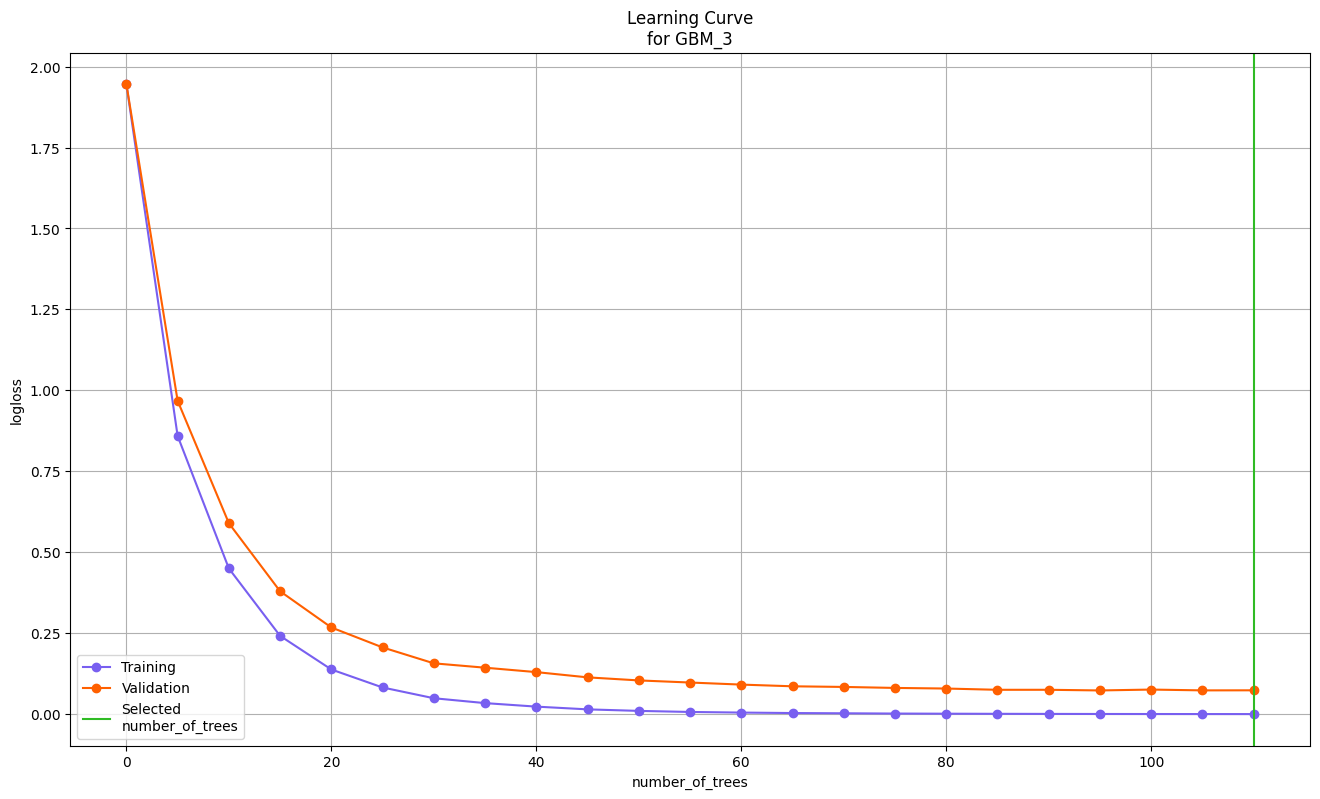

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

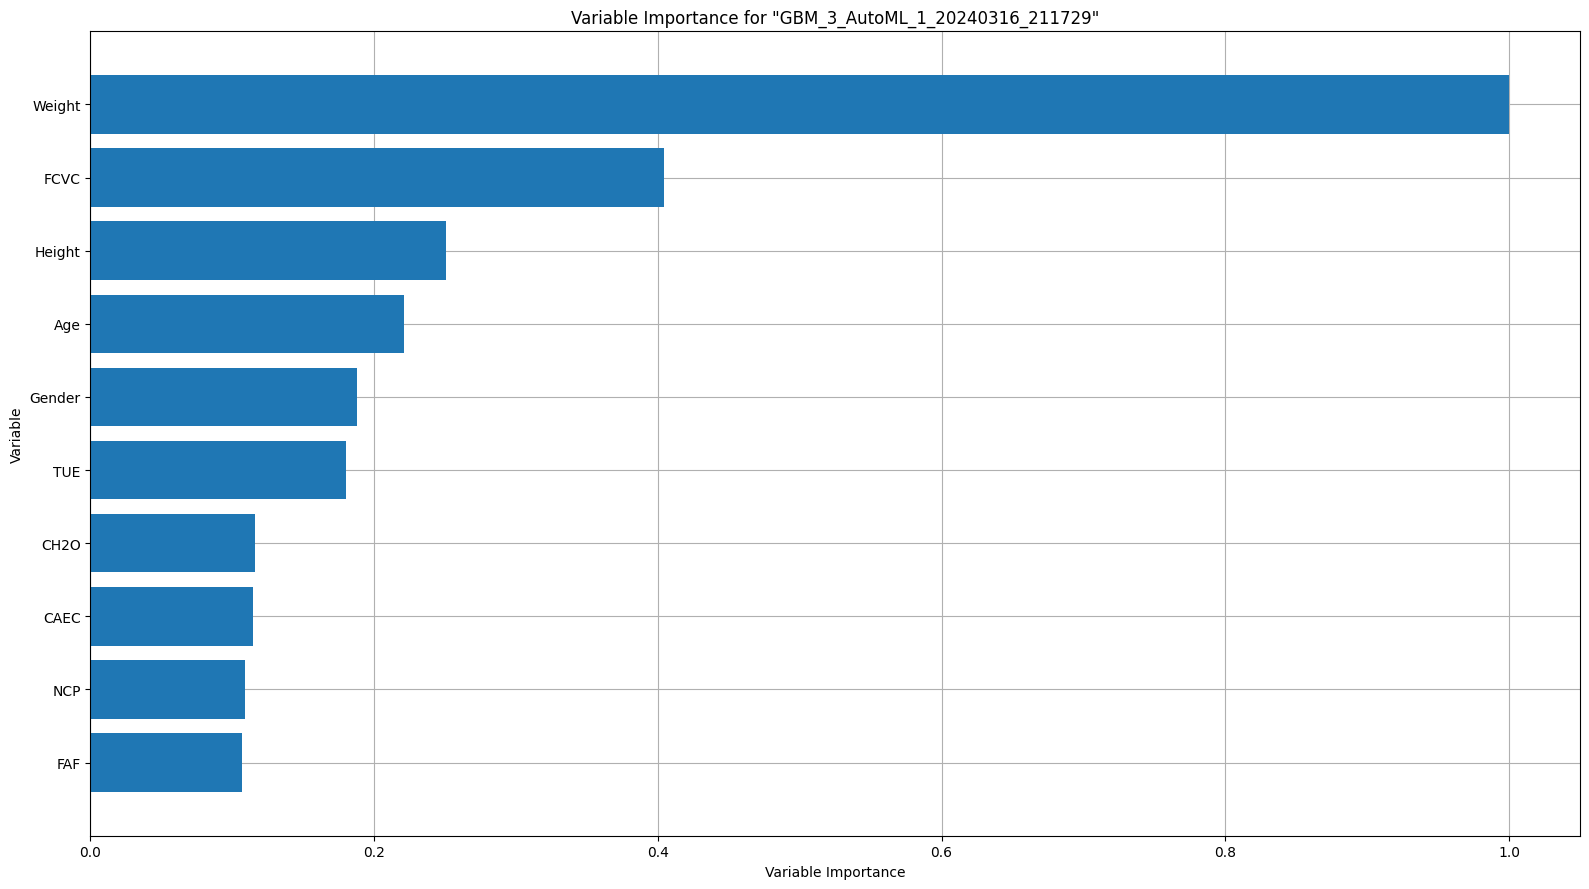

# Variable Importance Heatmap

> Variable importance heatmap shows variable importance across multiple models. Some models in H2O return variable importance for one-hot (binary indicator) encoded versions of categorical columns (e.g. Deep Learning, XGBoost). In order for the variable importance of categorical columns to be compared across all model types we compute a summarization of the the variable importance across all one-hot encoded features and return a single variable importance for the original categorical feature. By default, the models and variables are ordered by their similarity.

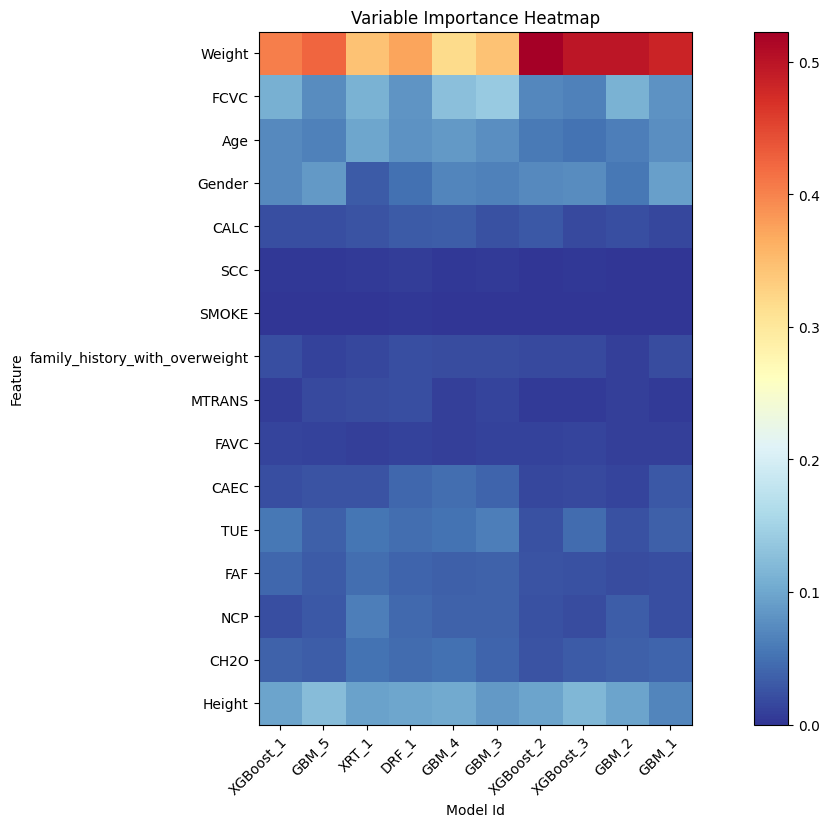

# Model Correlation

> This plot shows the correlation between the predictions of the models. For classification, frequency of identical predictions is used. By default, models are ordered by their similarity (as computed by hierarchical clustering). Interpretable models, such as GAM, GLM, and RuleFit are highlighted using red colored text.

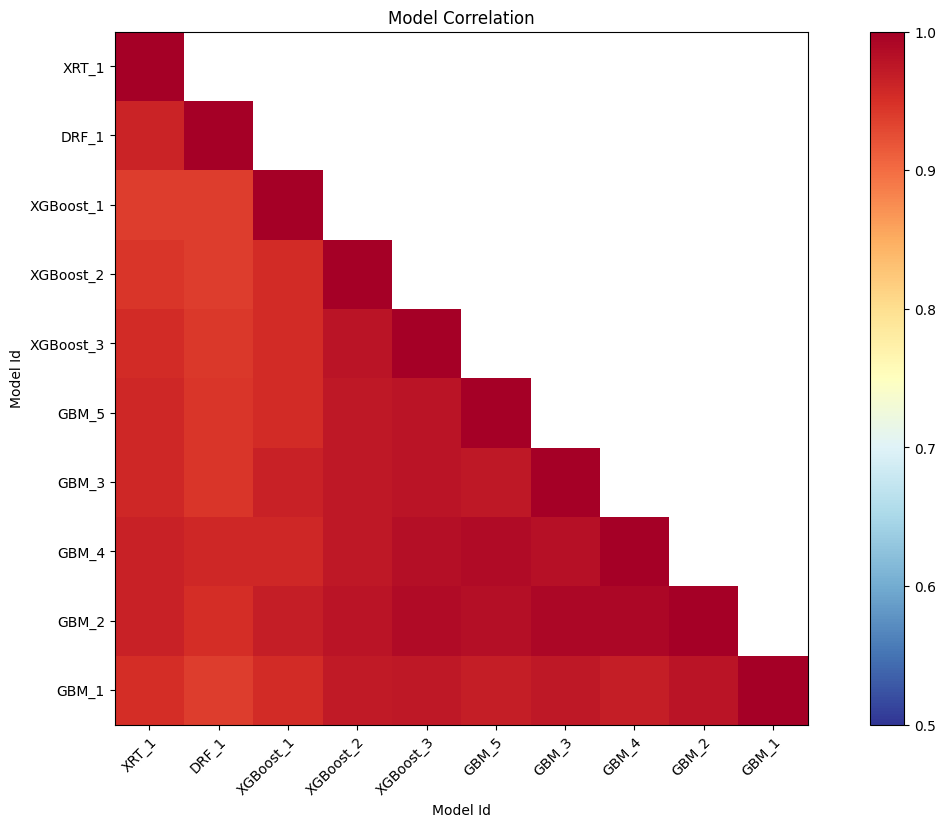

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

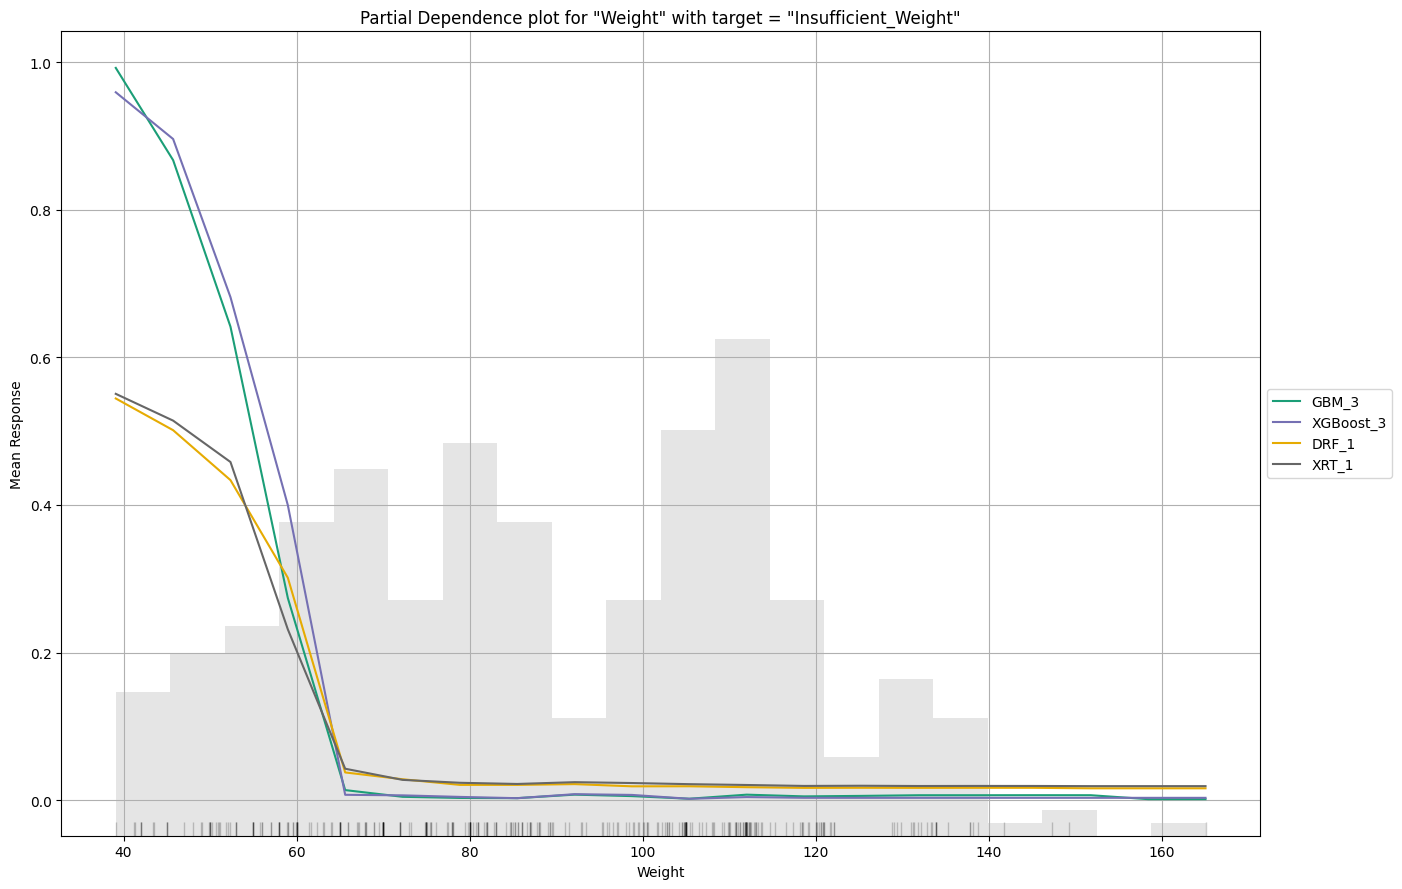

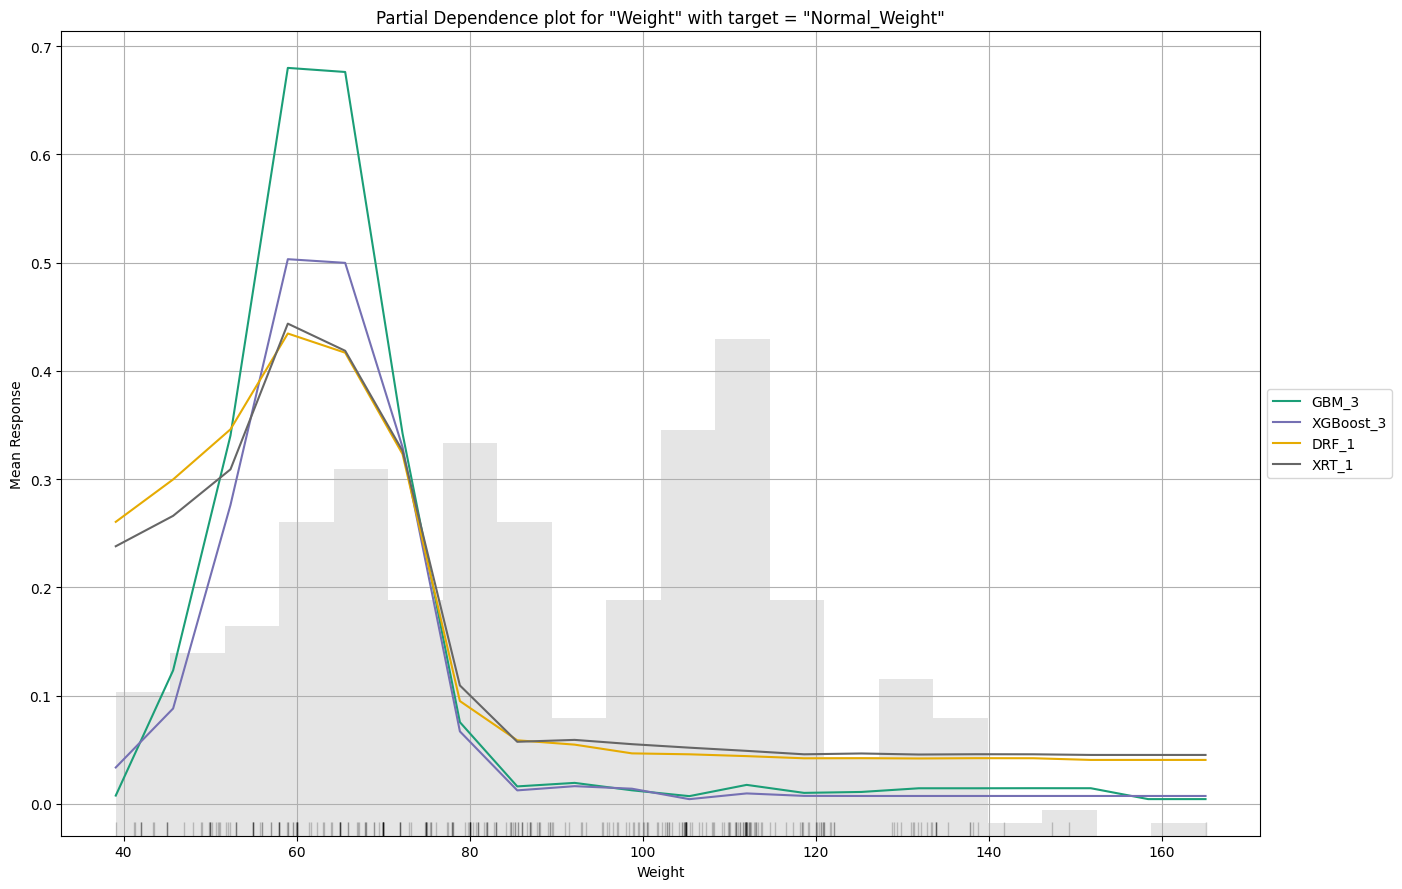

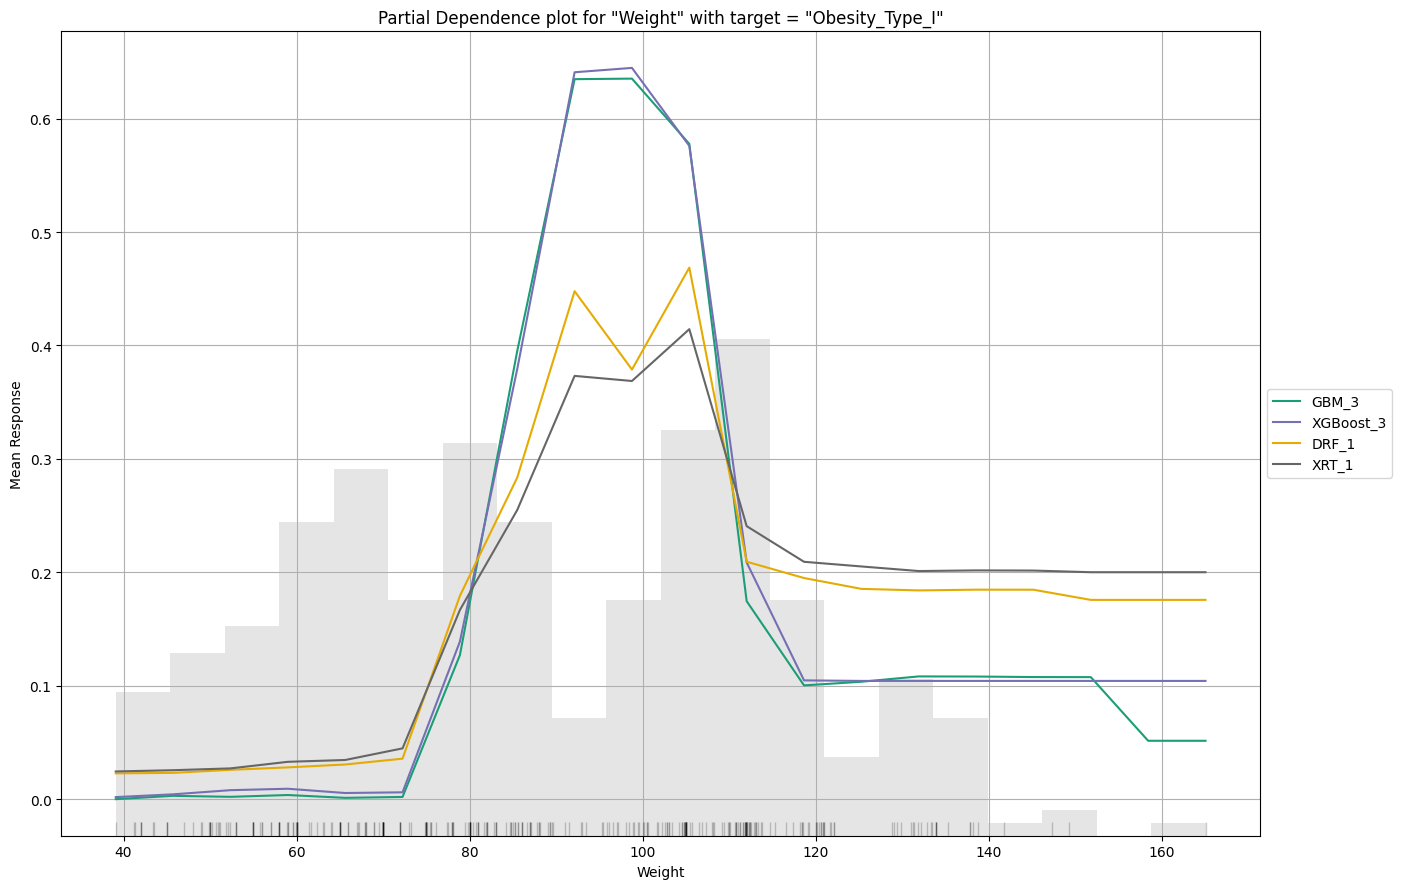

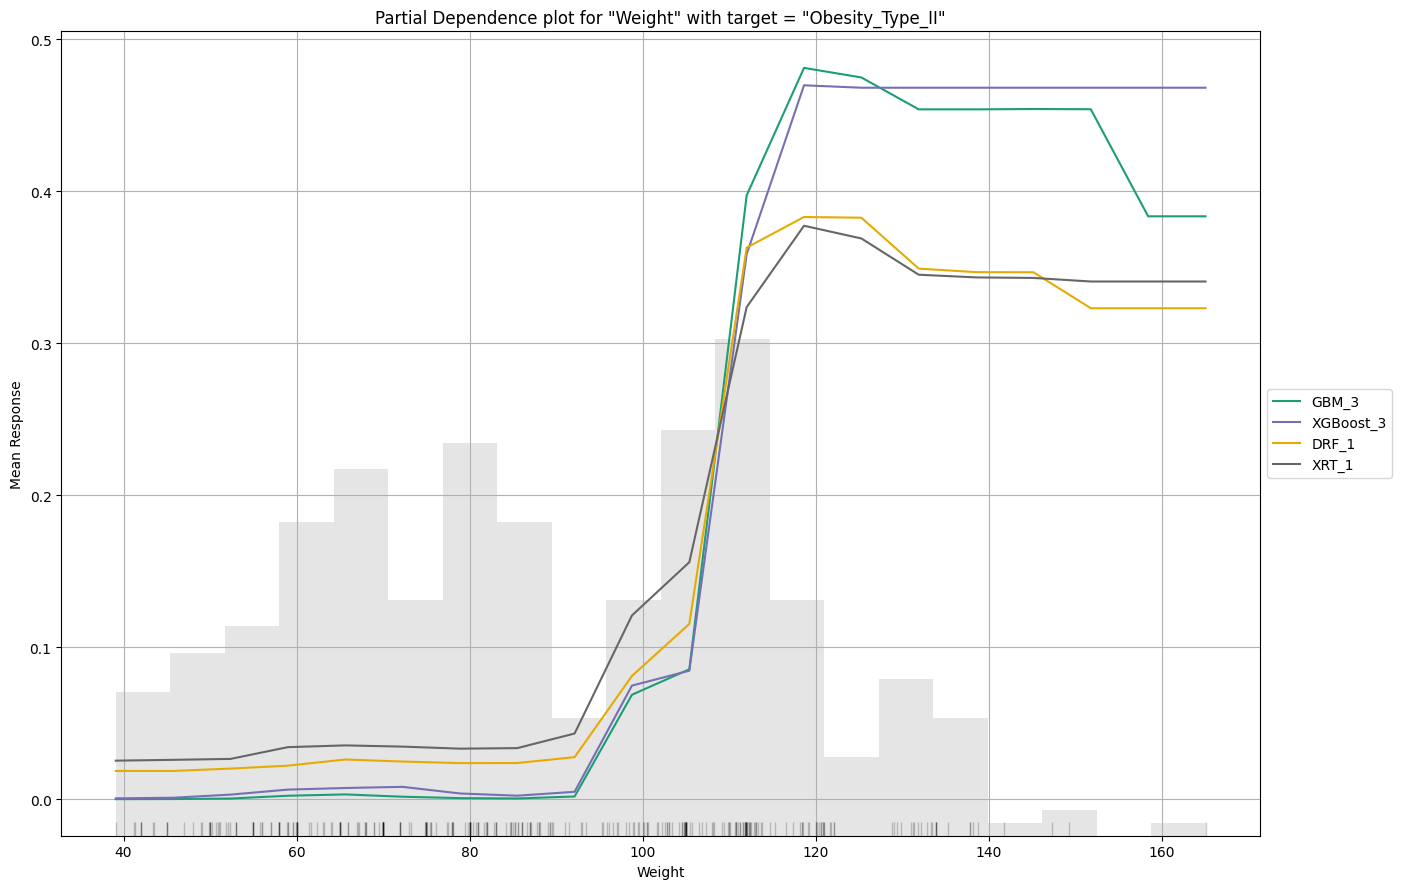

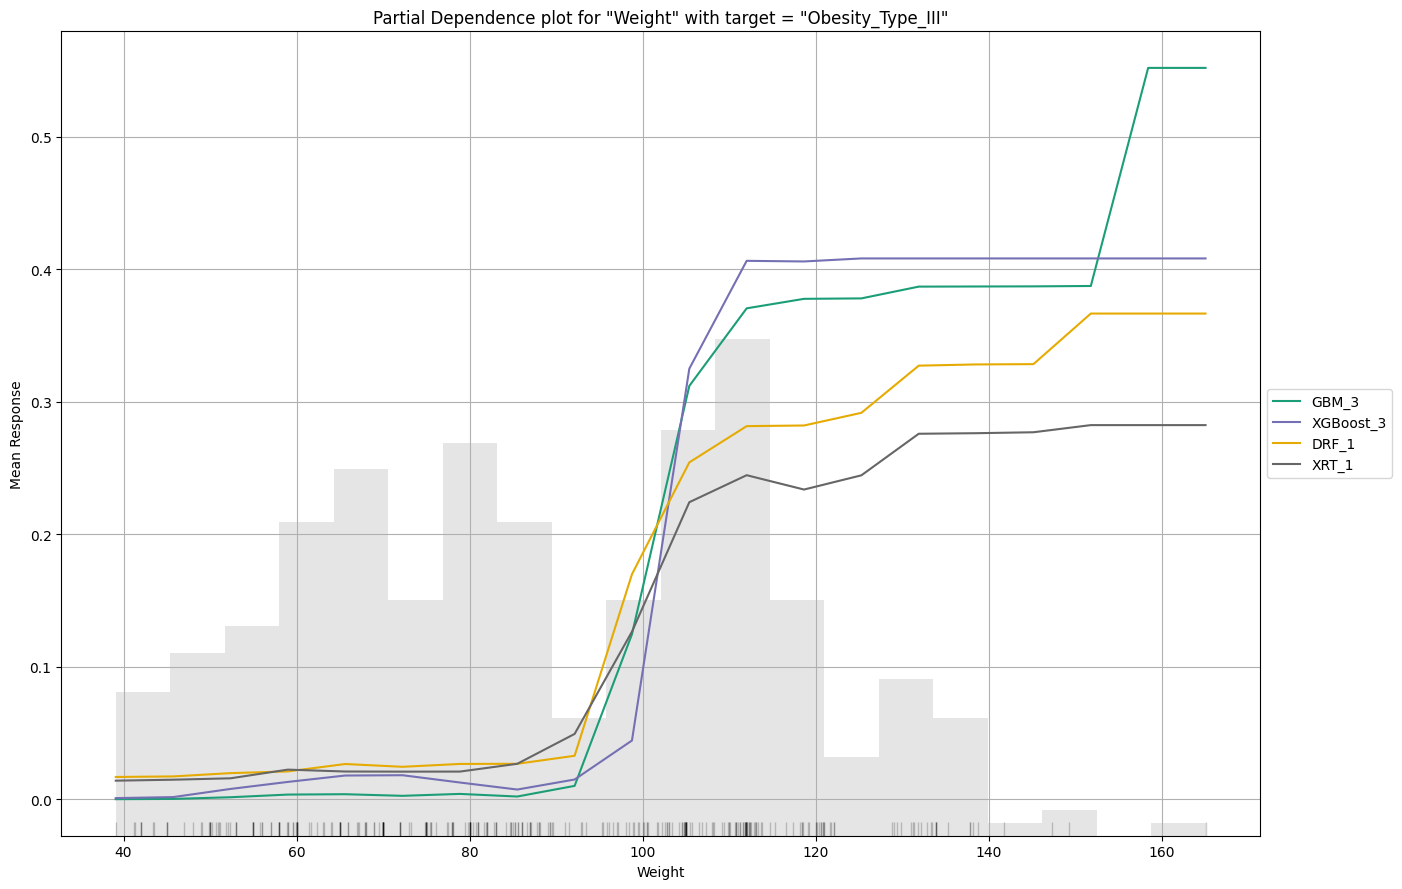

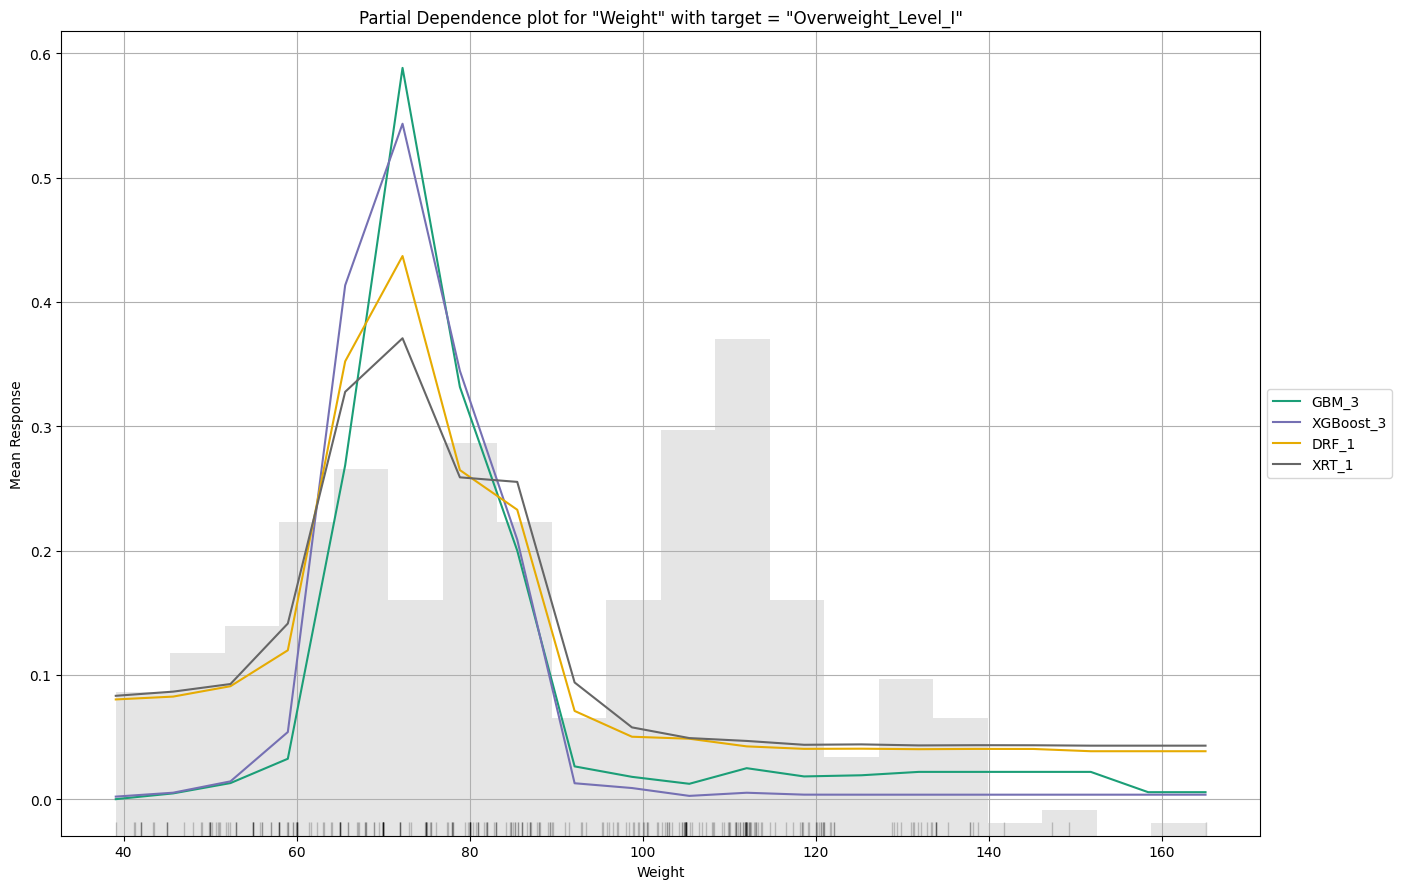

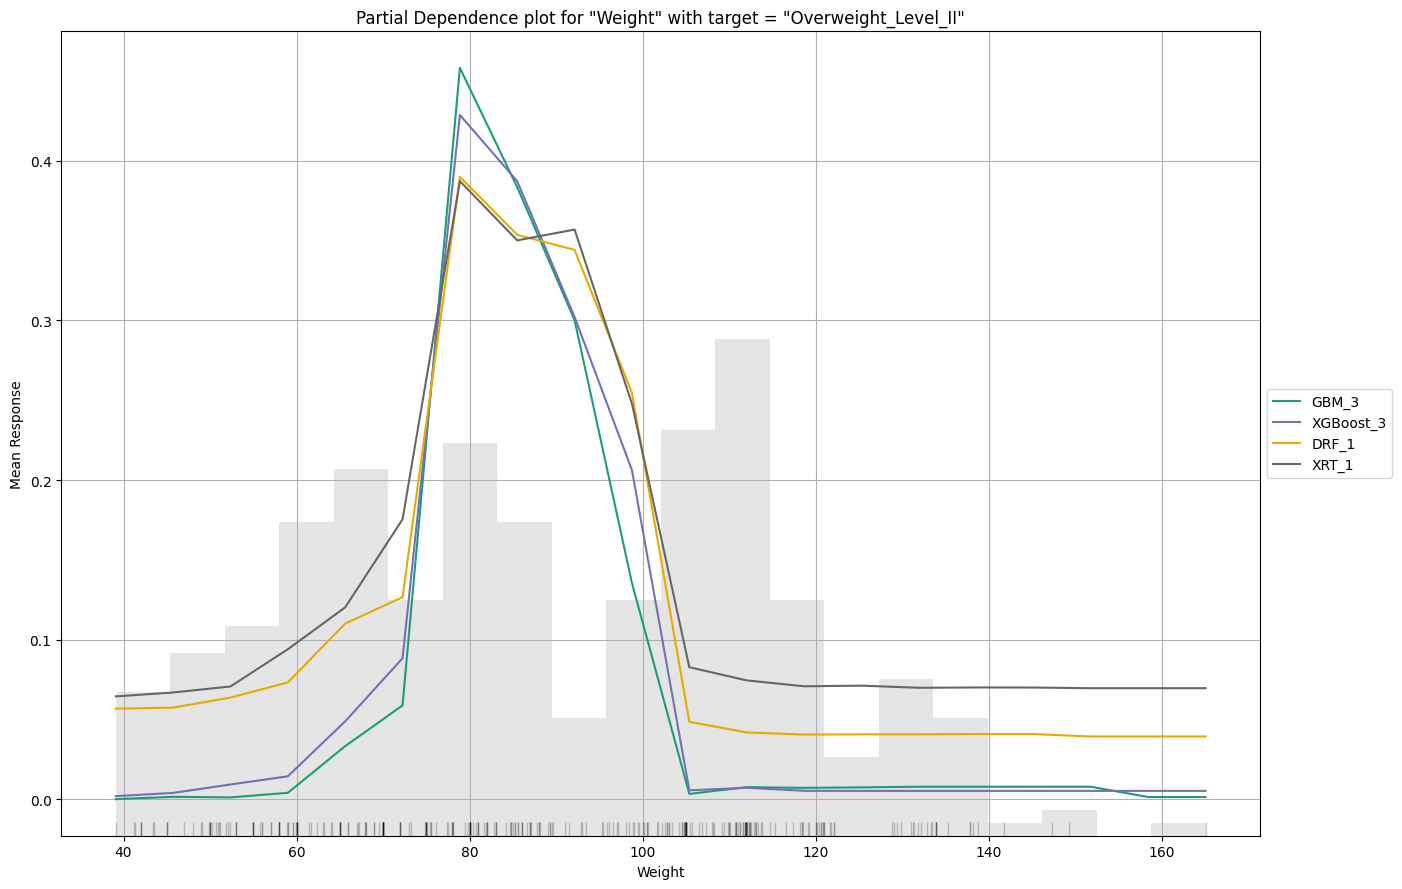

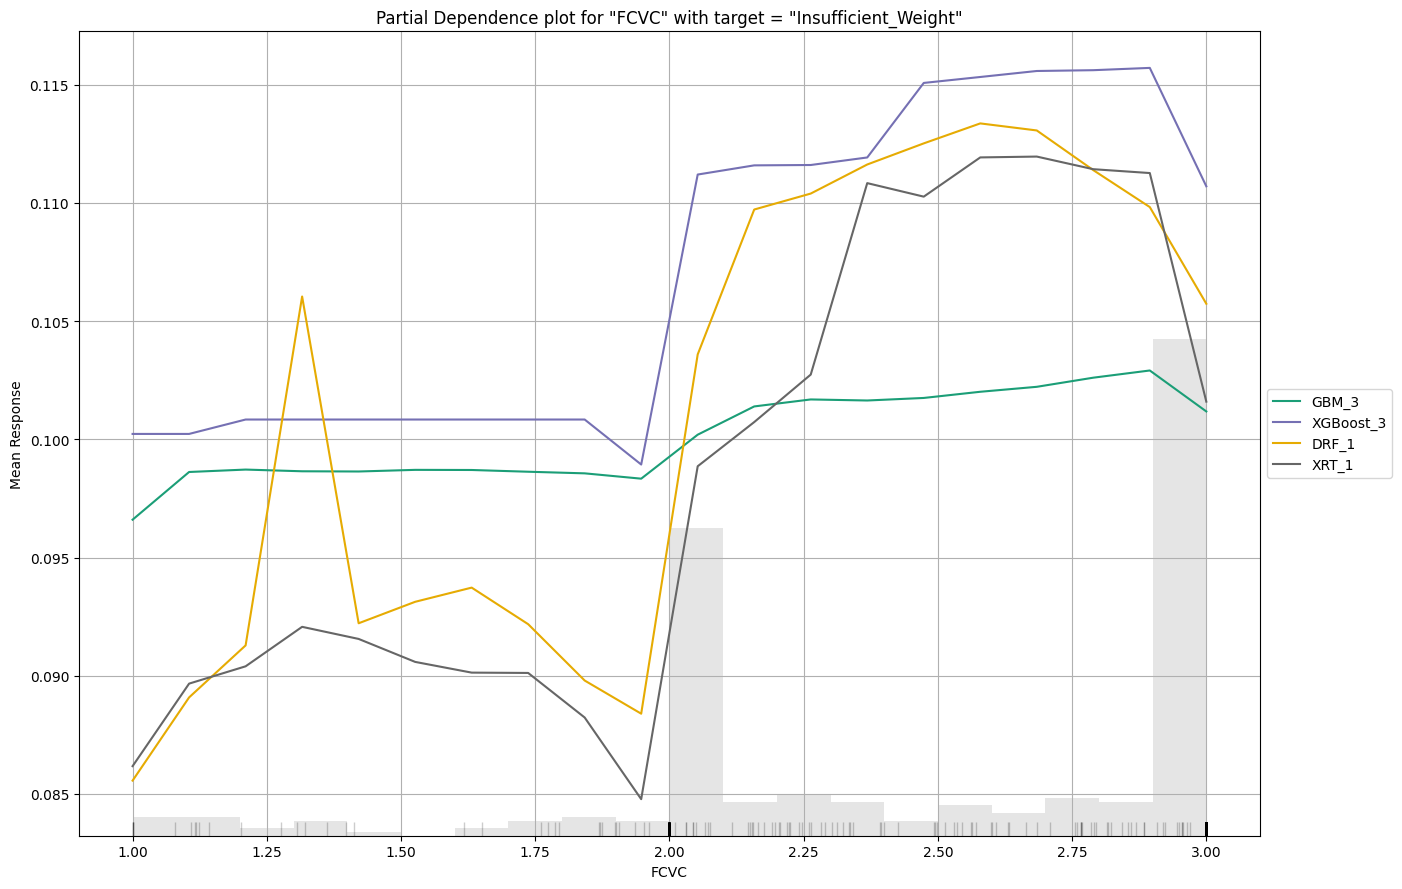

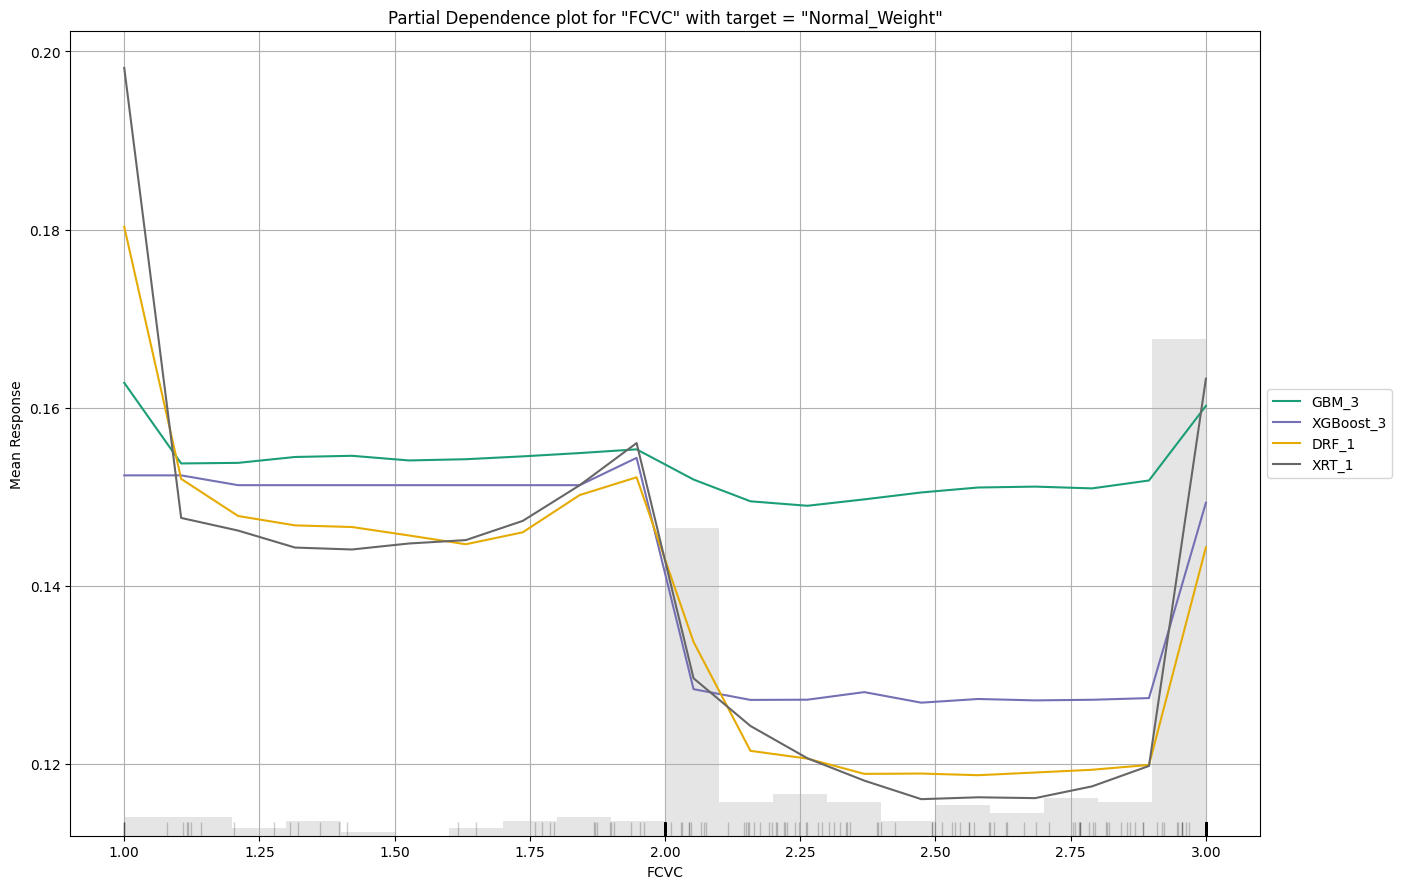

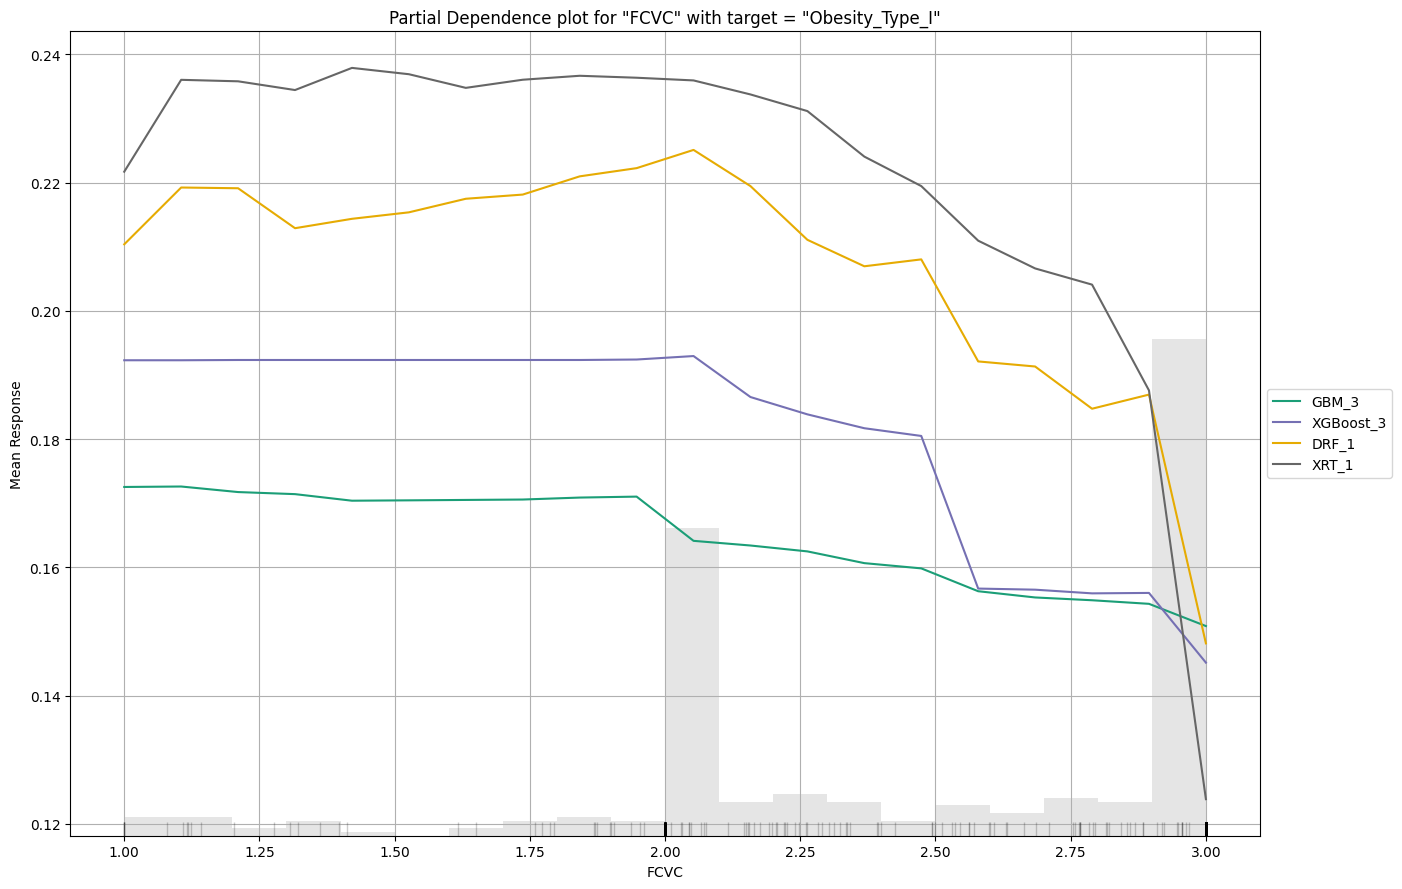

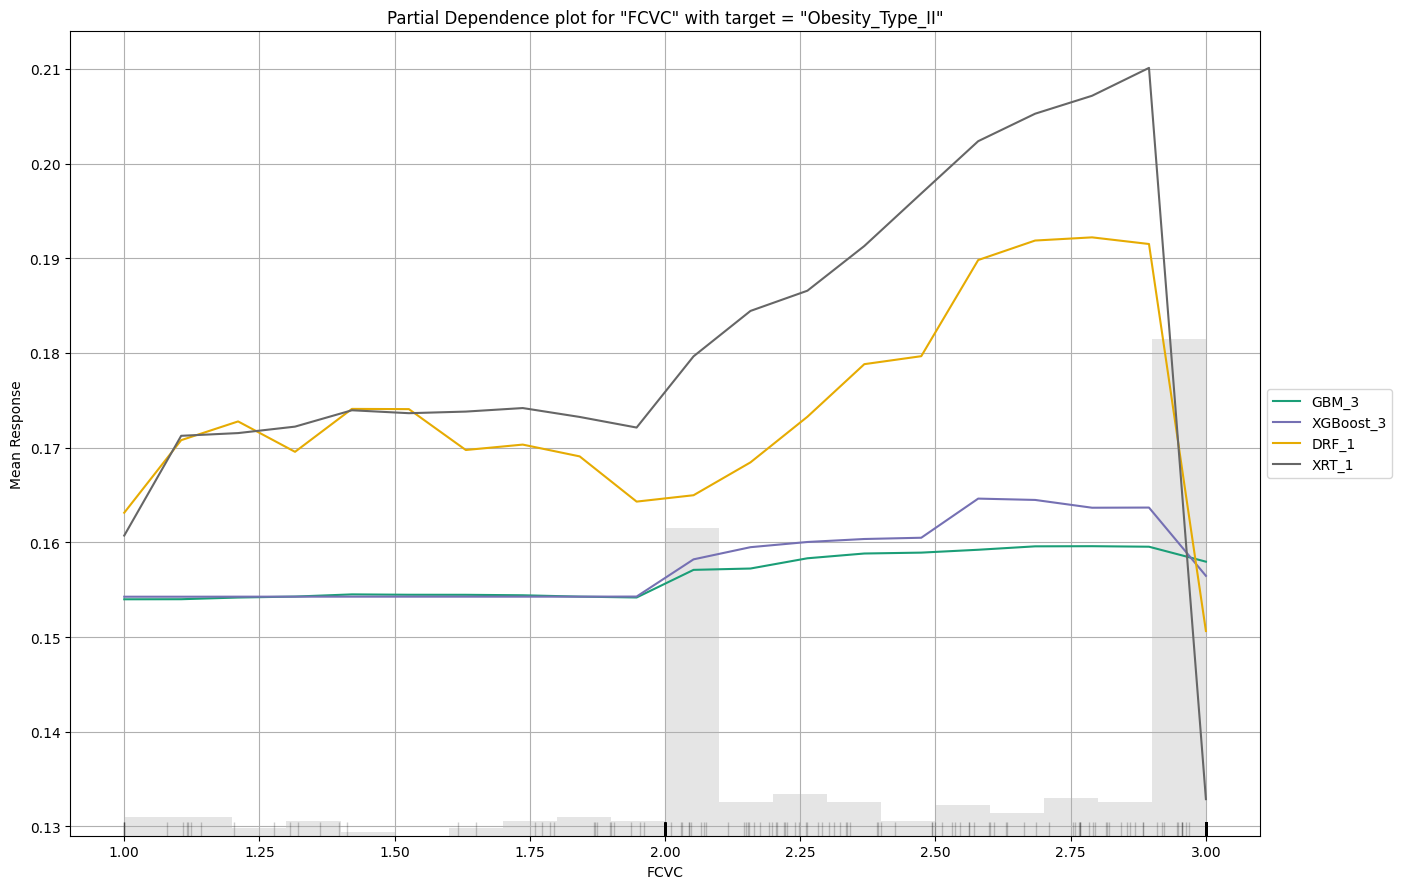

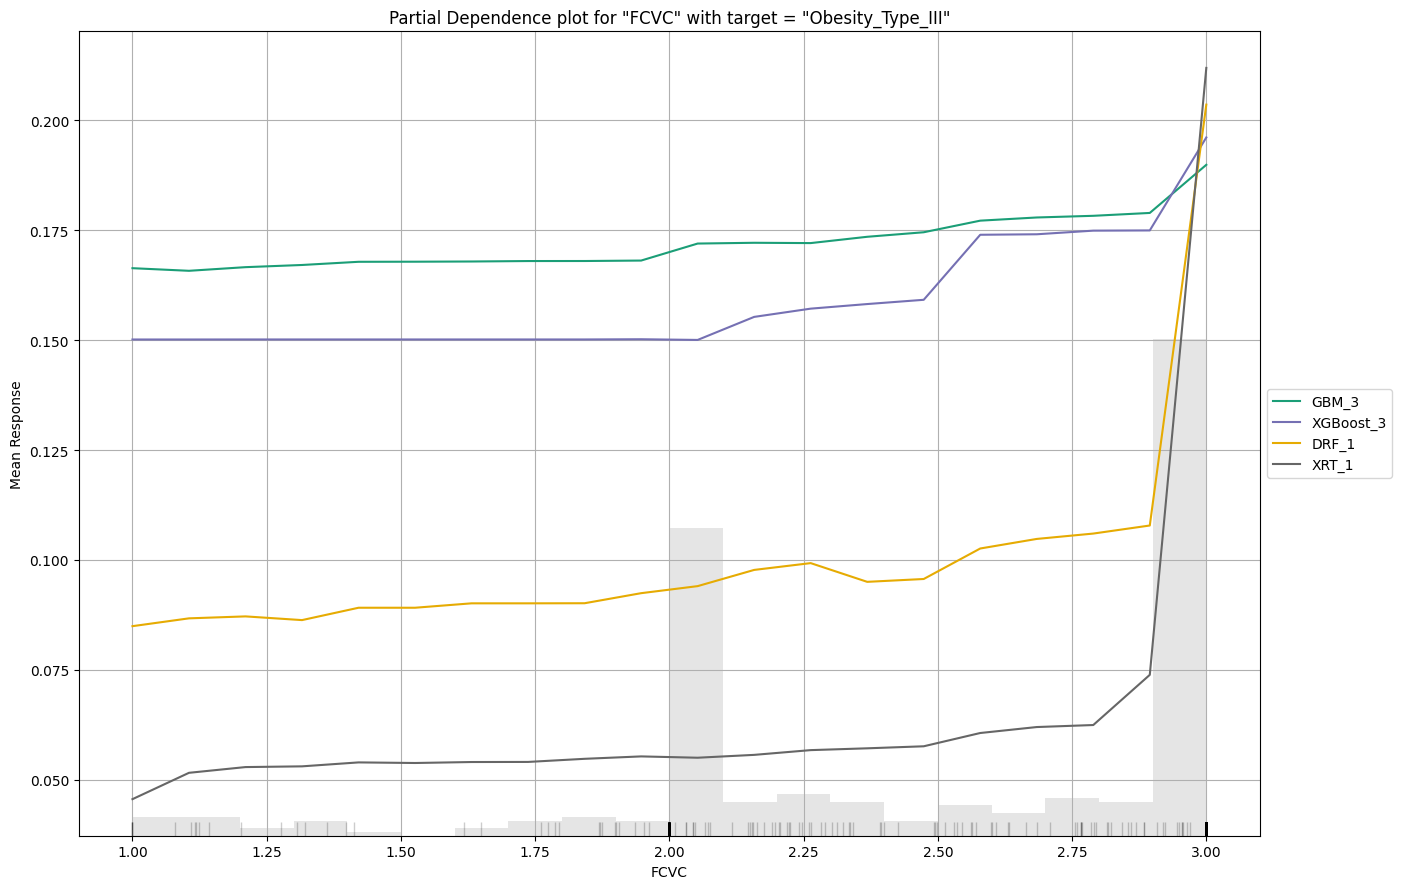

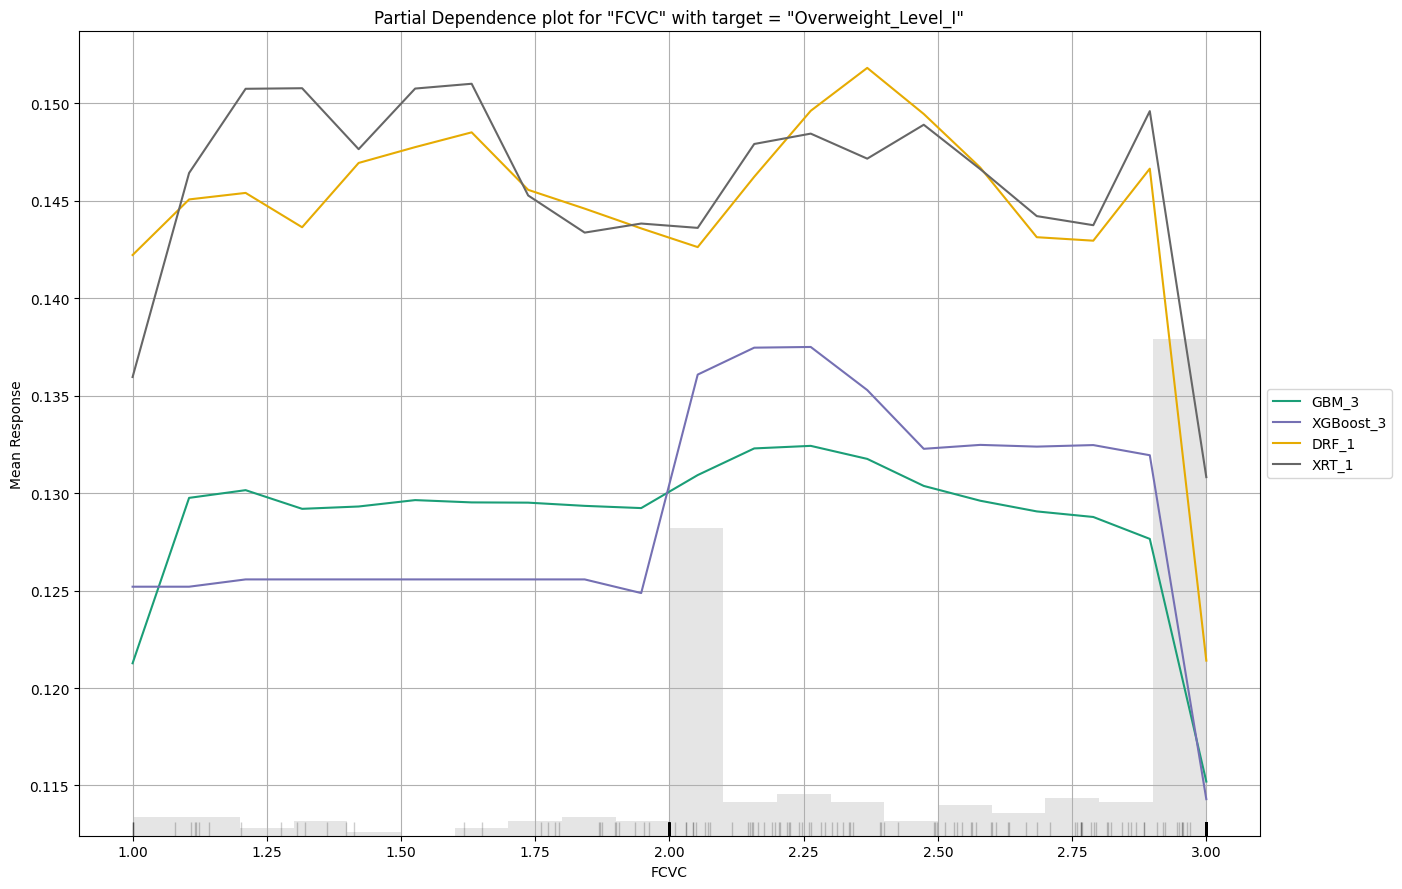

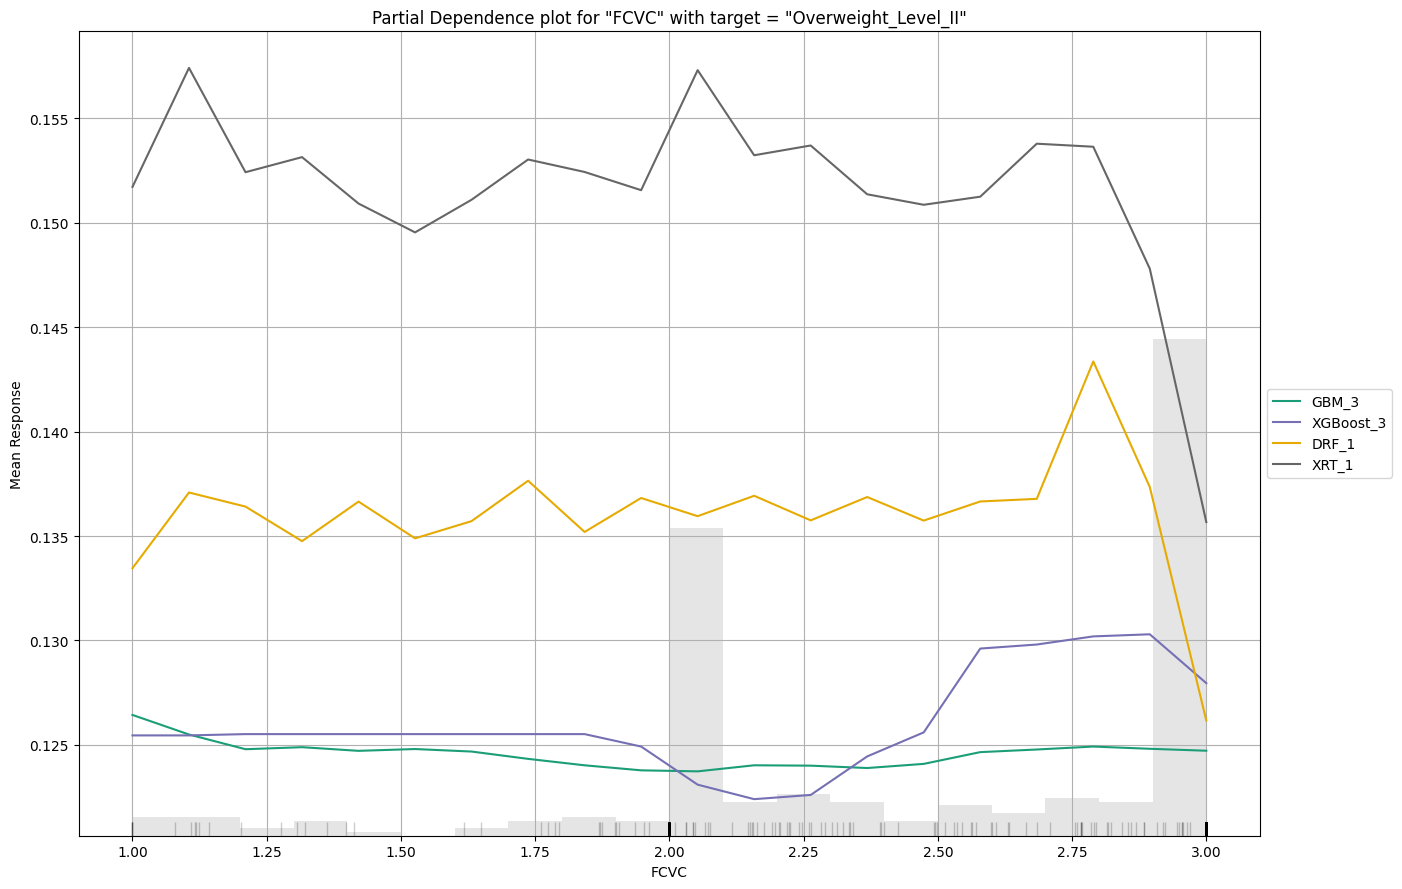

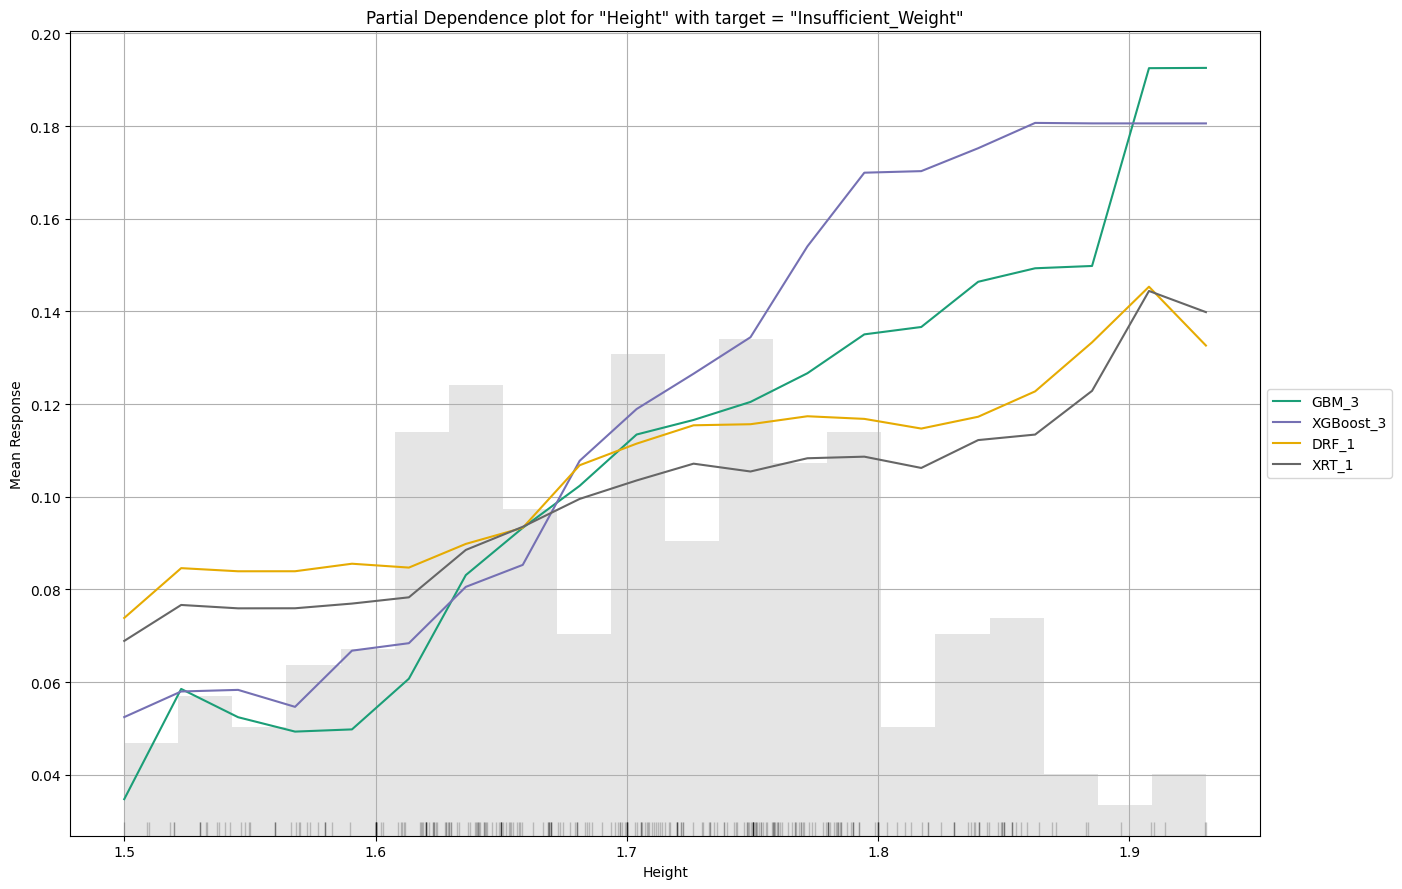

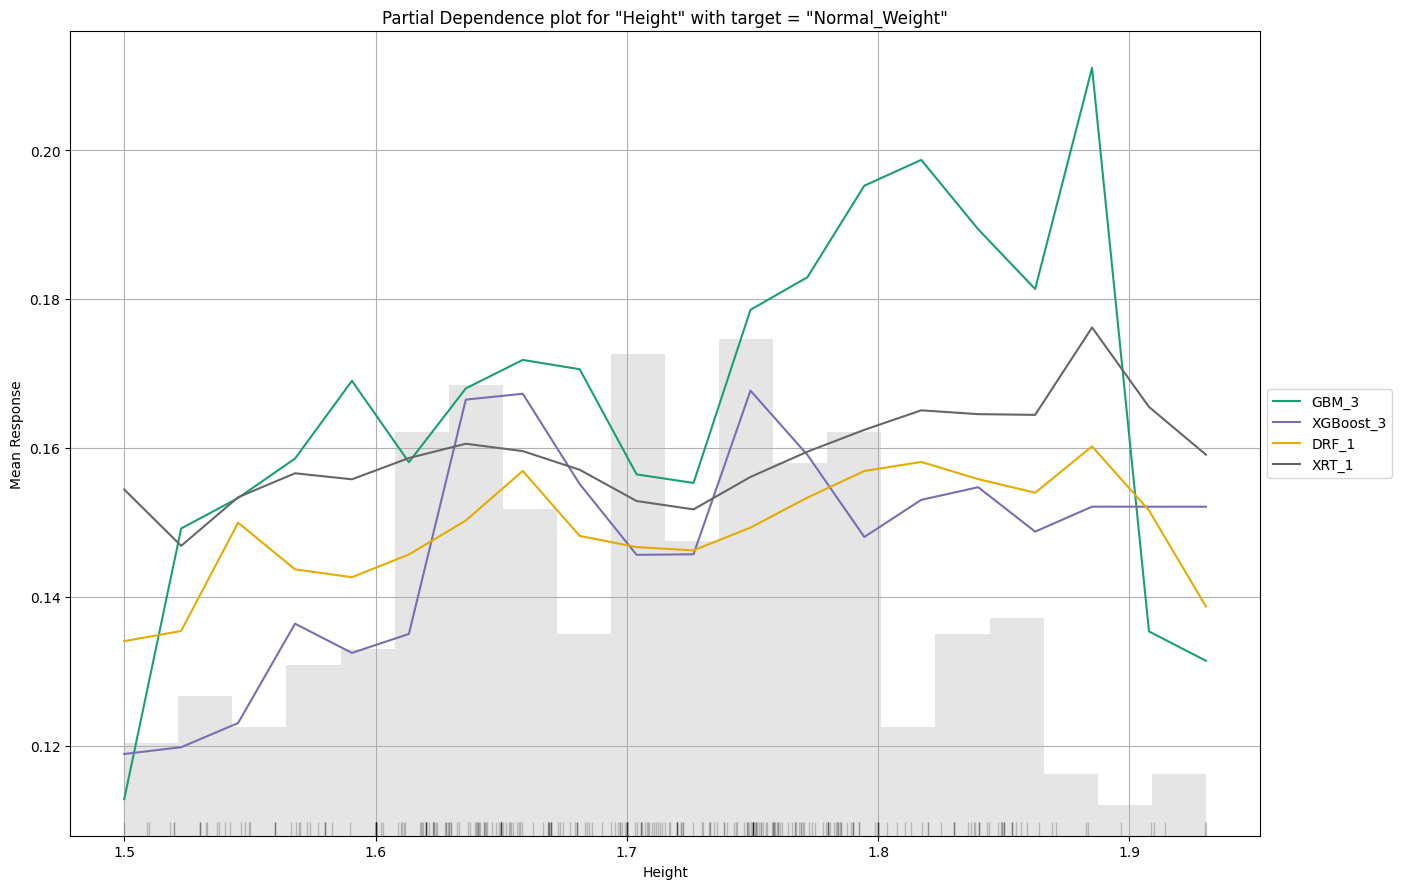

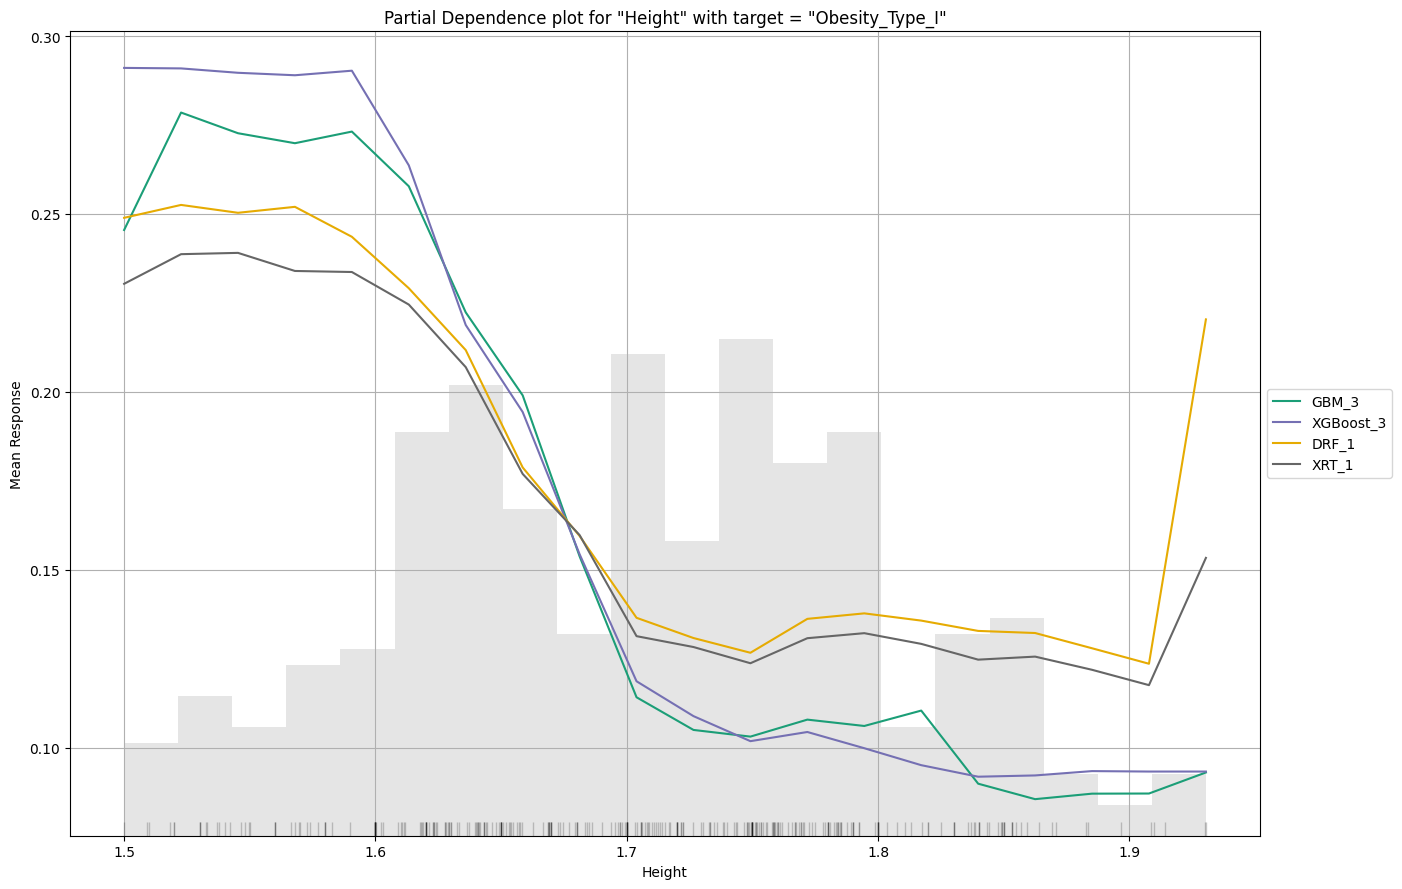

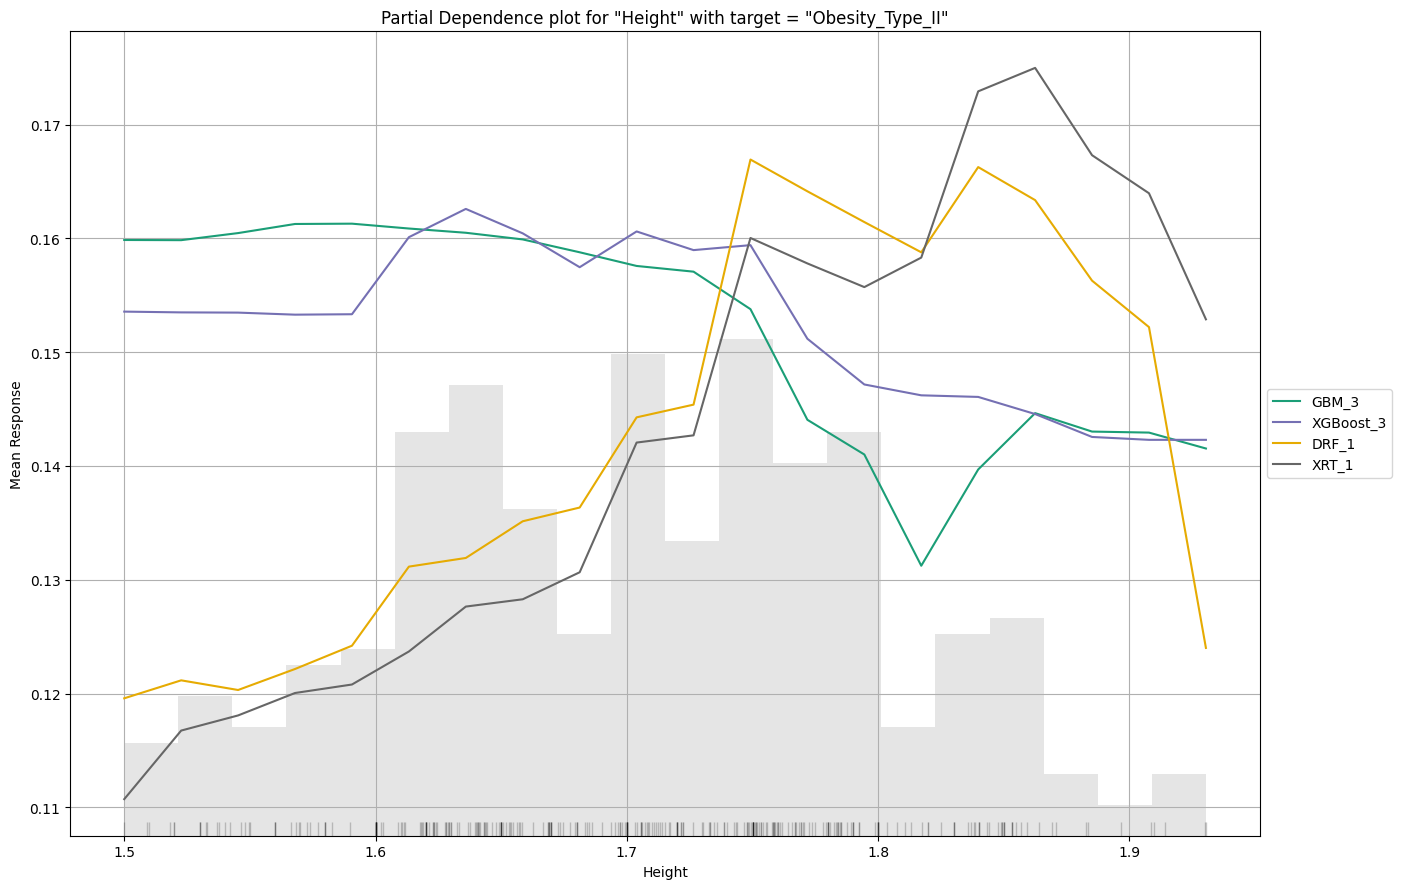

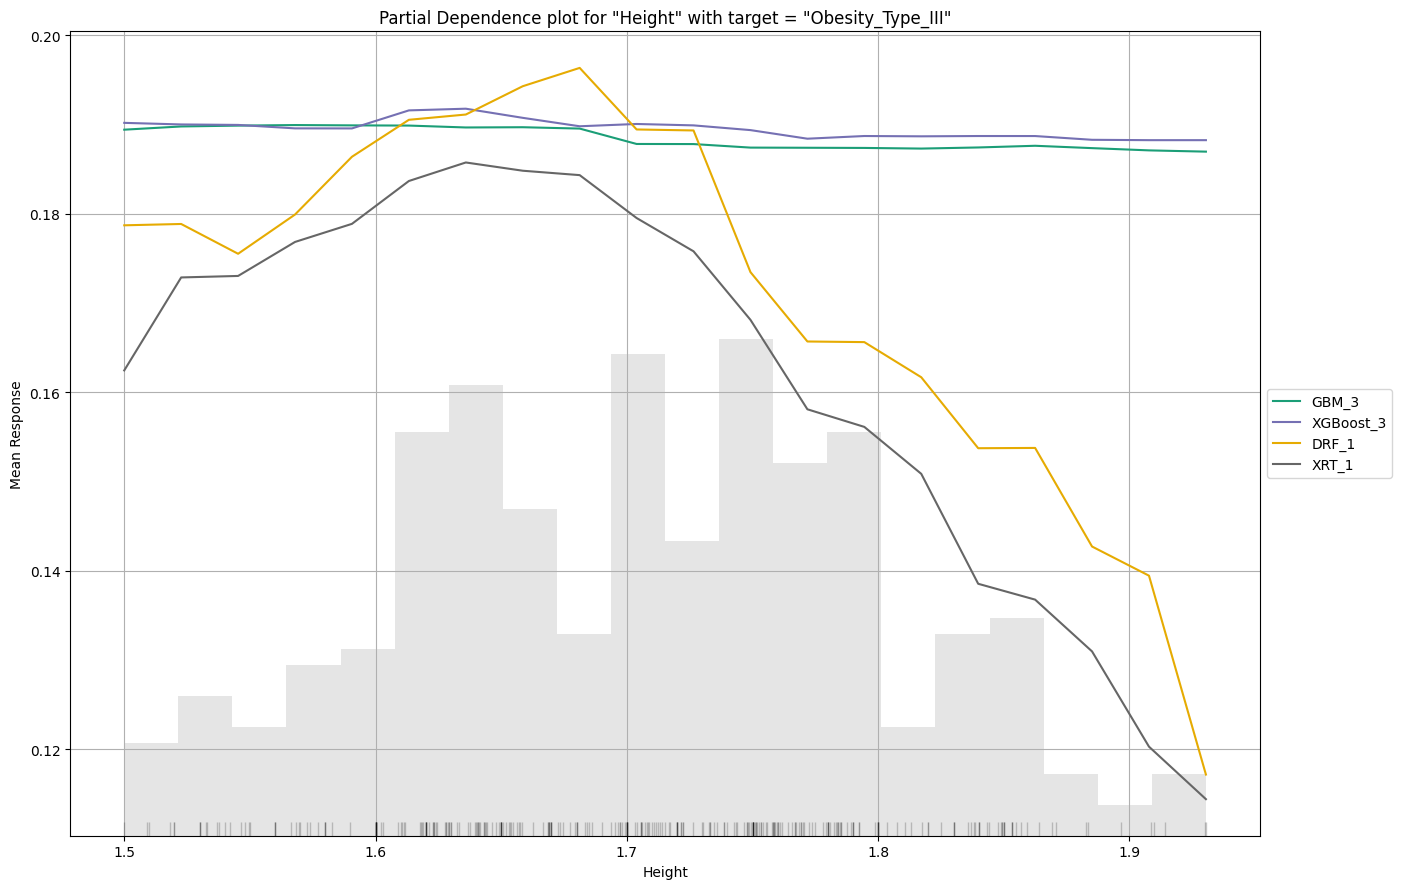

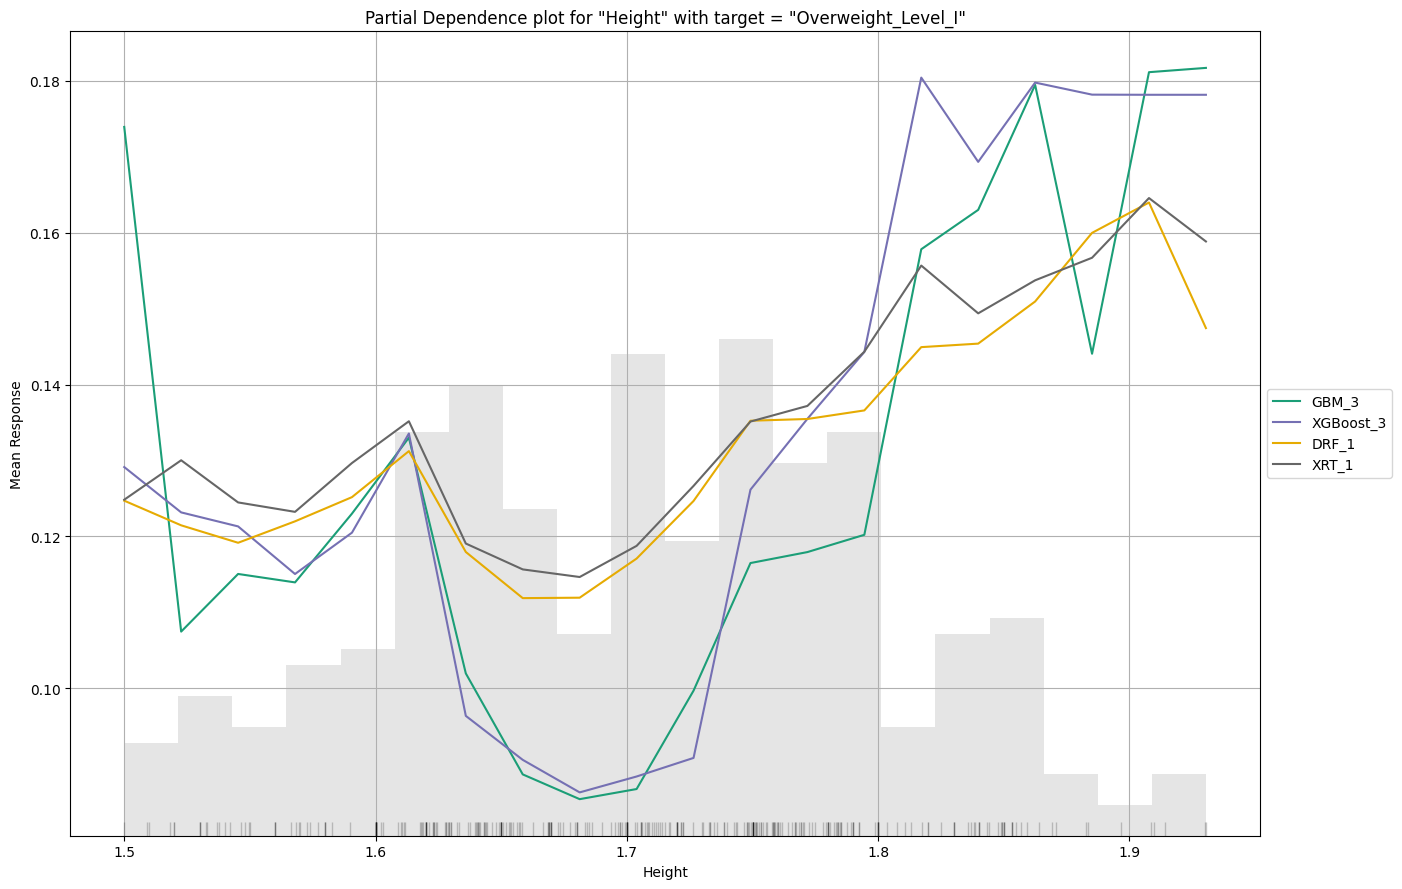

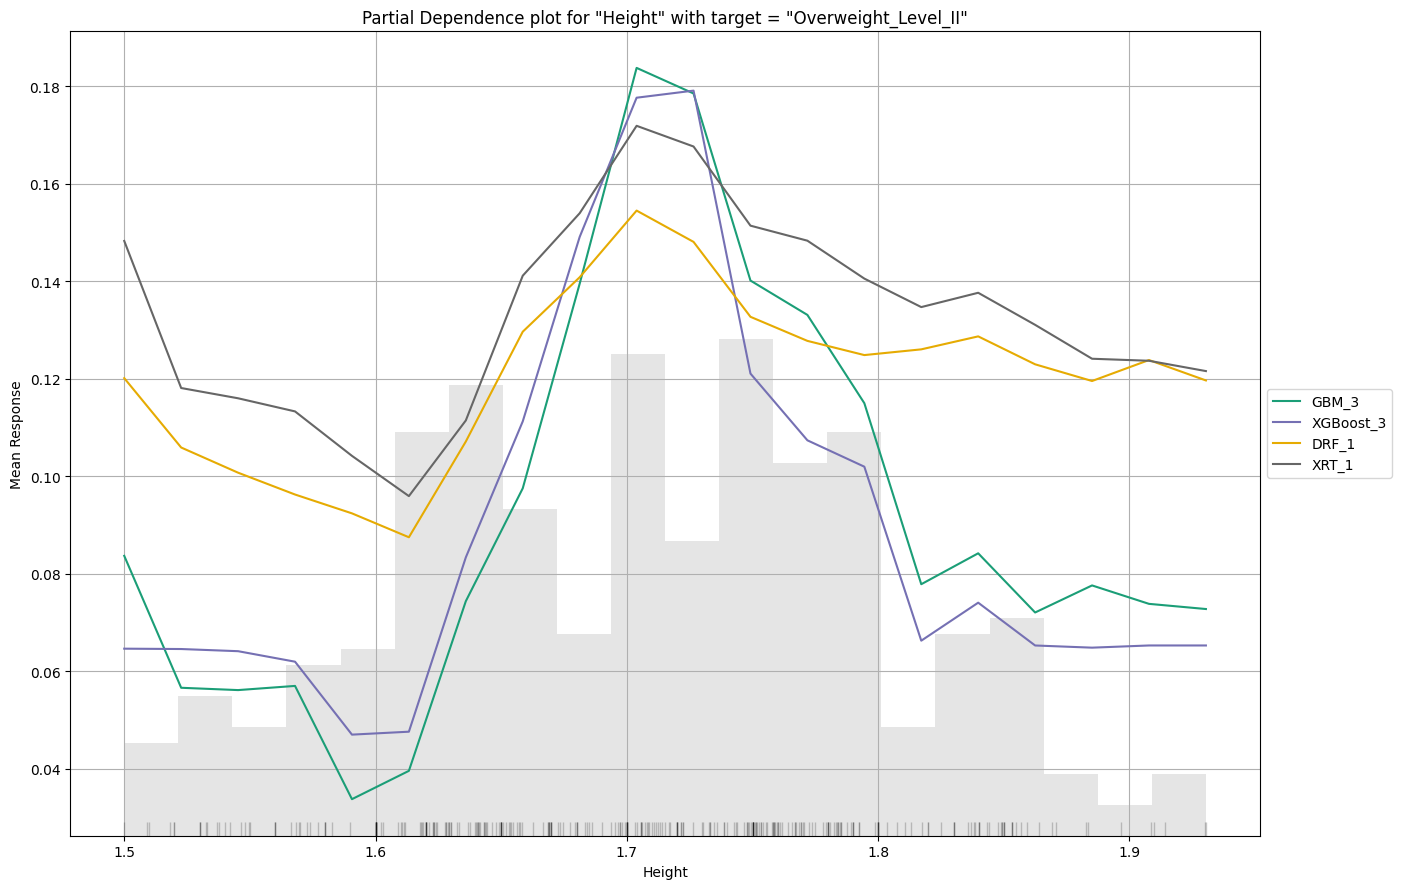

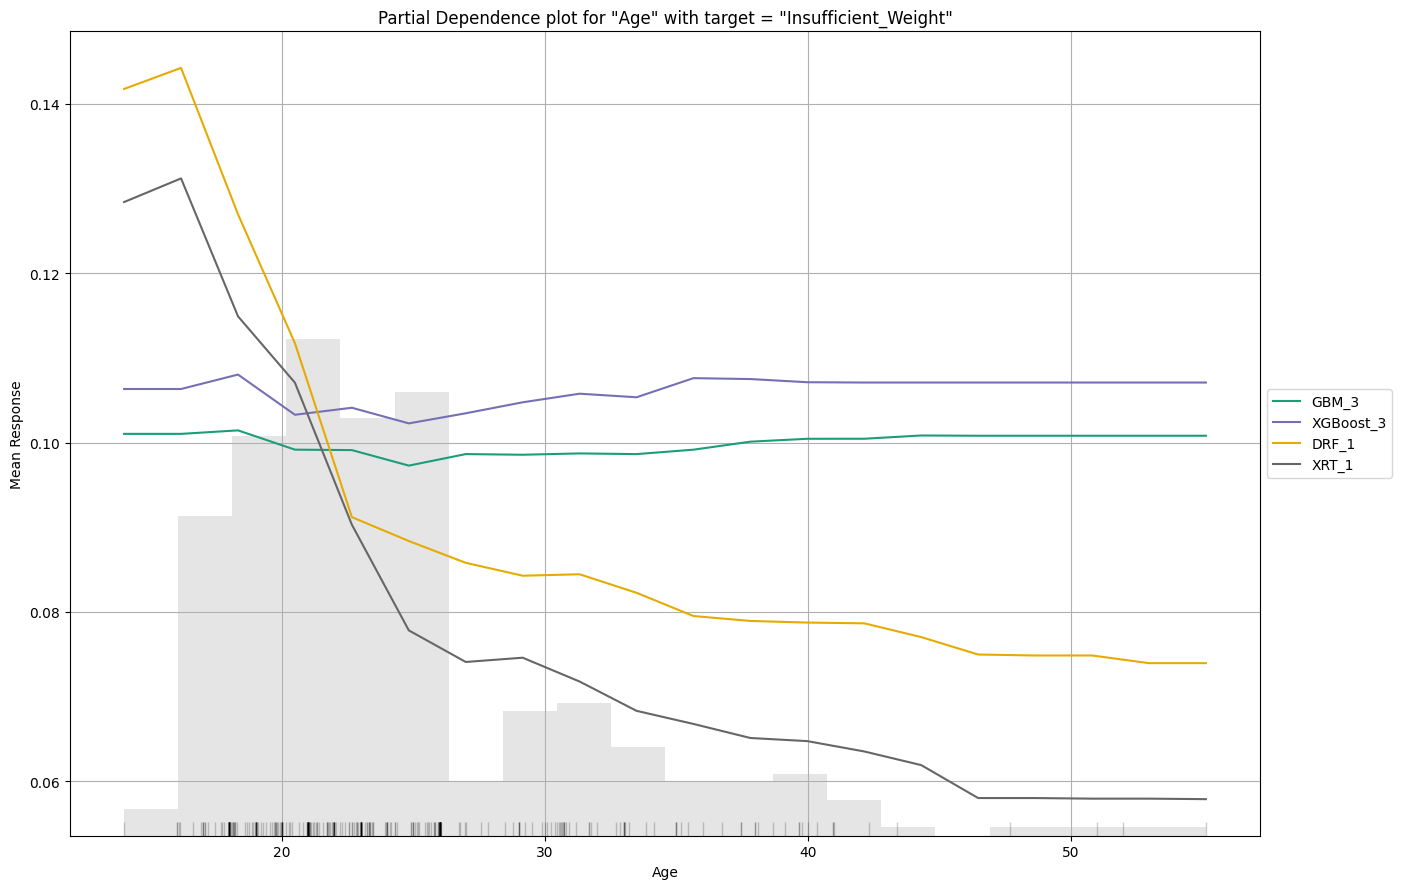

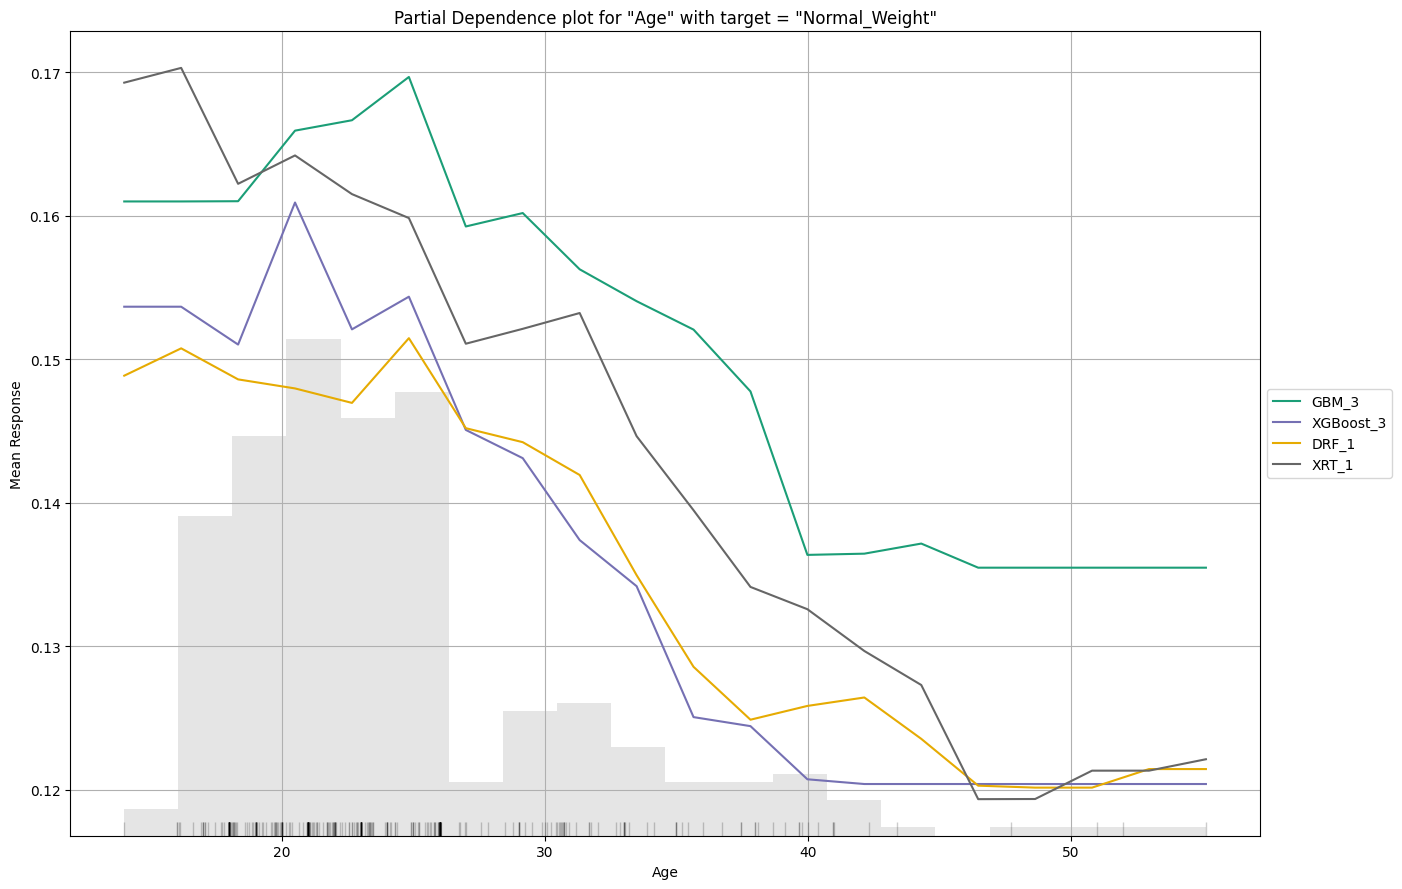

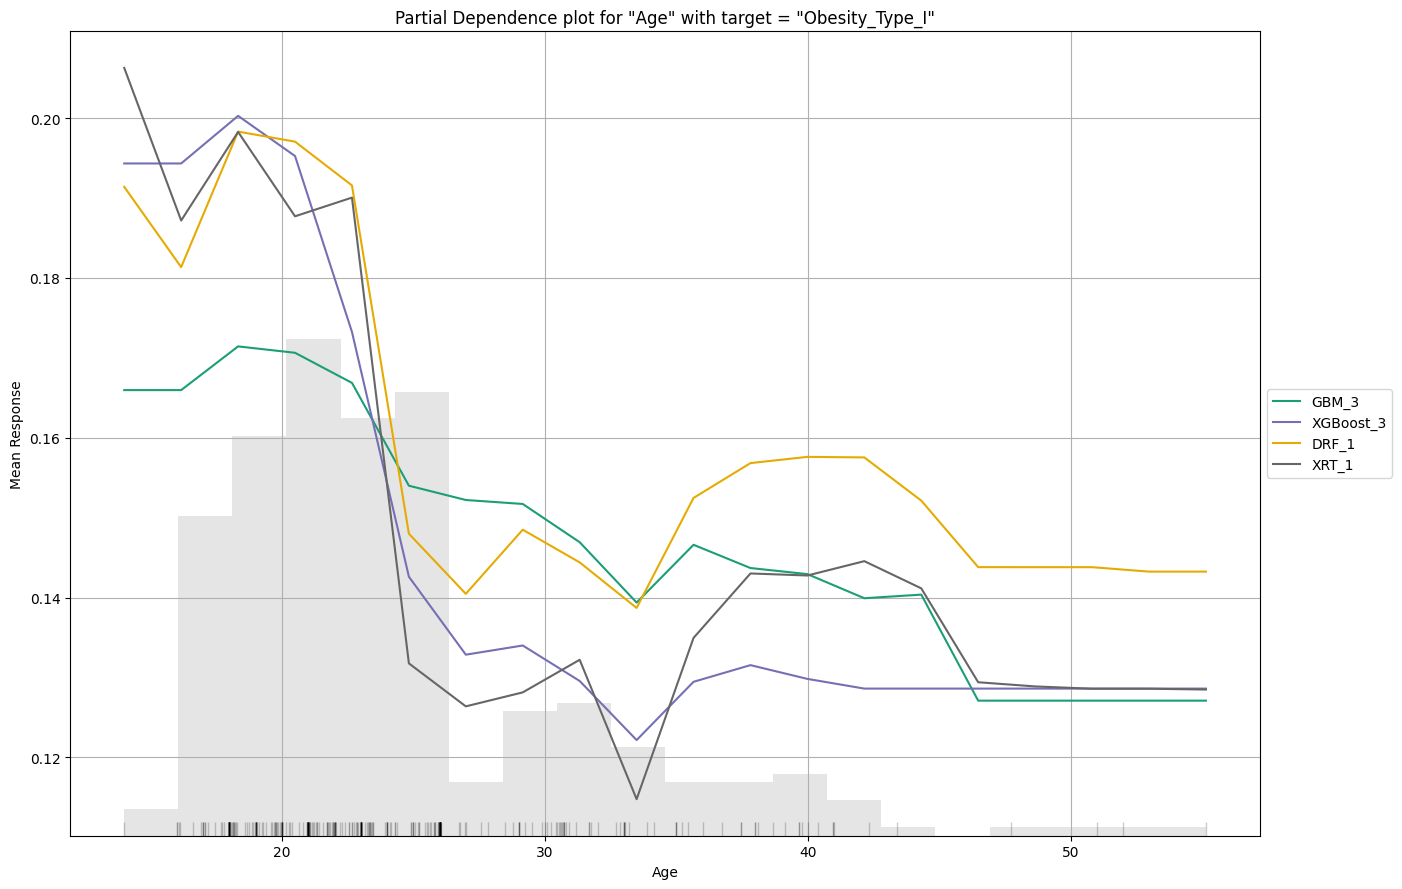

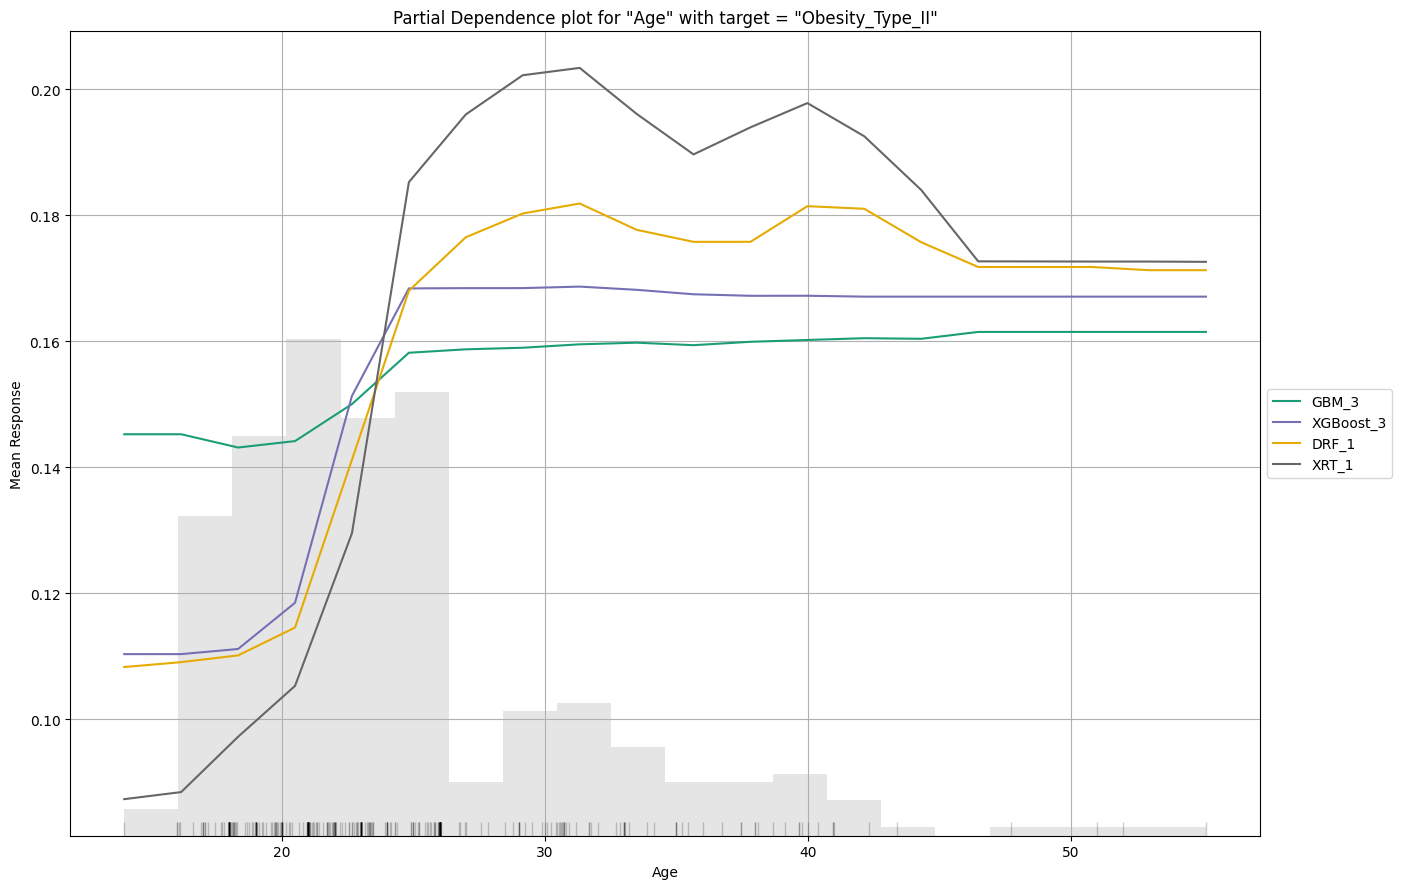

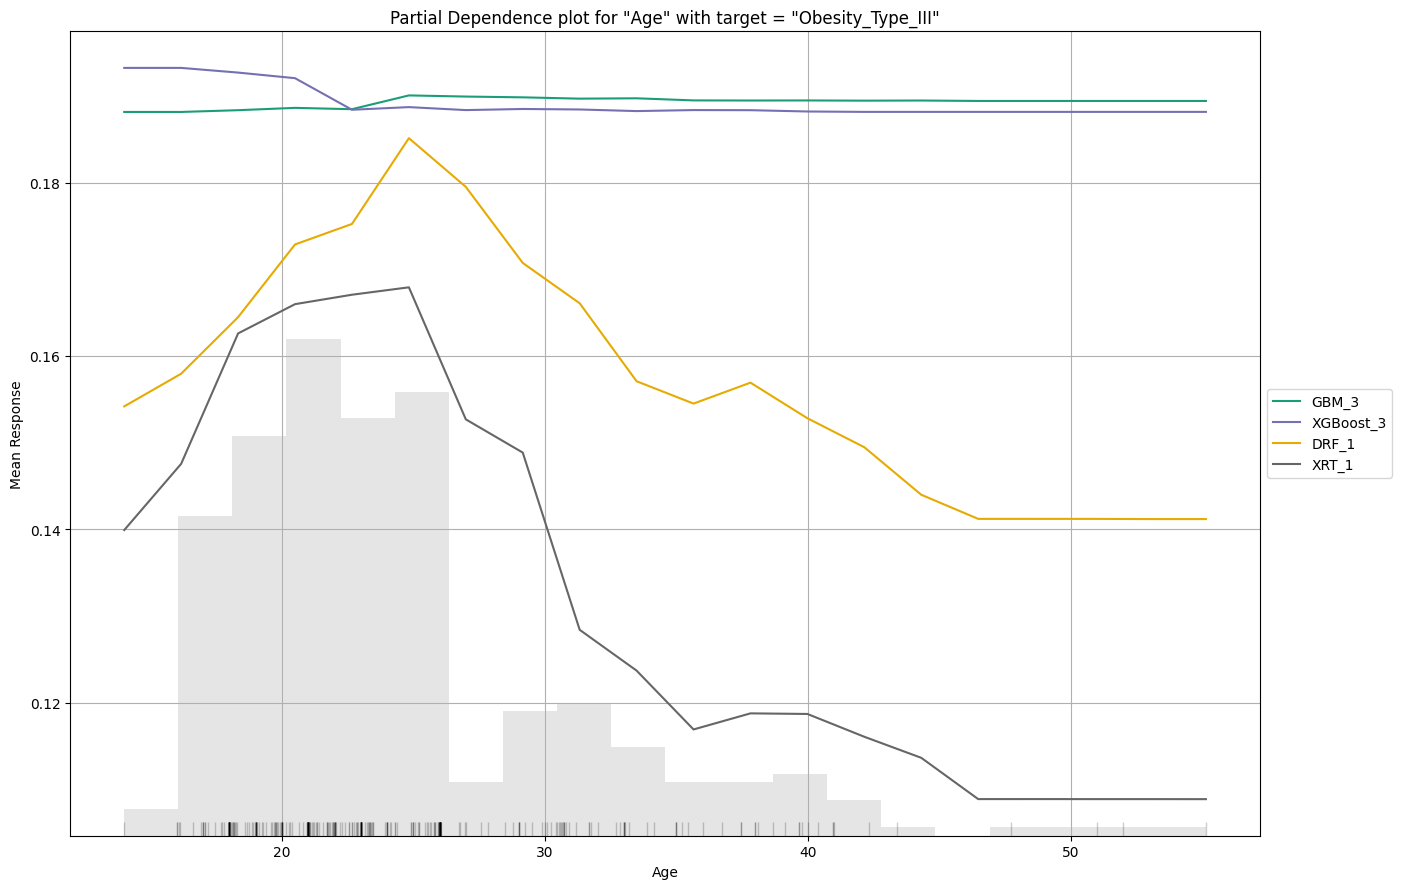

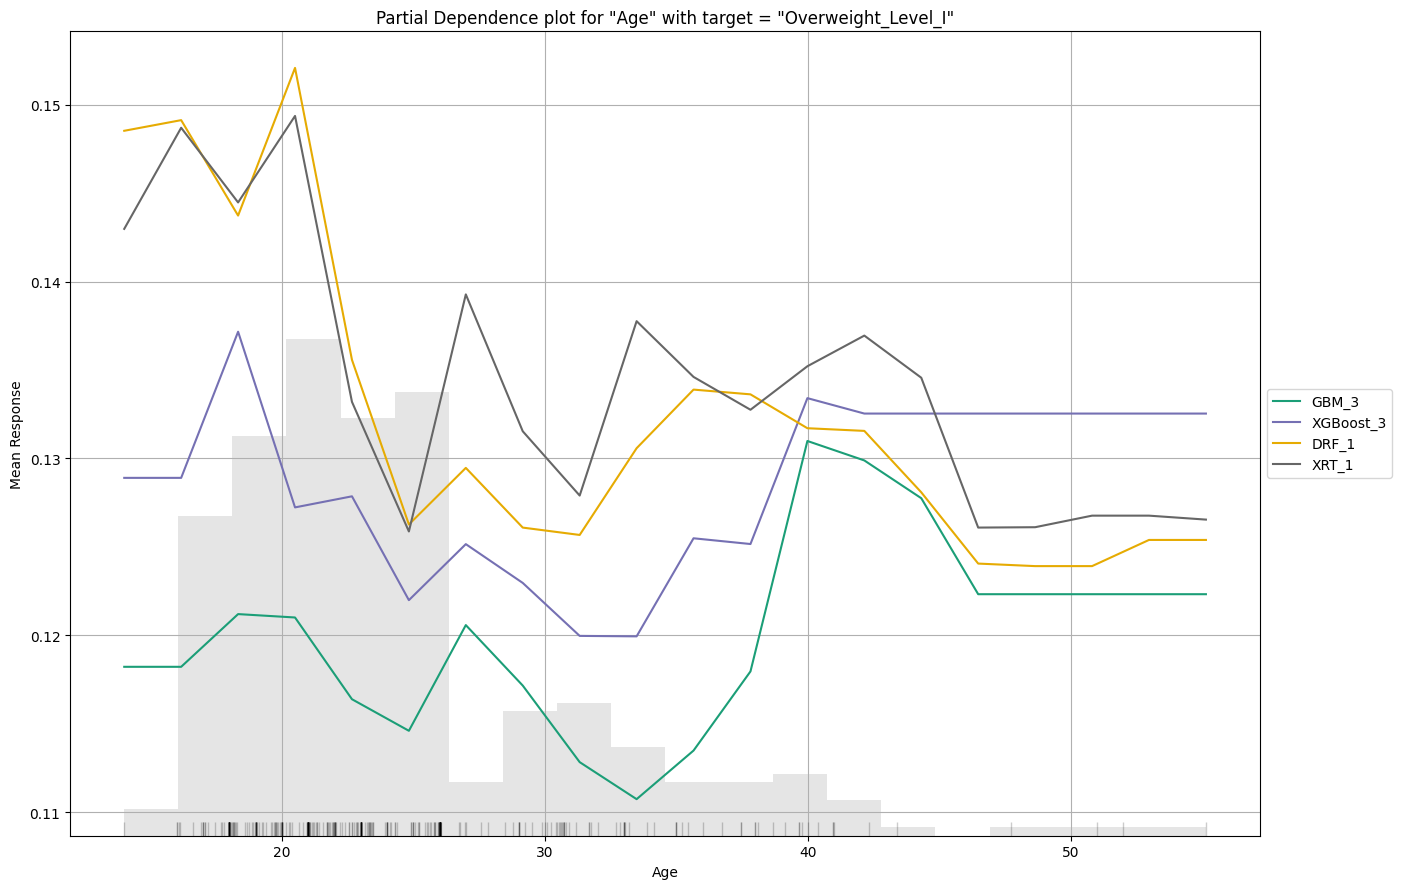

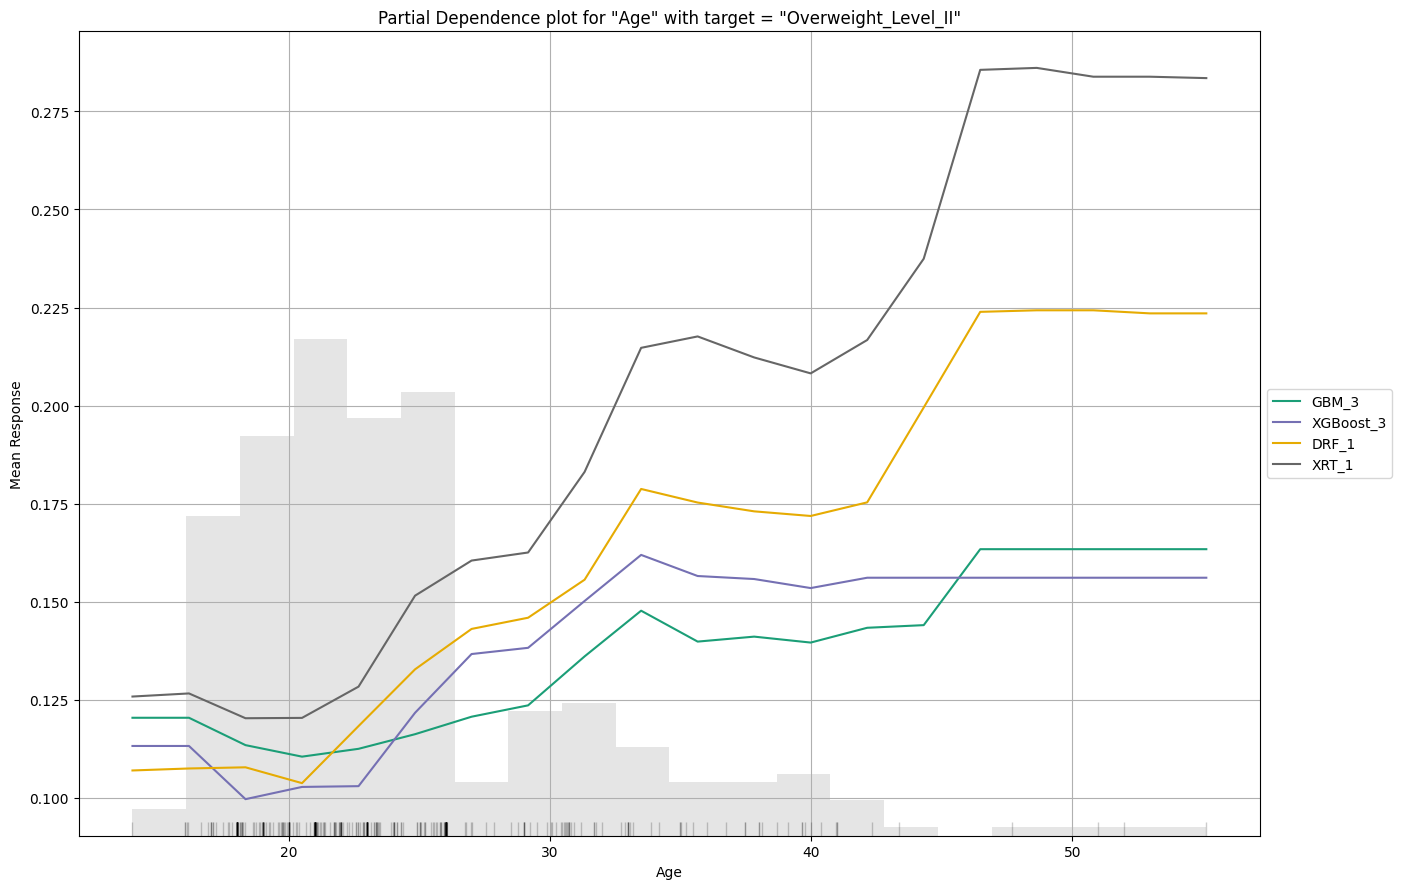

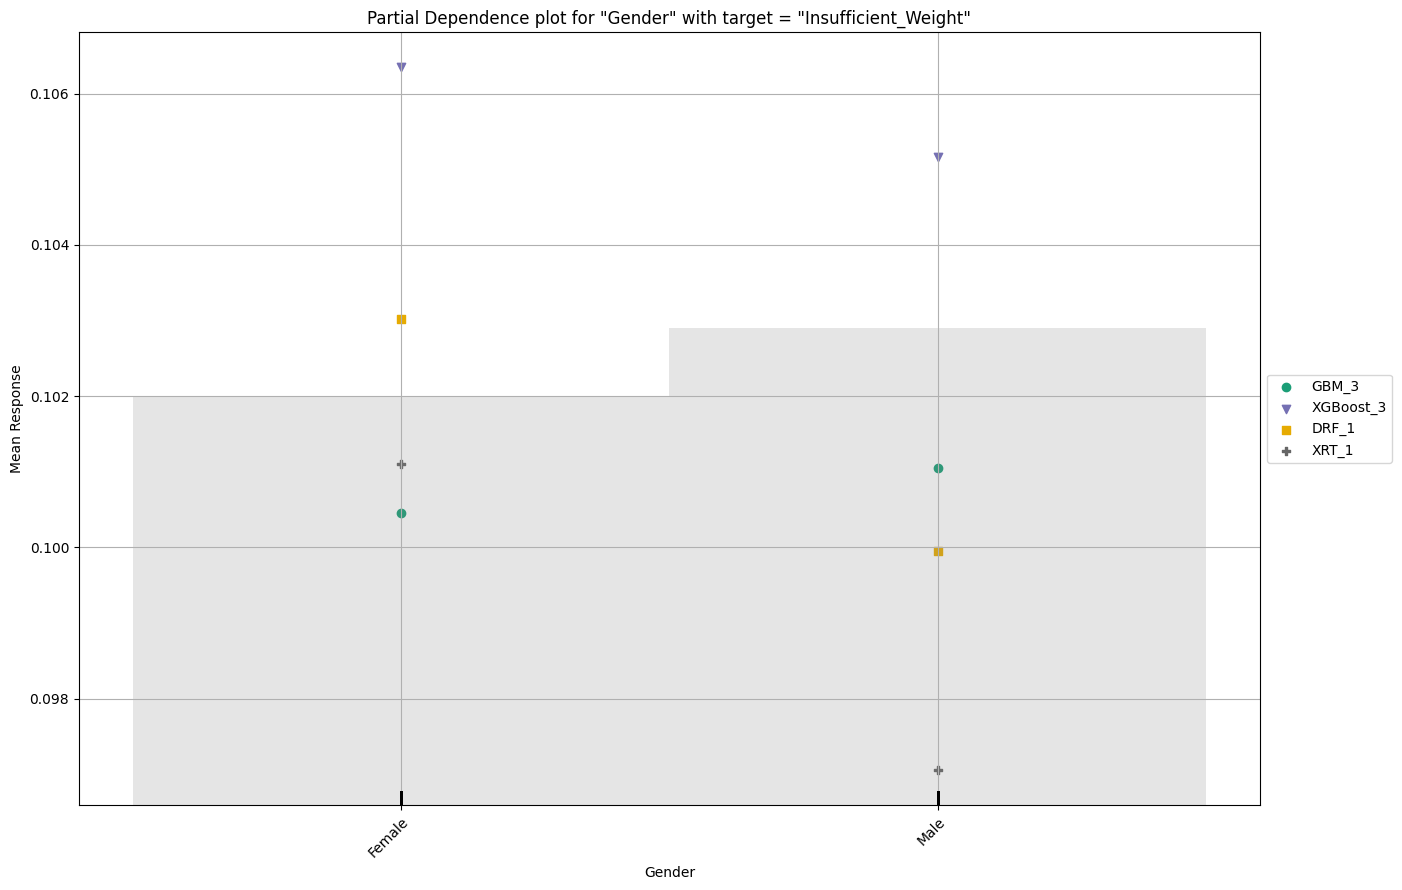

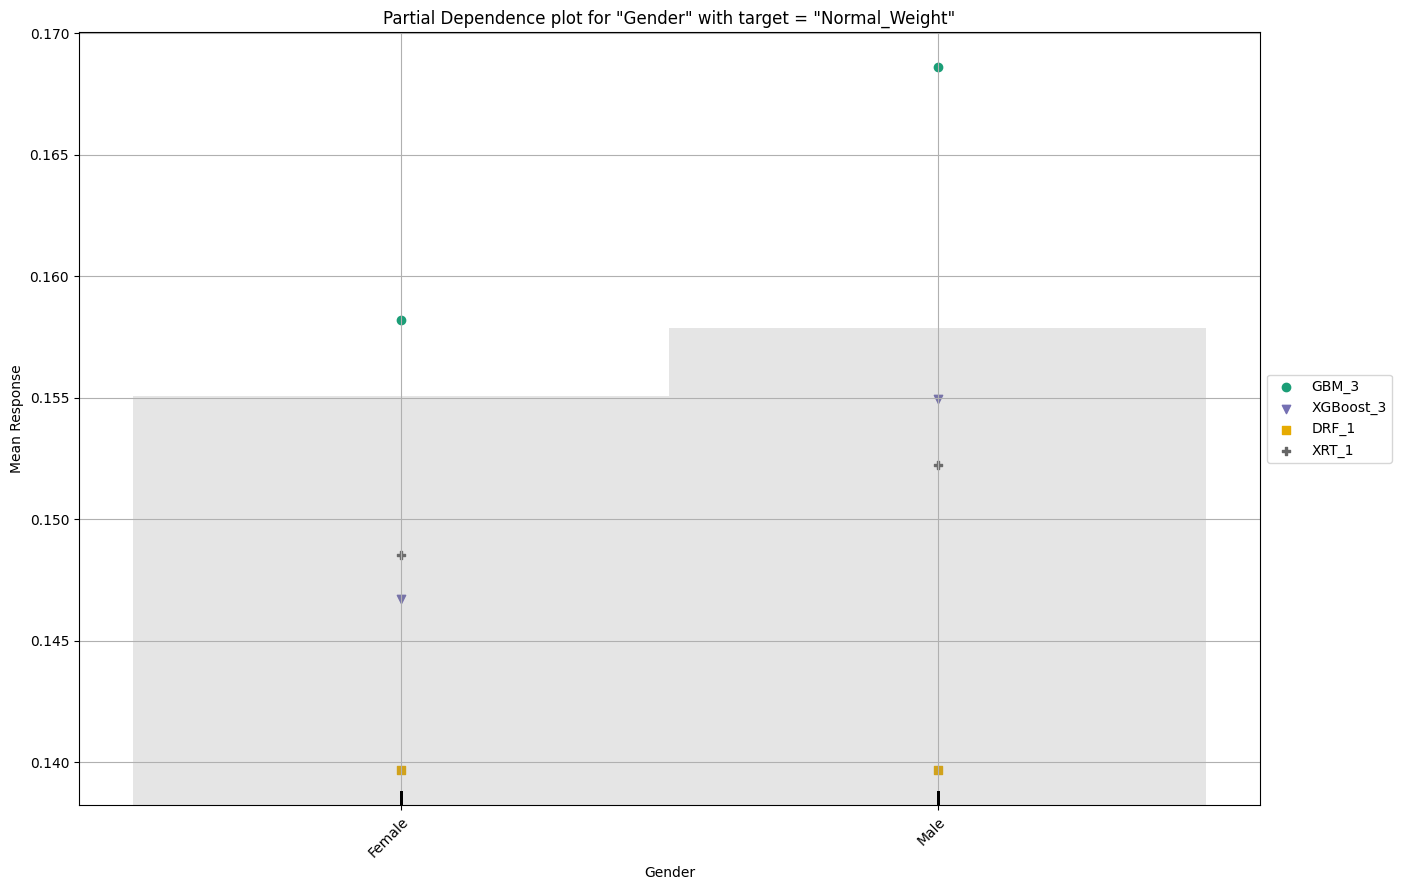

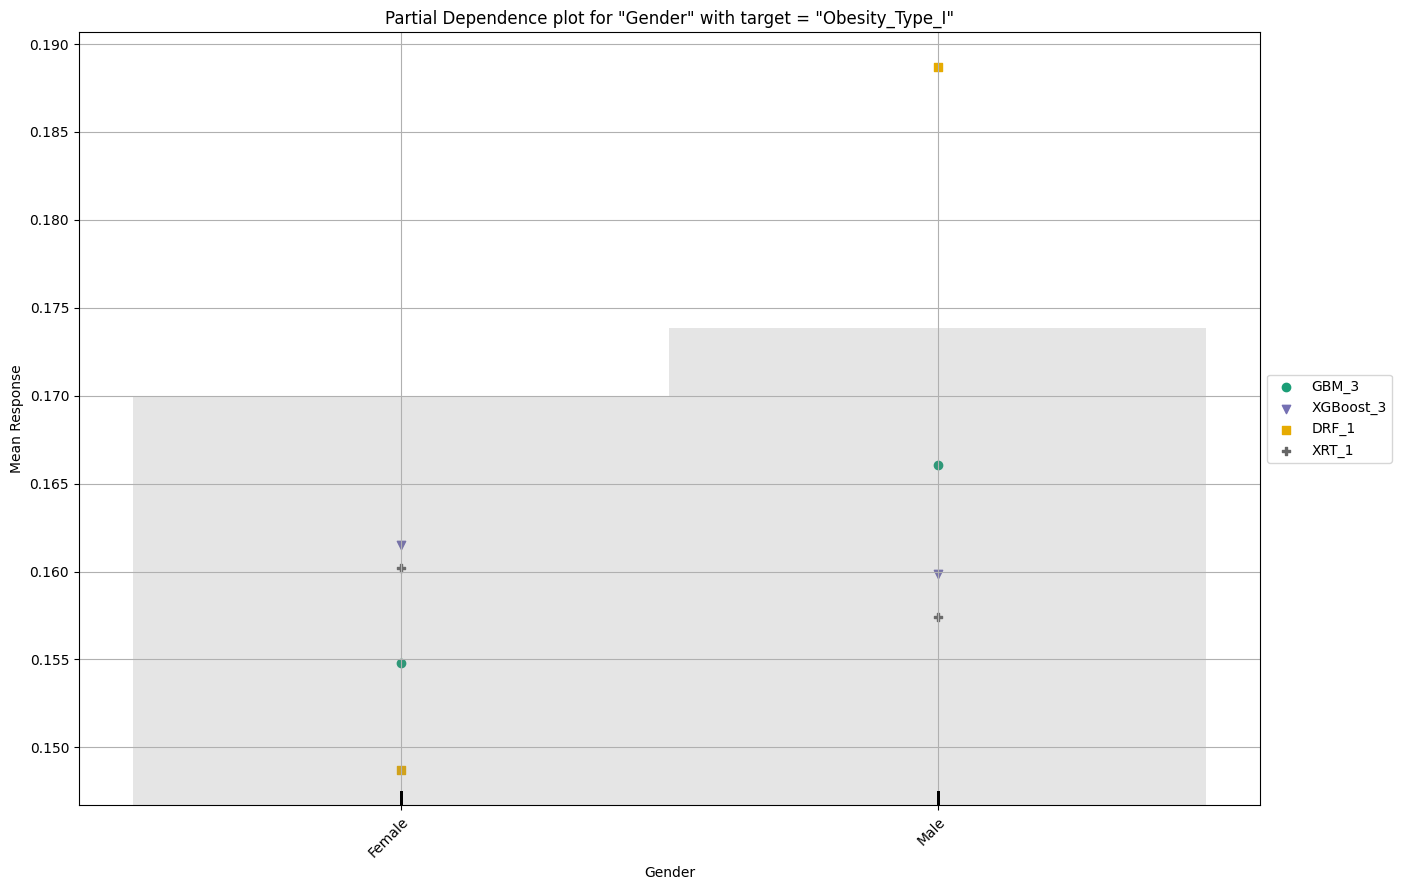

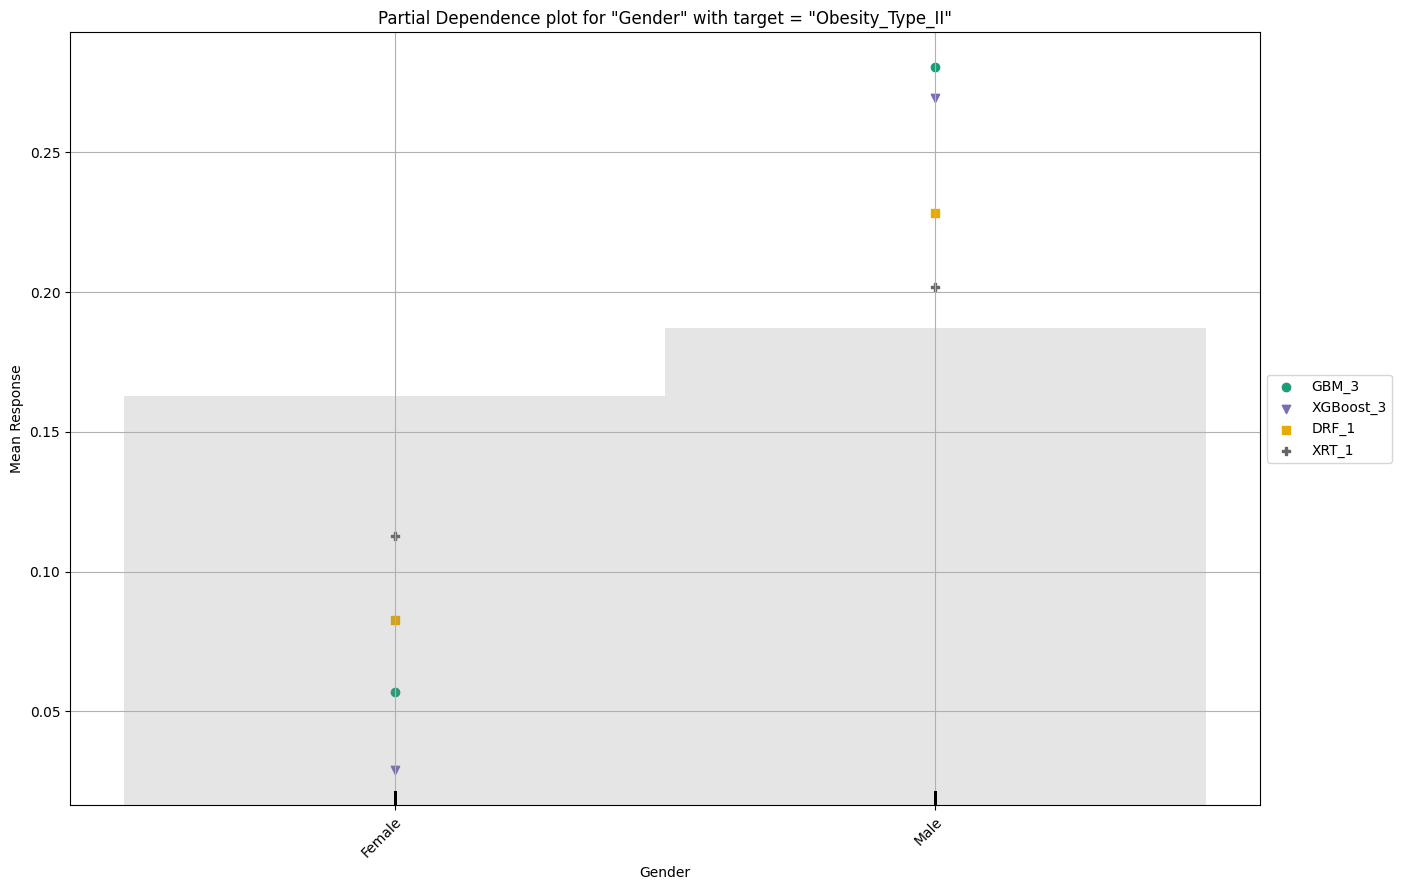

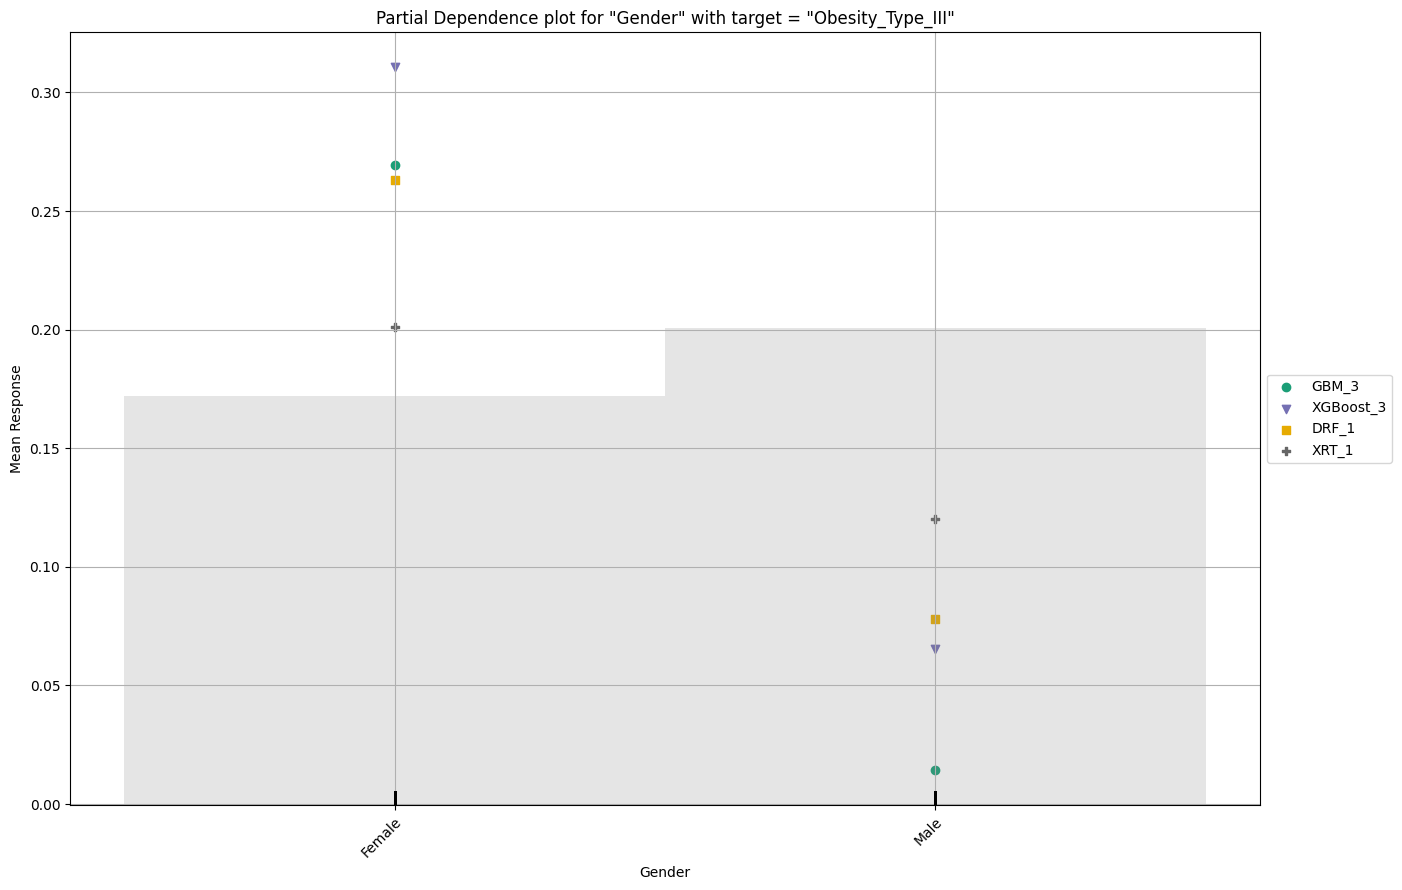

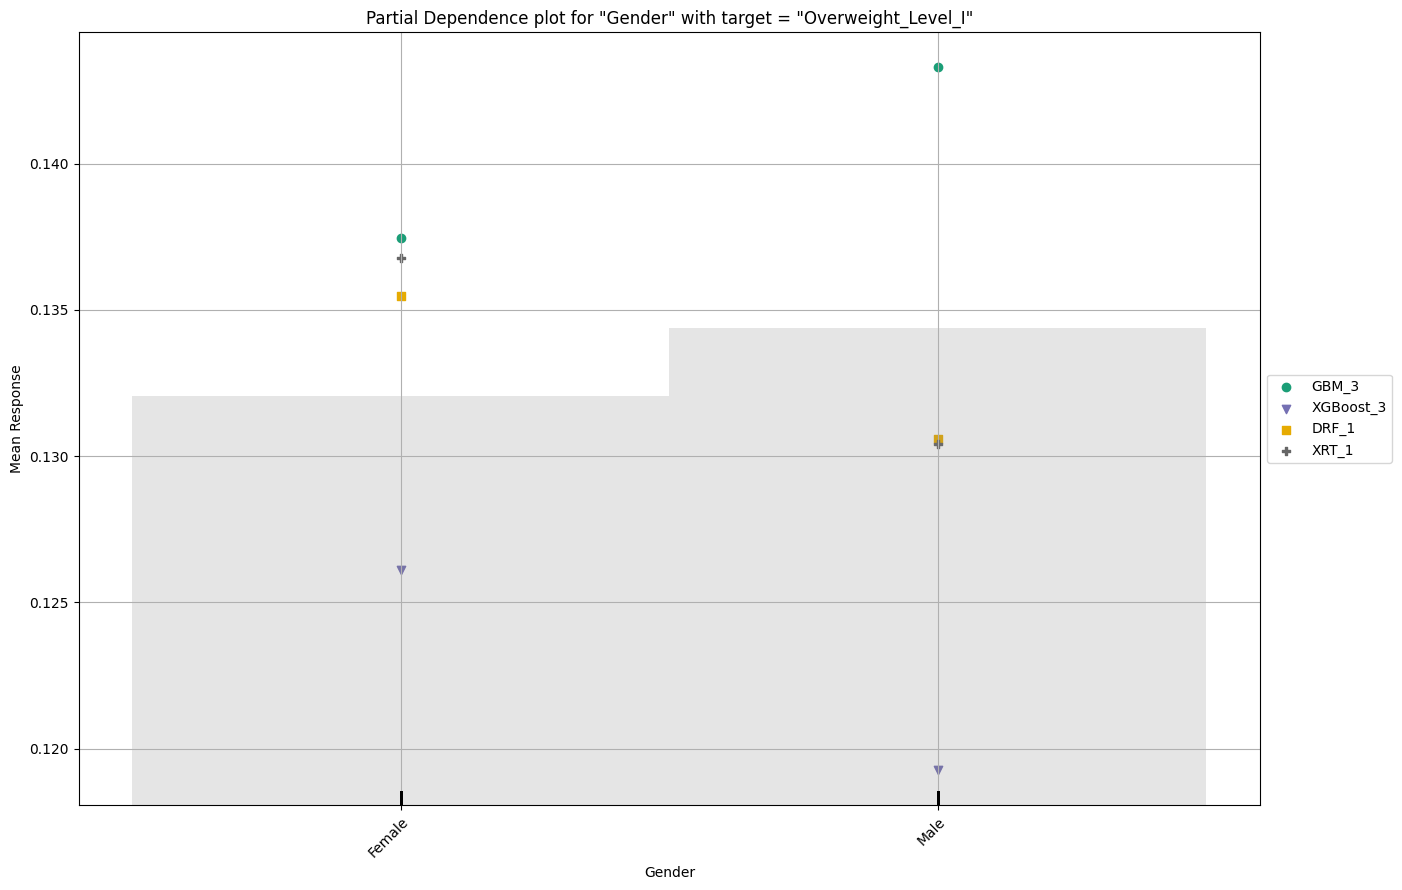

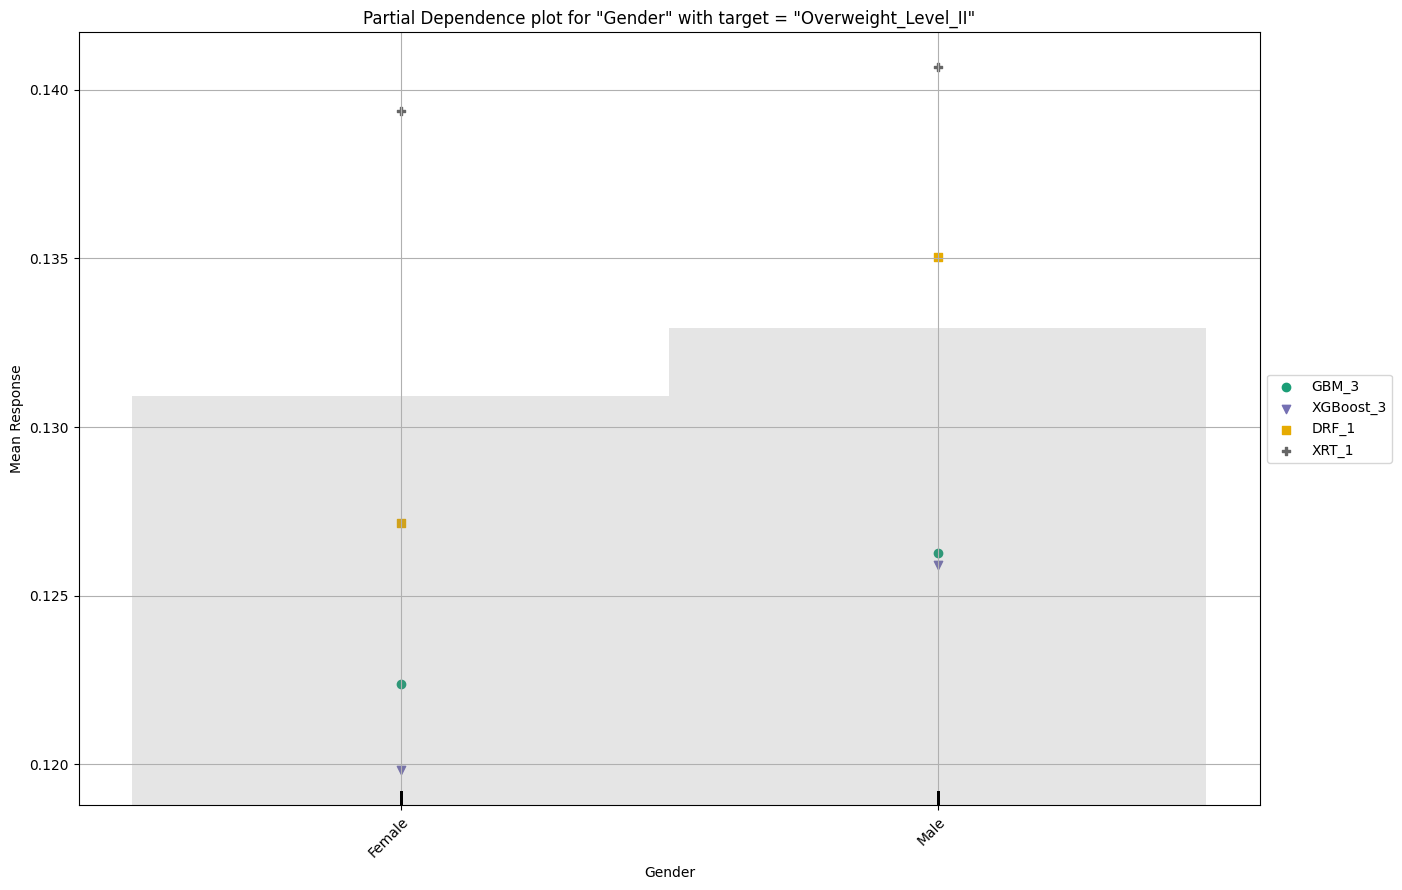

In [ ]:
exa = aml.explain(df_test)


# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## GBM_3_AutoML_1_20240316_211729

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
Insufficient_Weight    Normal_Weight    Obesity_Type_I    Obesity_Type_II    Obesity_Type_III    Overweight_Level_I    Overweight_Level_II    Error      Rate
---------------------  ---------------  ----------------  -----------------  ------------------  --------------------  ---------------------  ---------  --------
30                     1                0                 0                  0                   0                     0                      0.0322581  1 / 31
1                      46               0                 0                  0                   3                     1                      0.0980392  5 / 51
0                      0                46                0                  0                   0                     2                      0.0416667  2 / 48
0                      0                1                 49                 1                   0                     0                      0.0392157  2 / 51
0                      0                0                 0                  58                  0                     0                      0          0 / 58
0                      3                0                 0                  0                   32                    0                      0.0857143  3 / 35
0                      0                0                 0                  0                   0                     36                     0          0 / 36
31                     50               47                49                 59                  35                    39                     0.0419355  13 / 310

# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

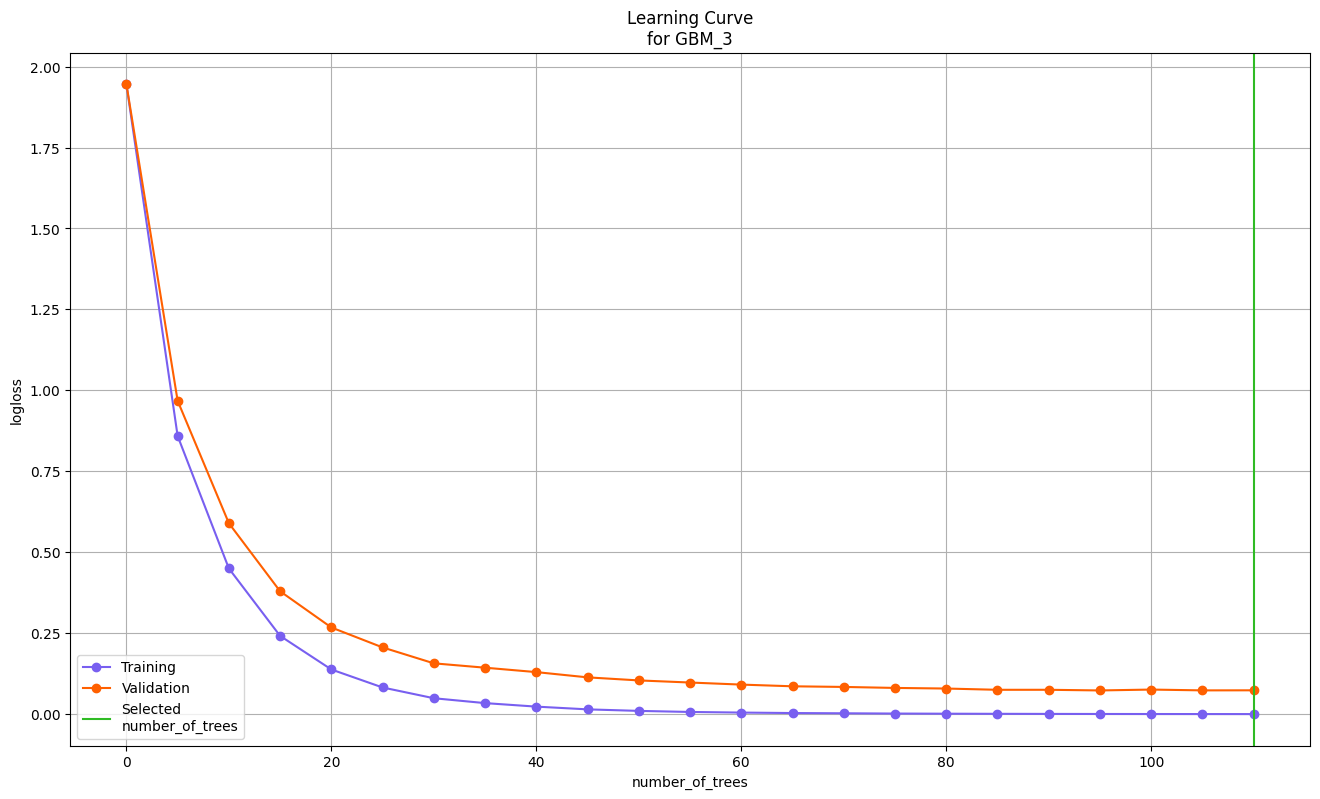

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

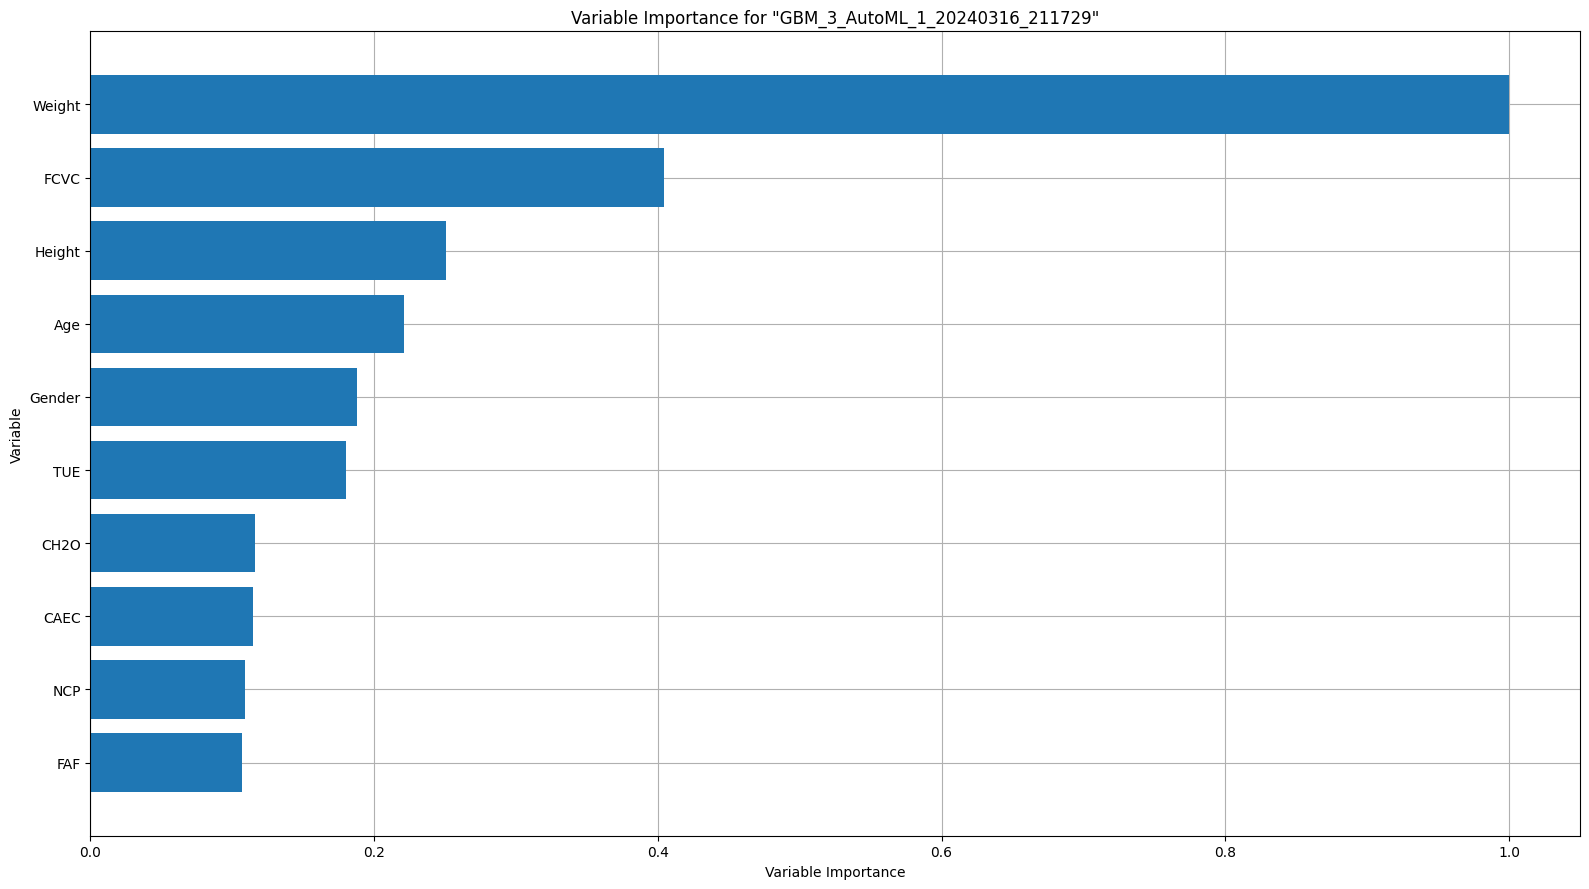

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

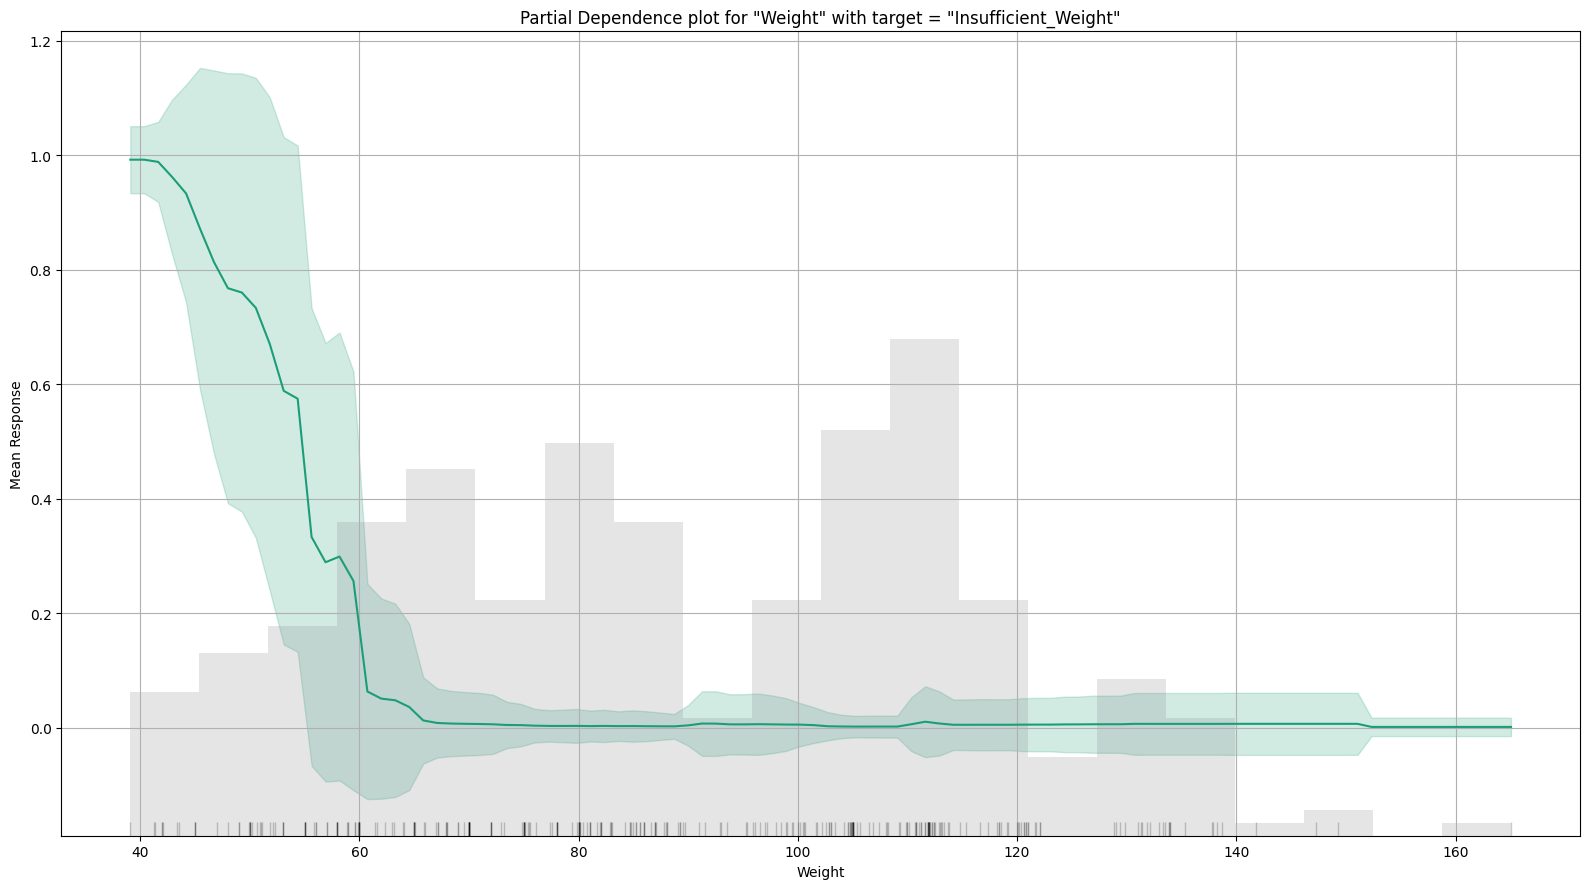

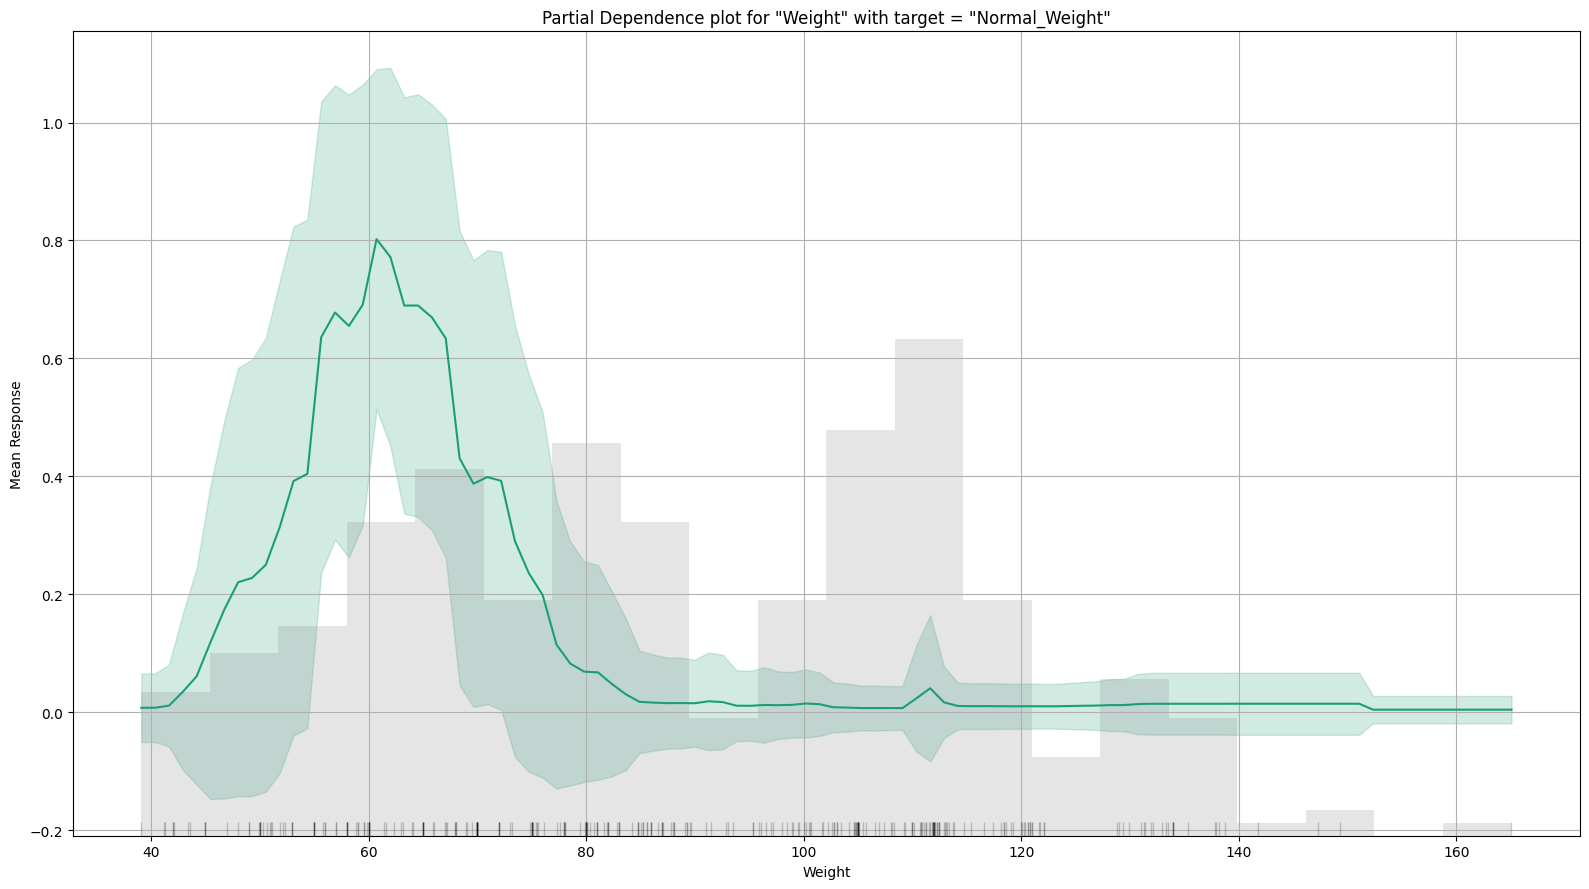

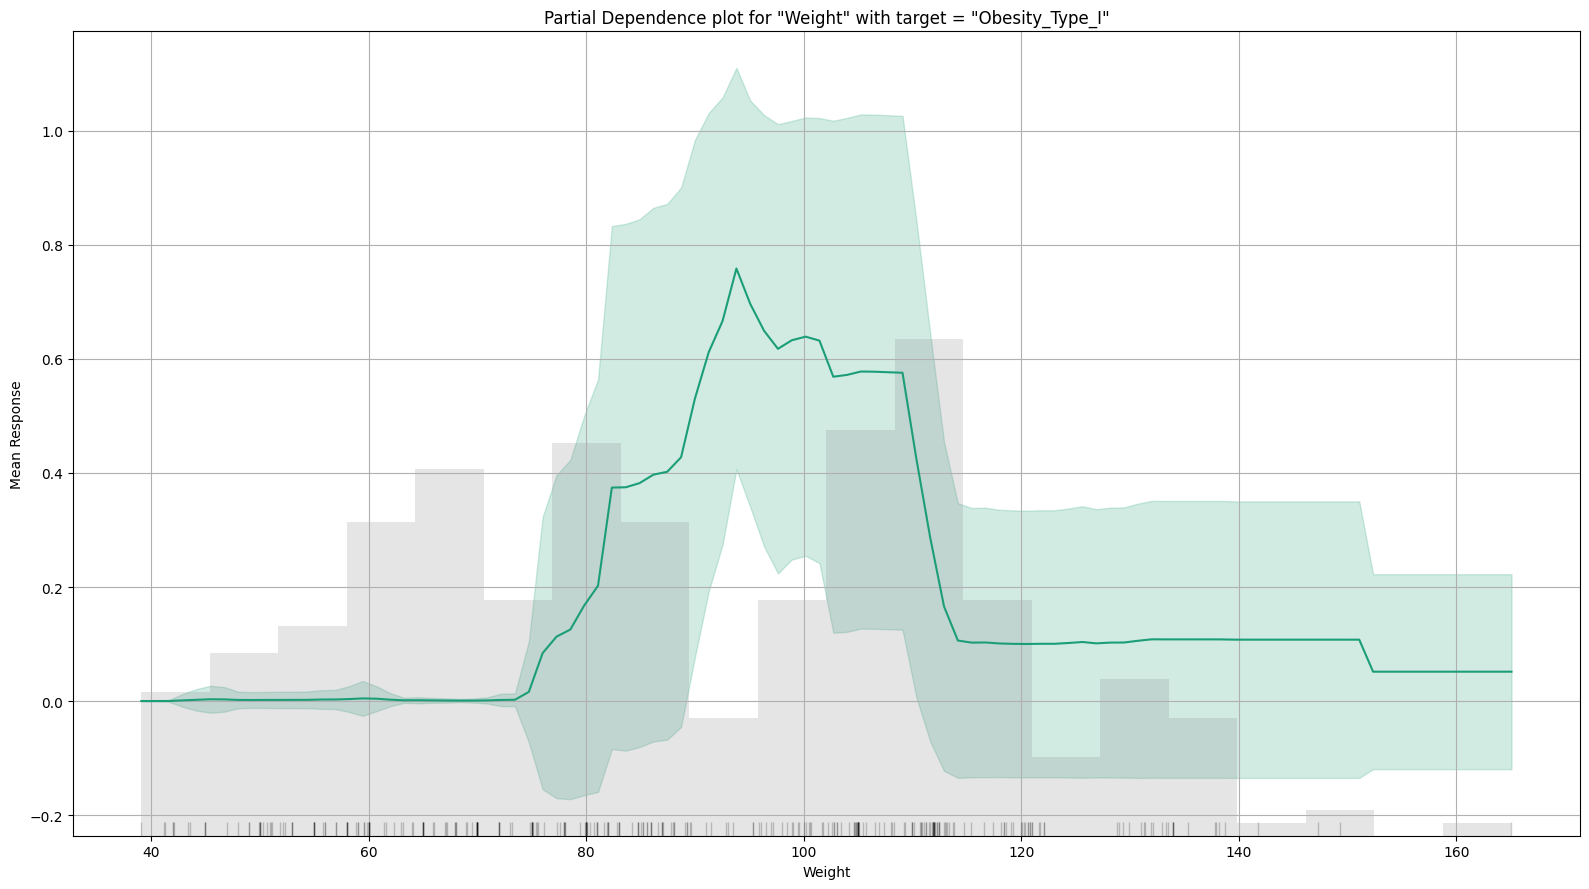

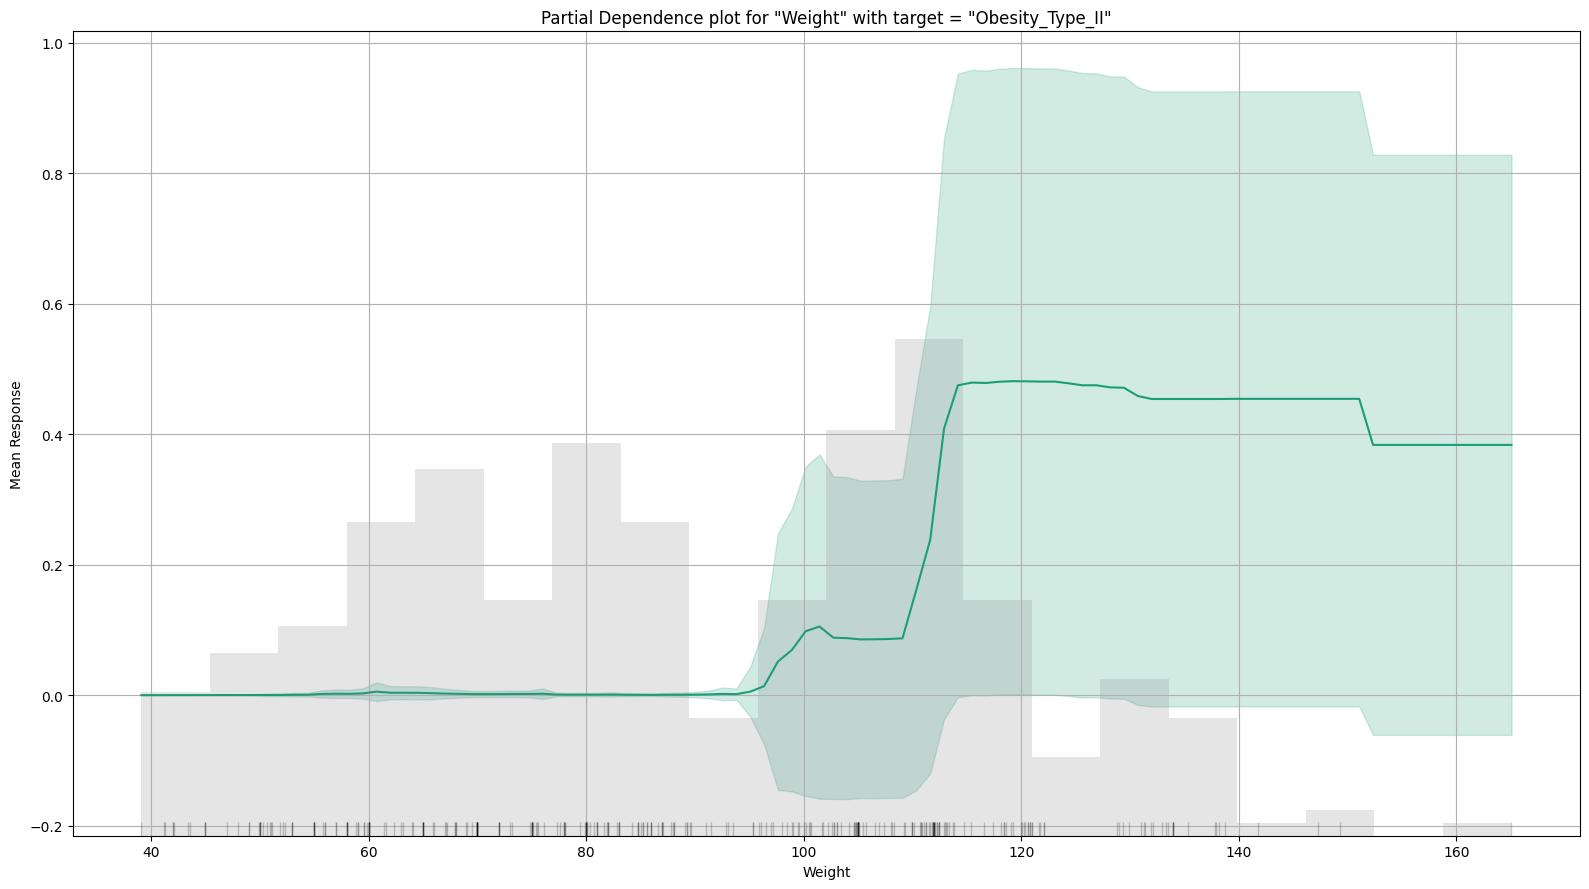

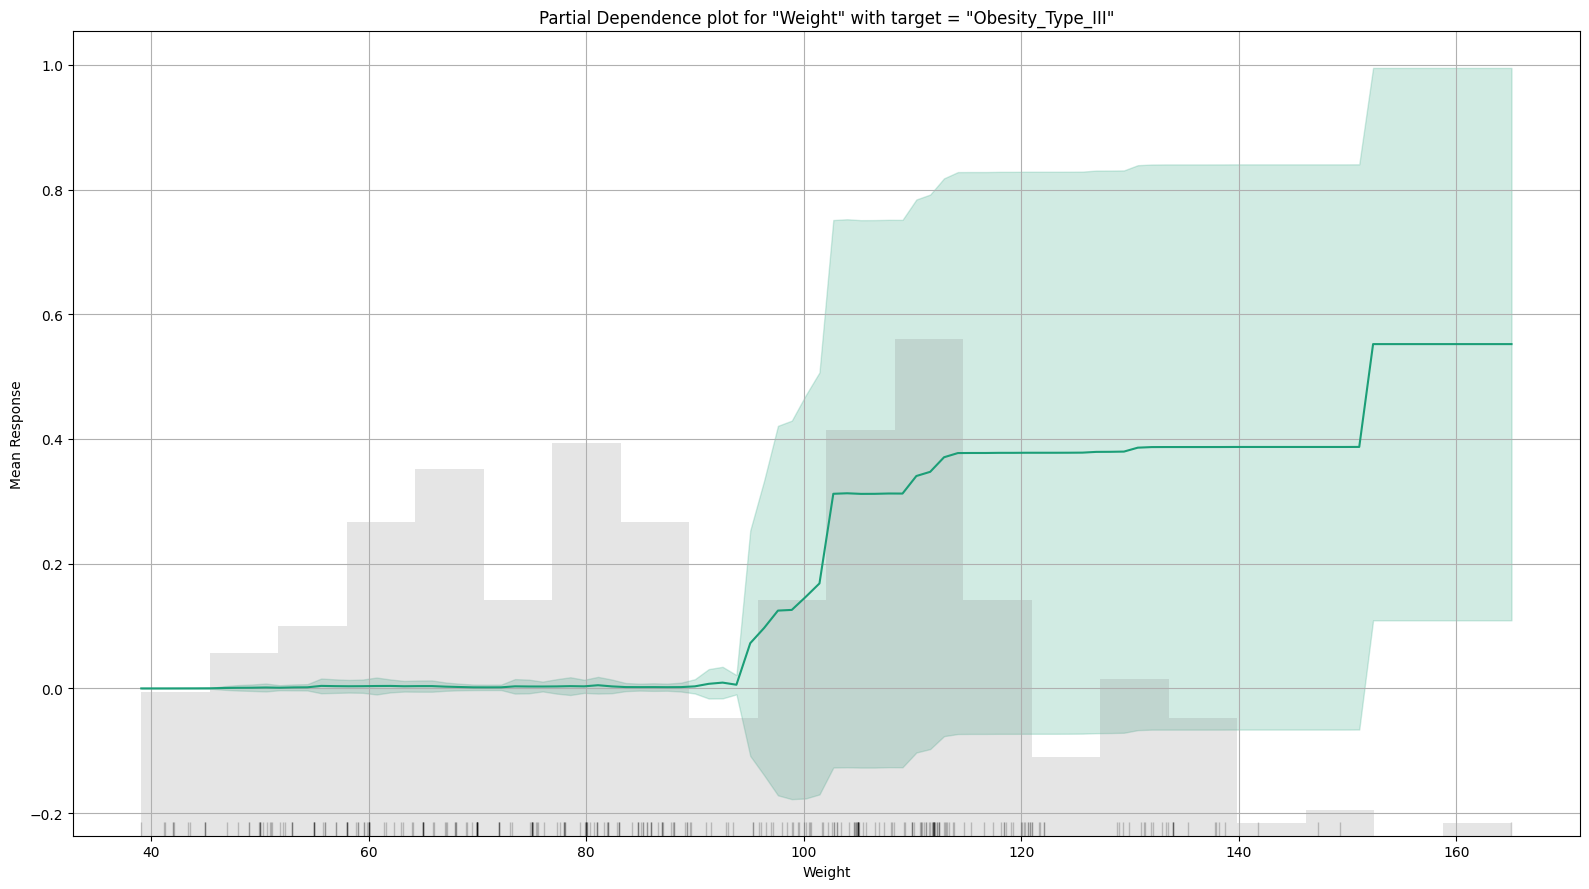

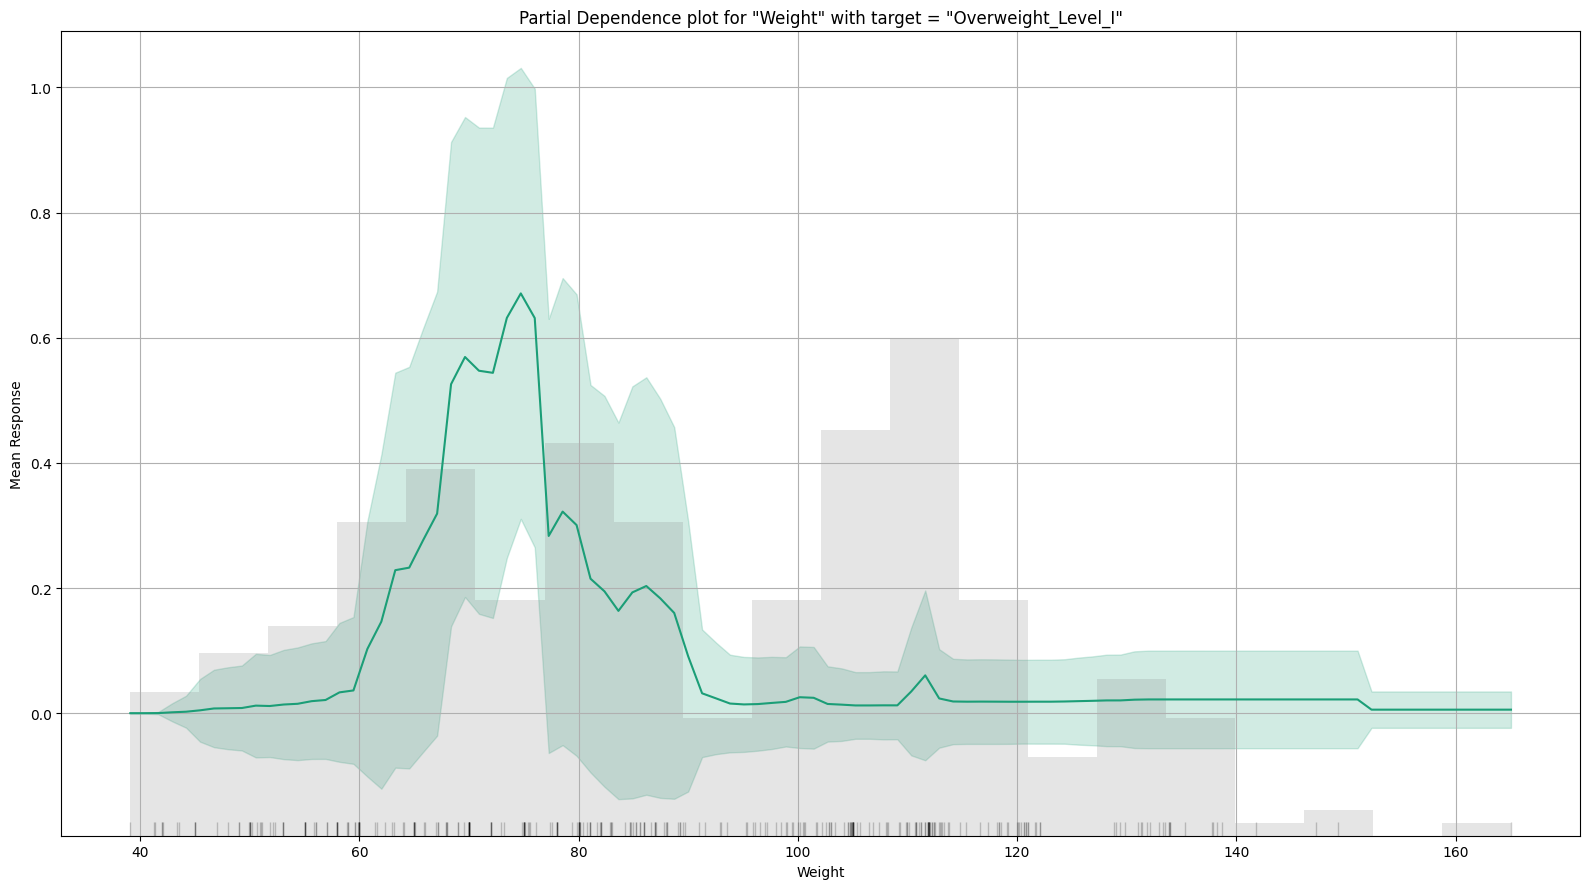

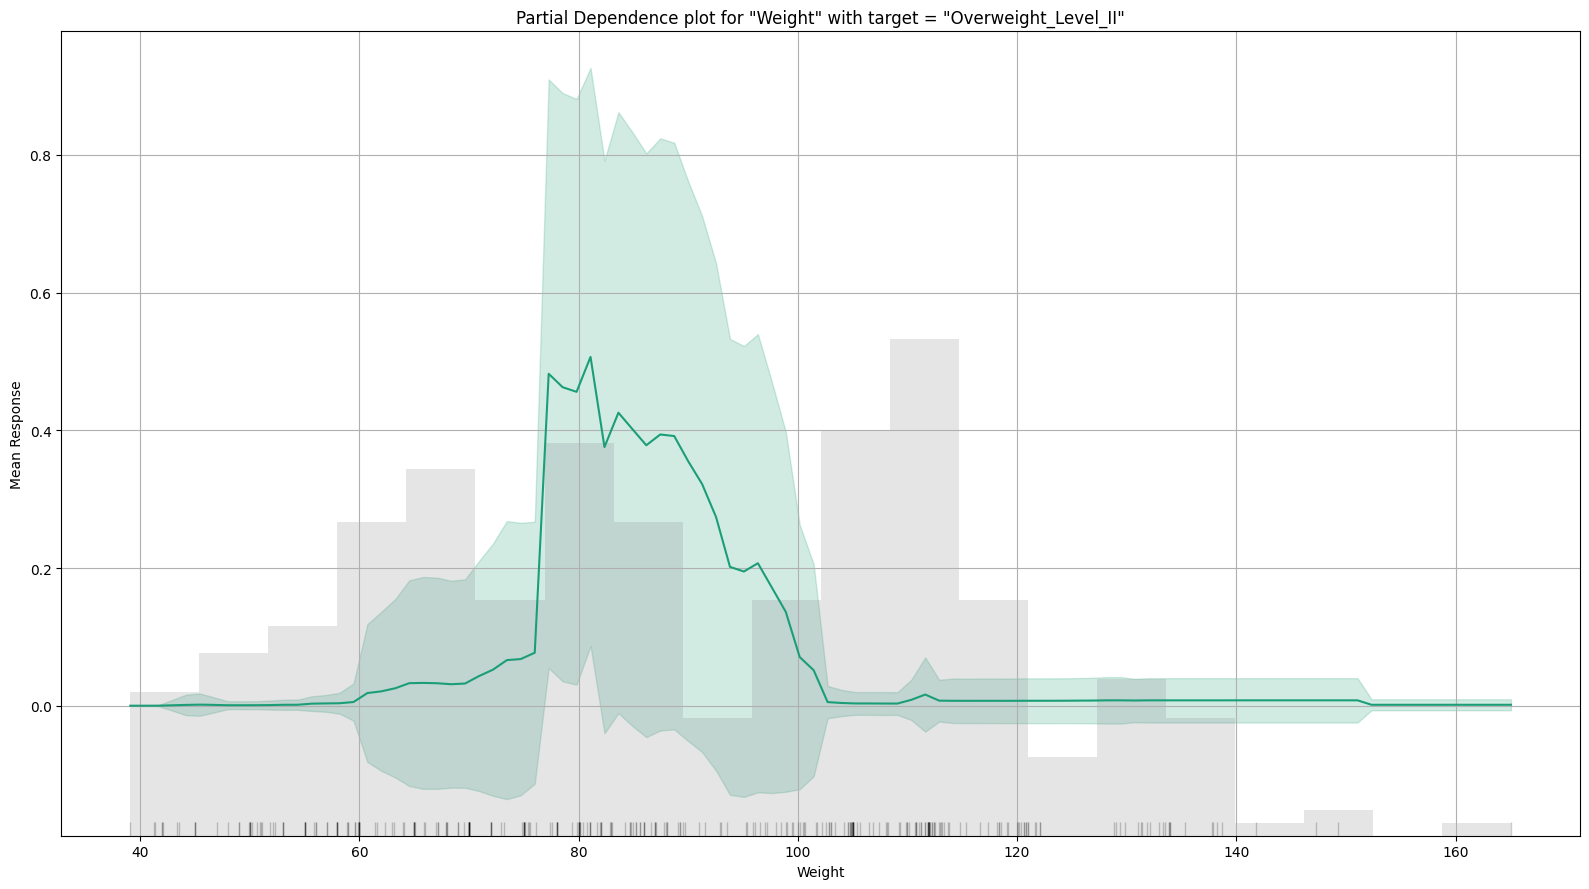

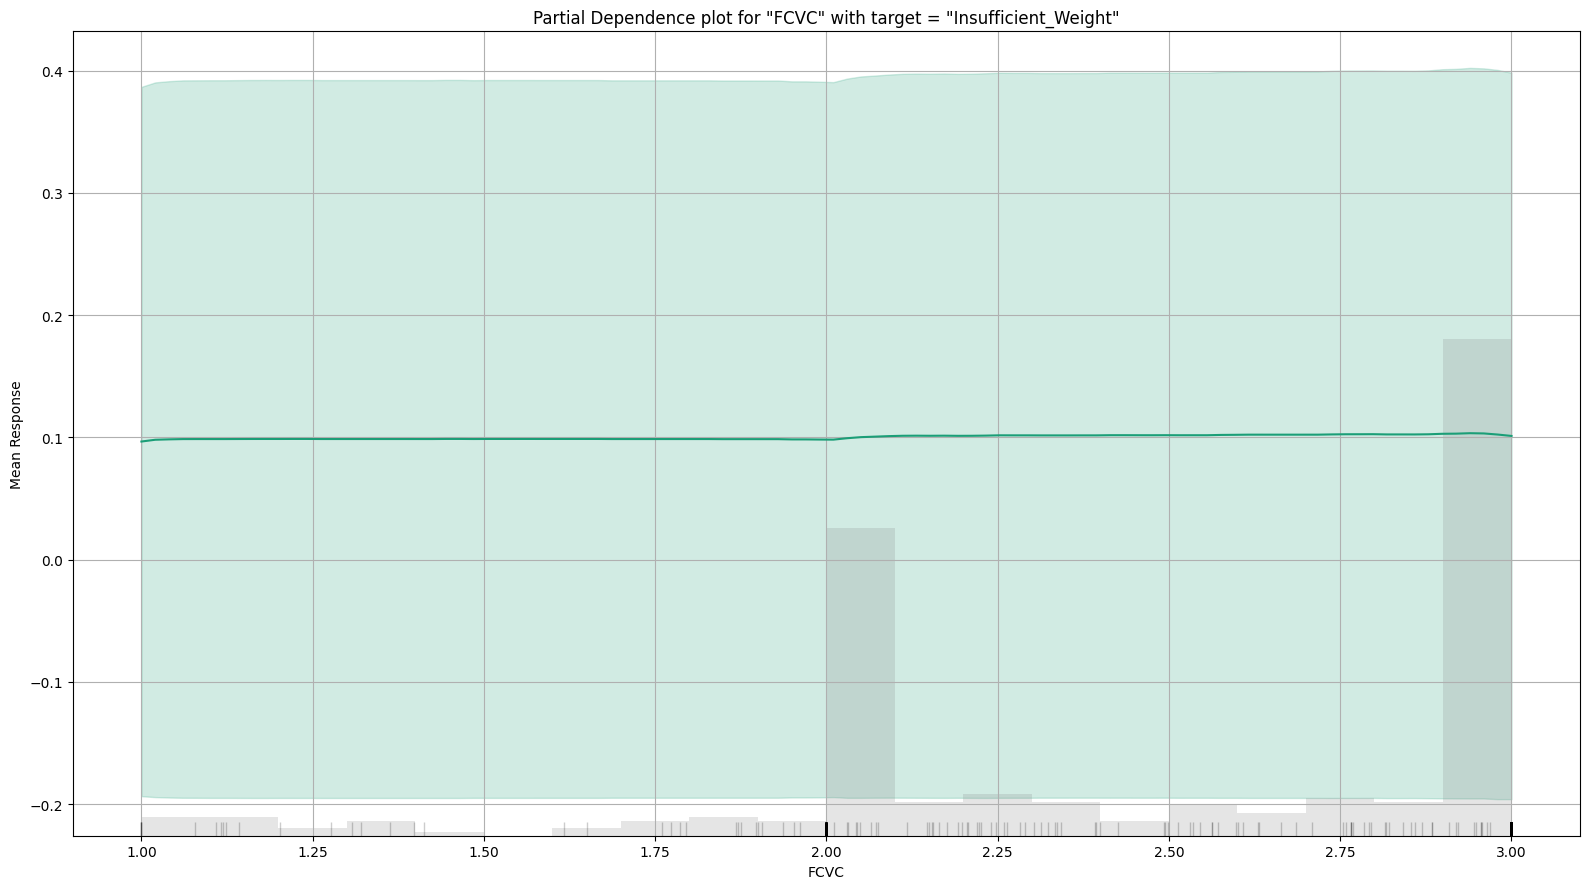

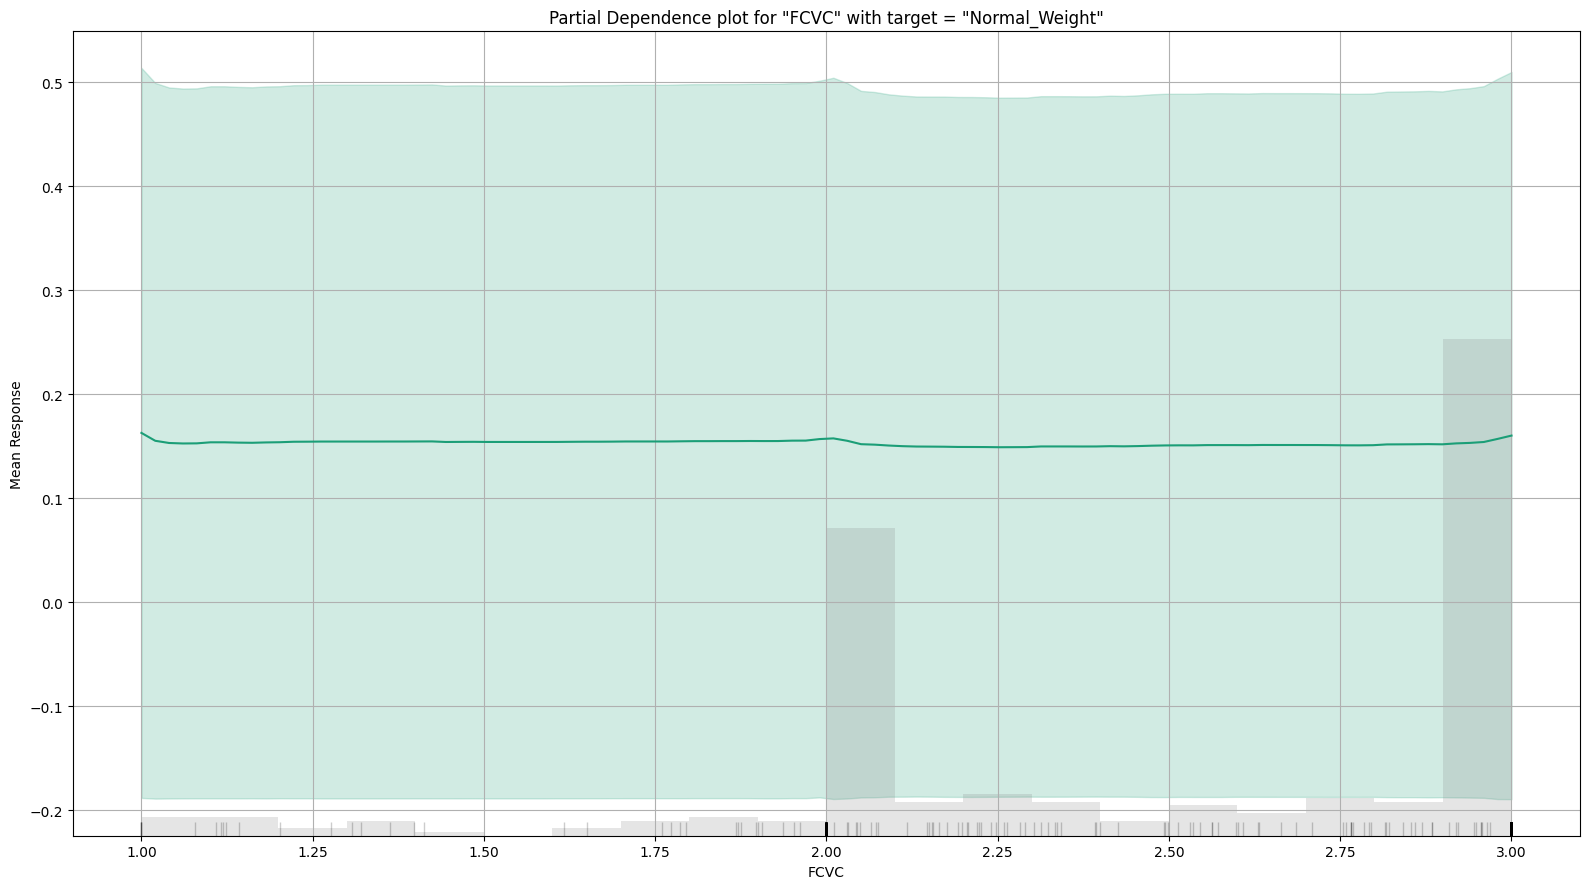

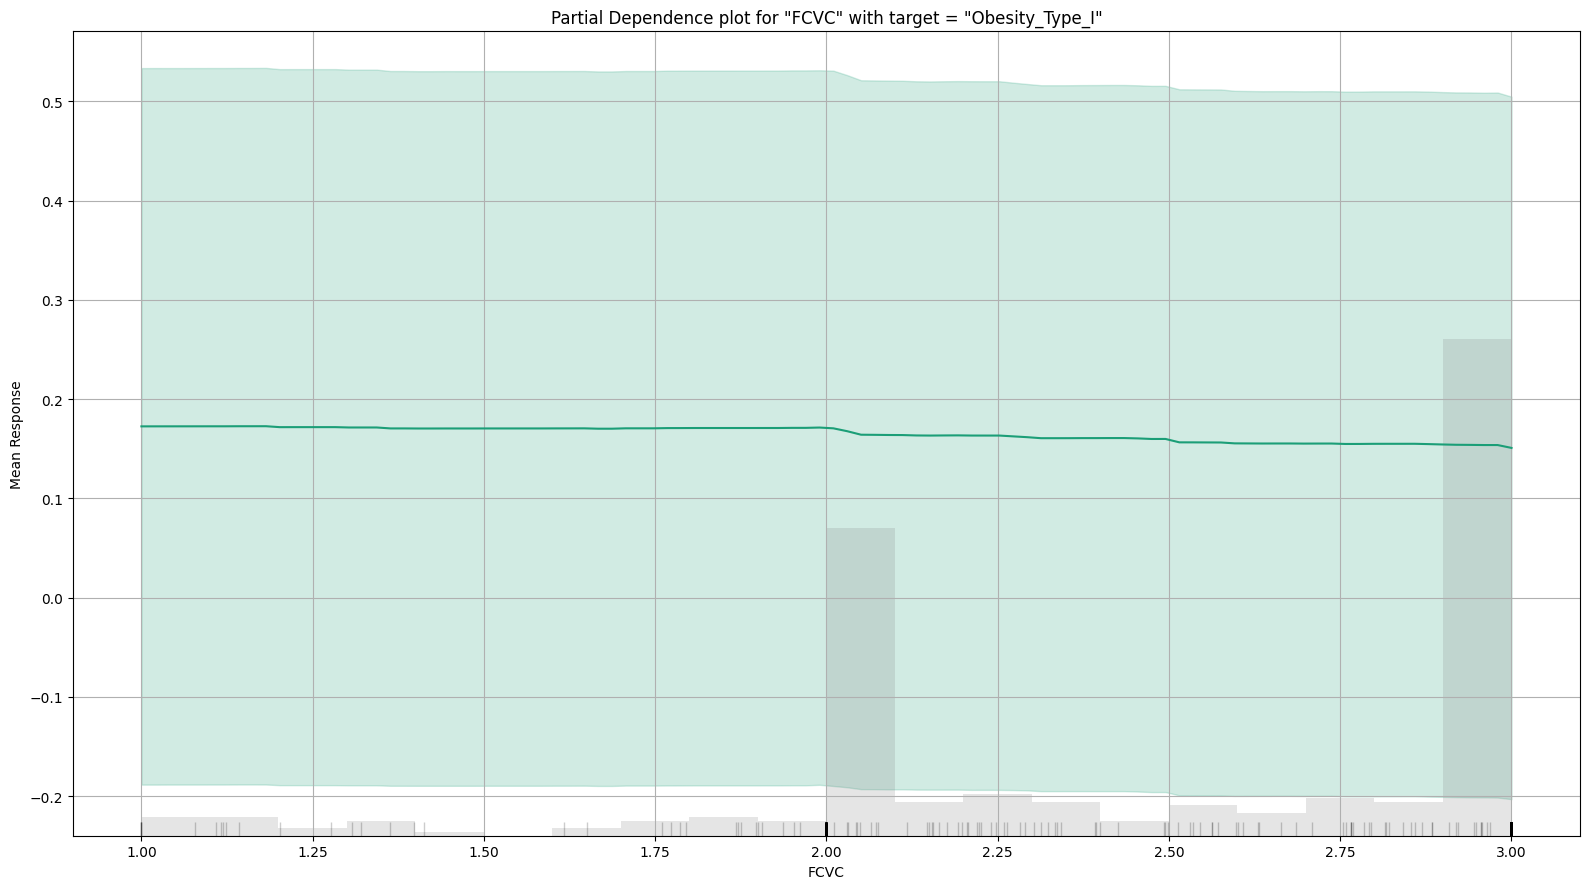

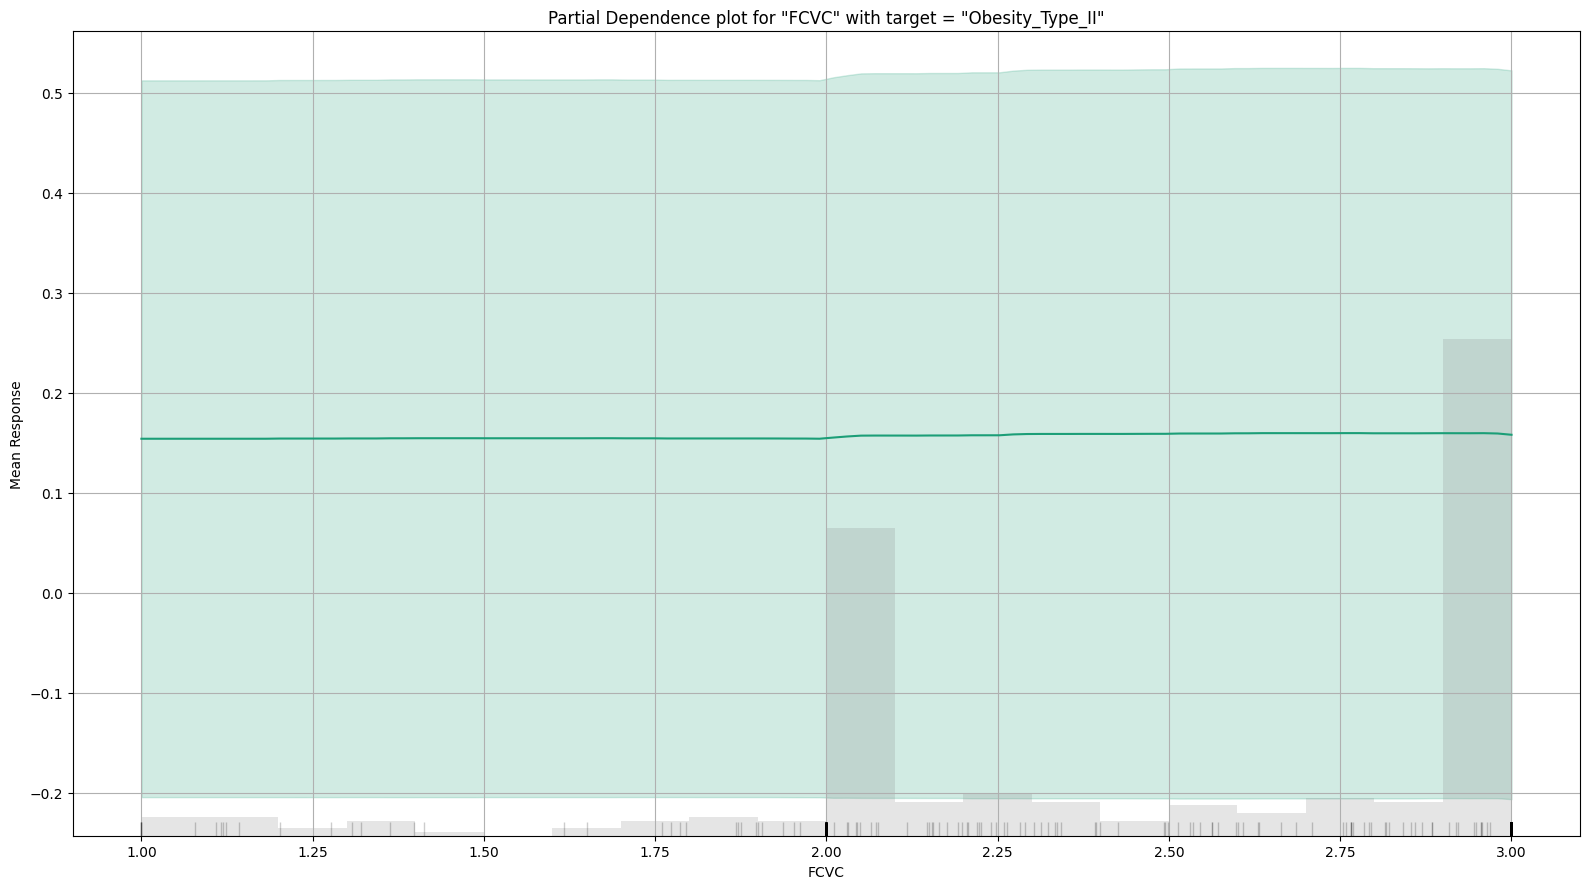

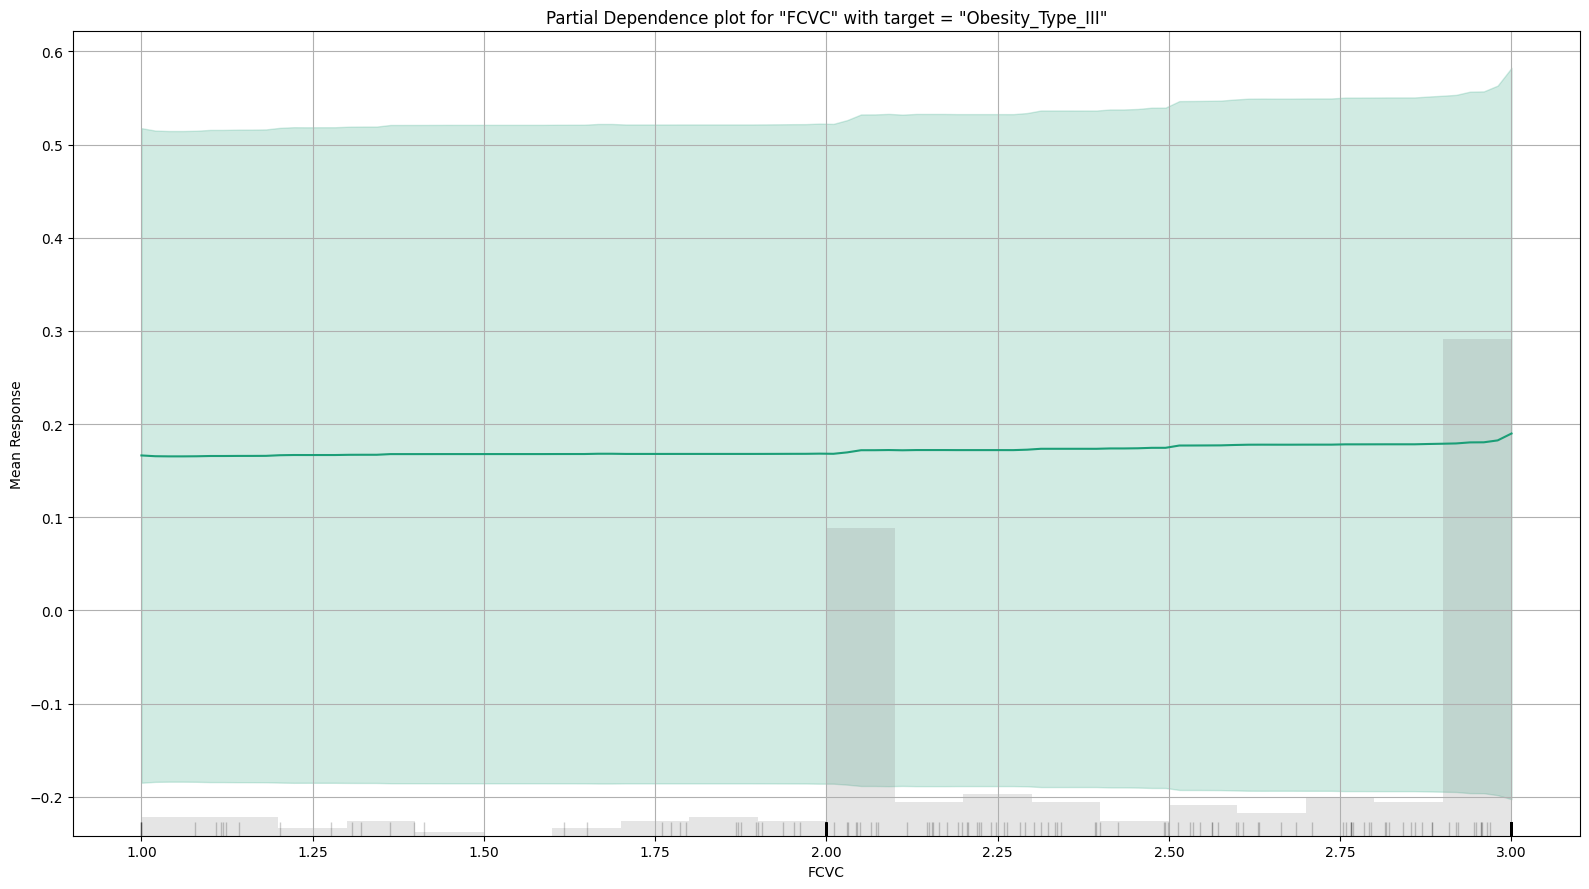

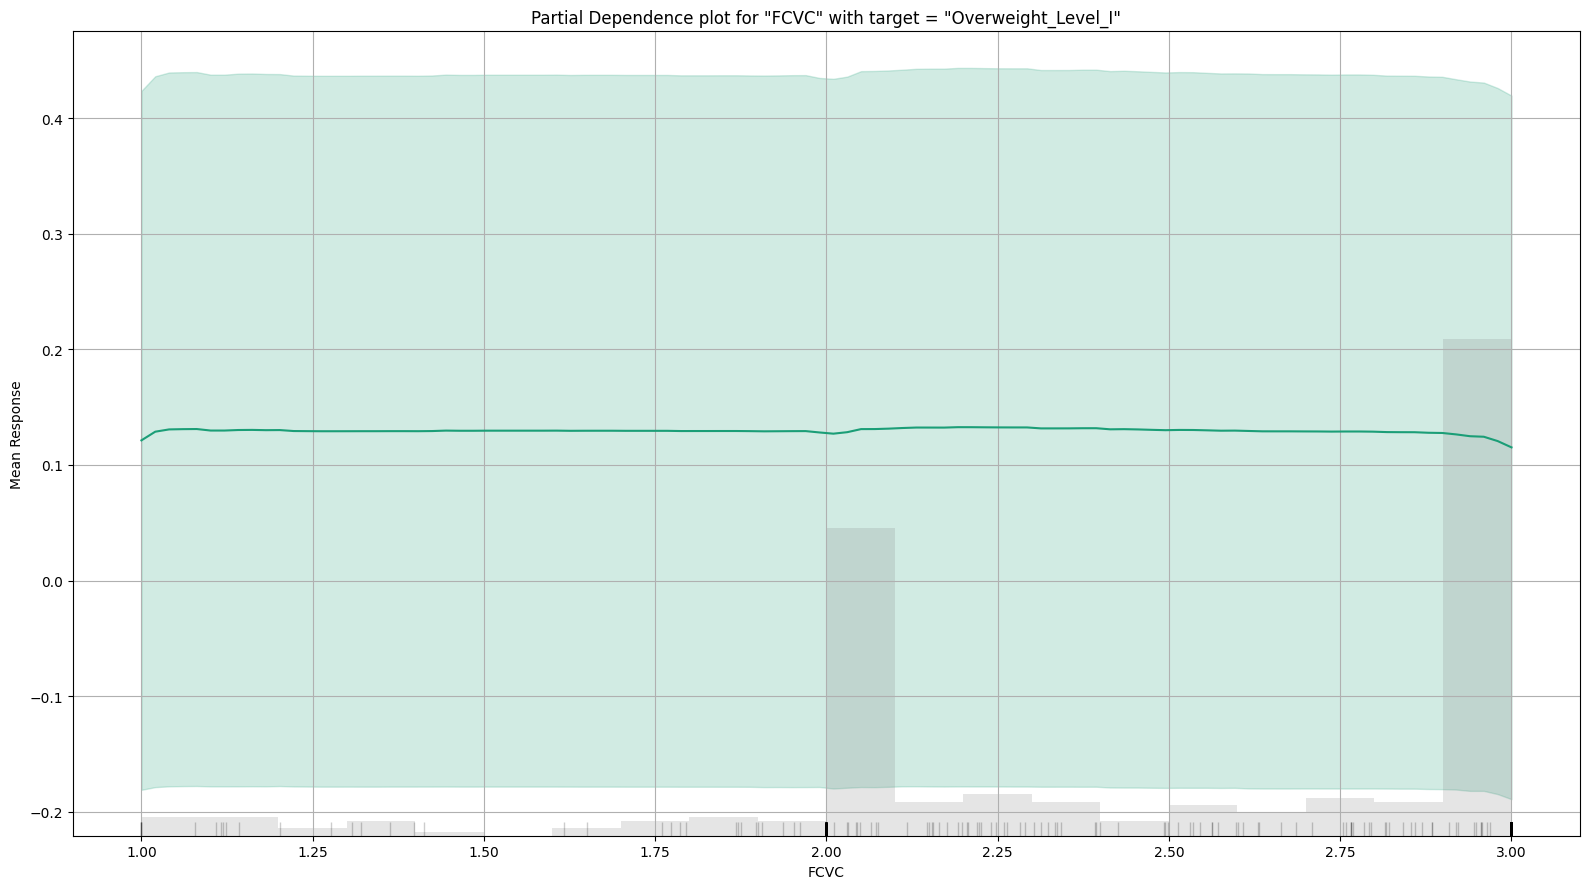

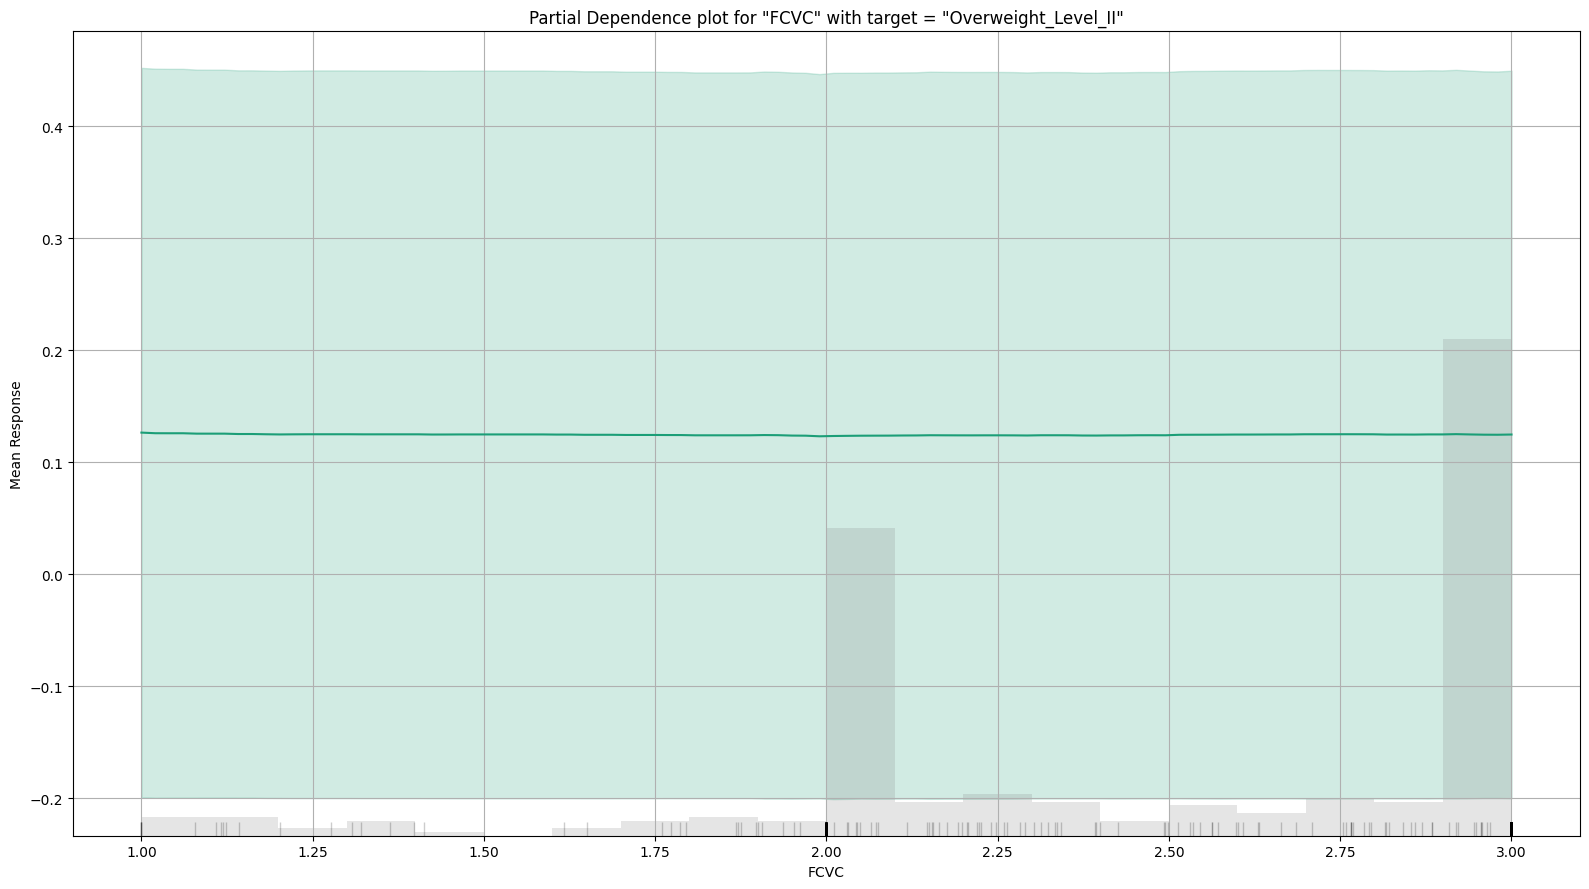

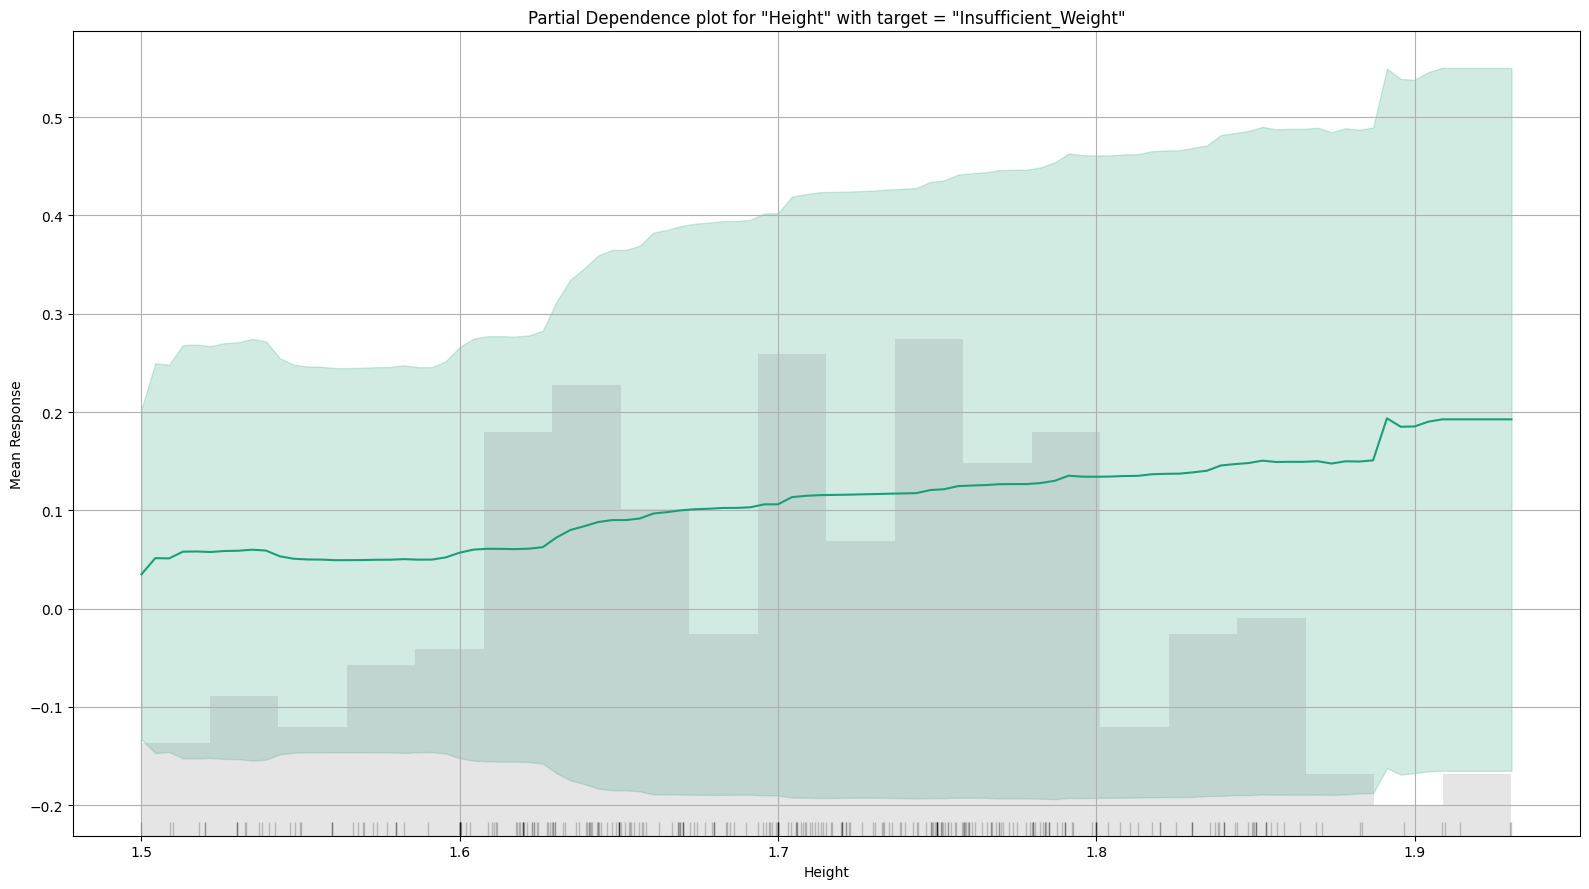

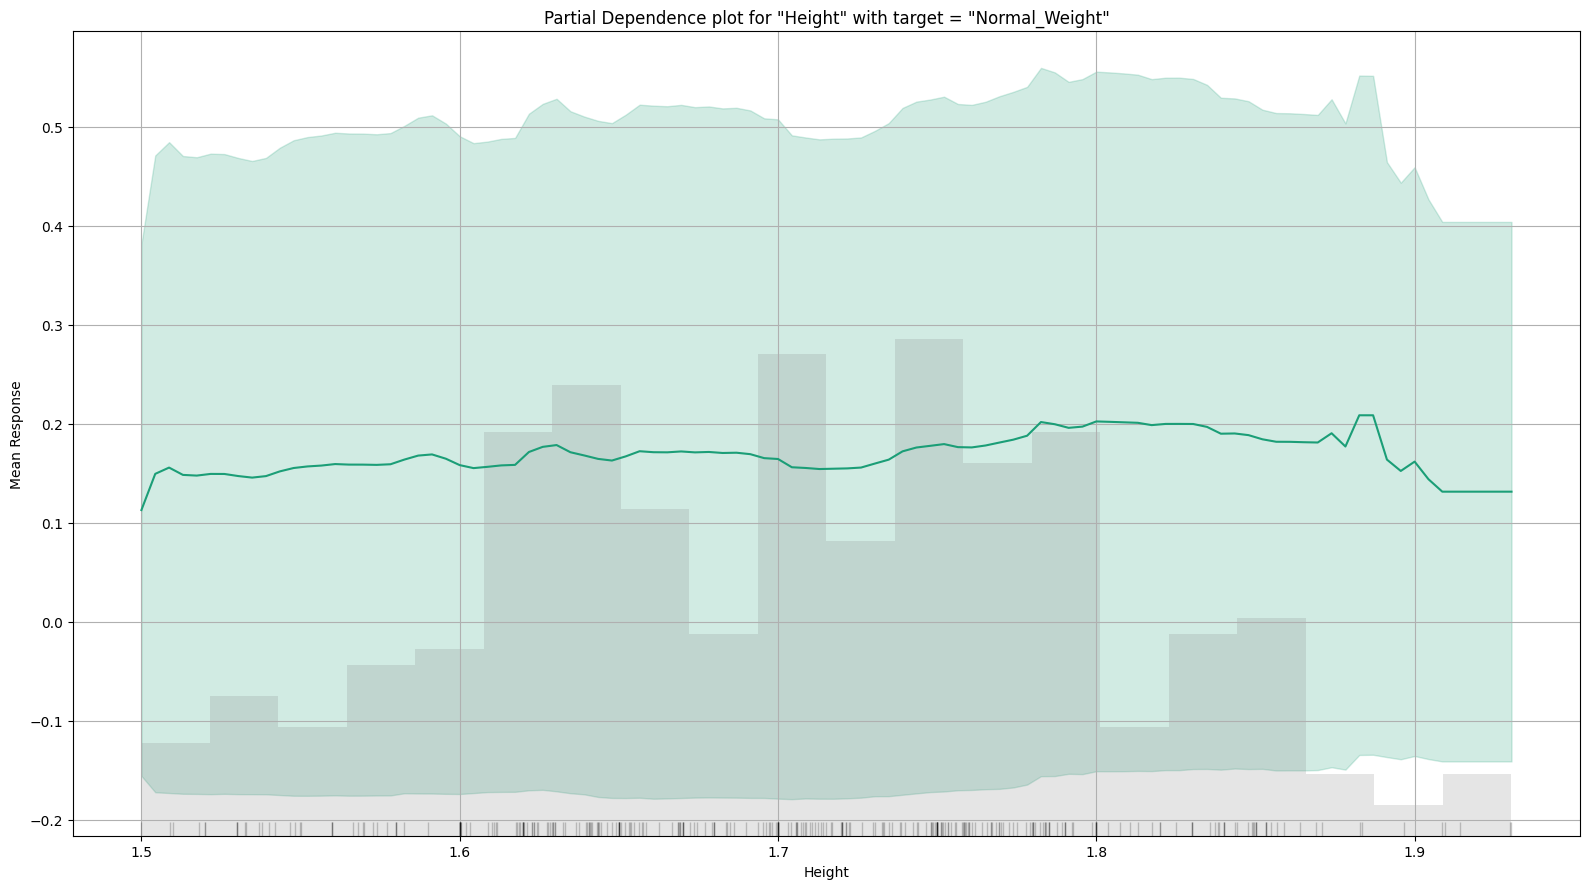

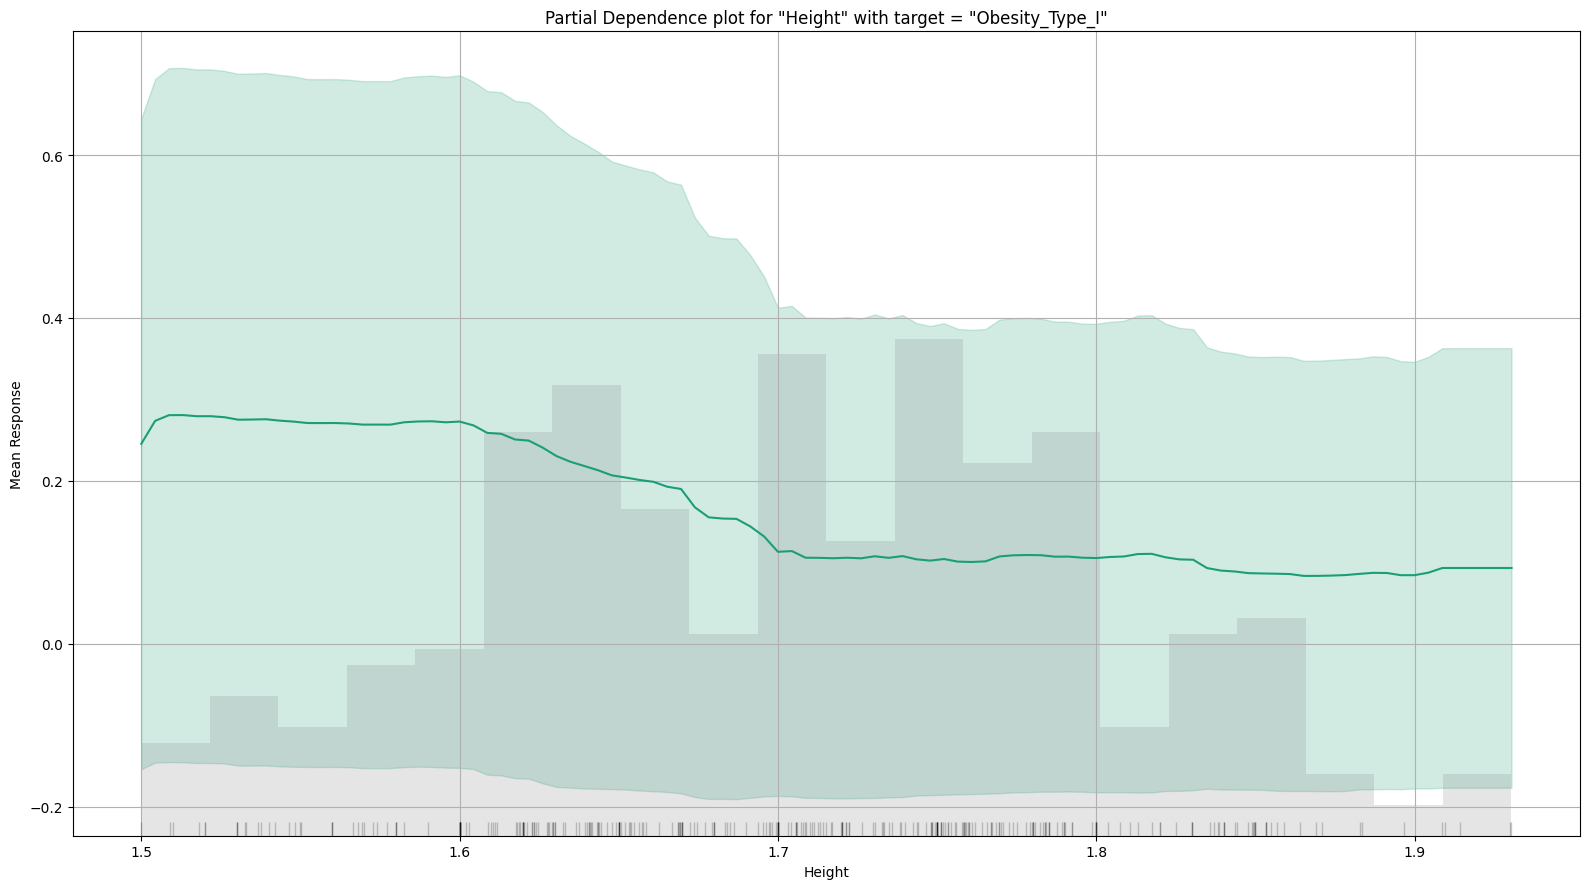

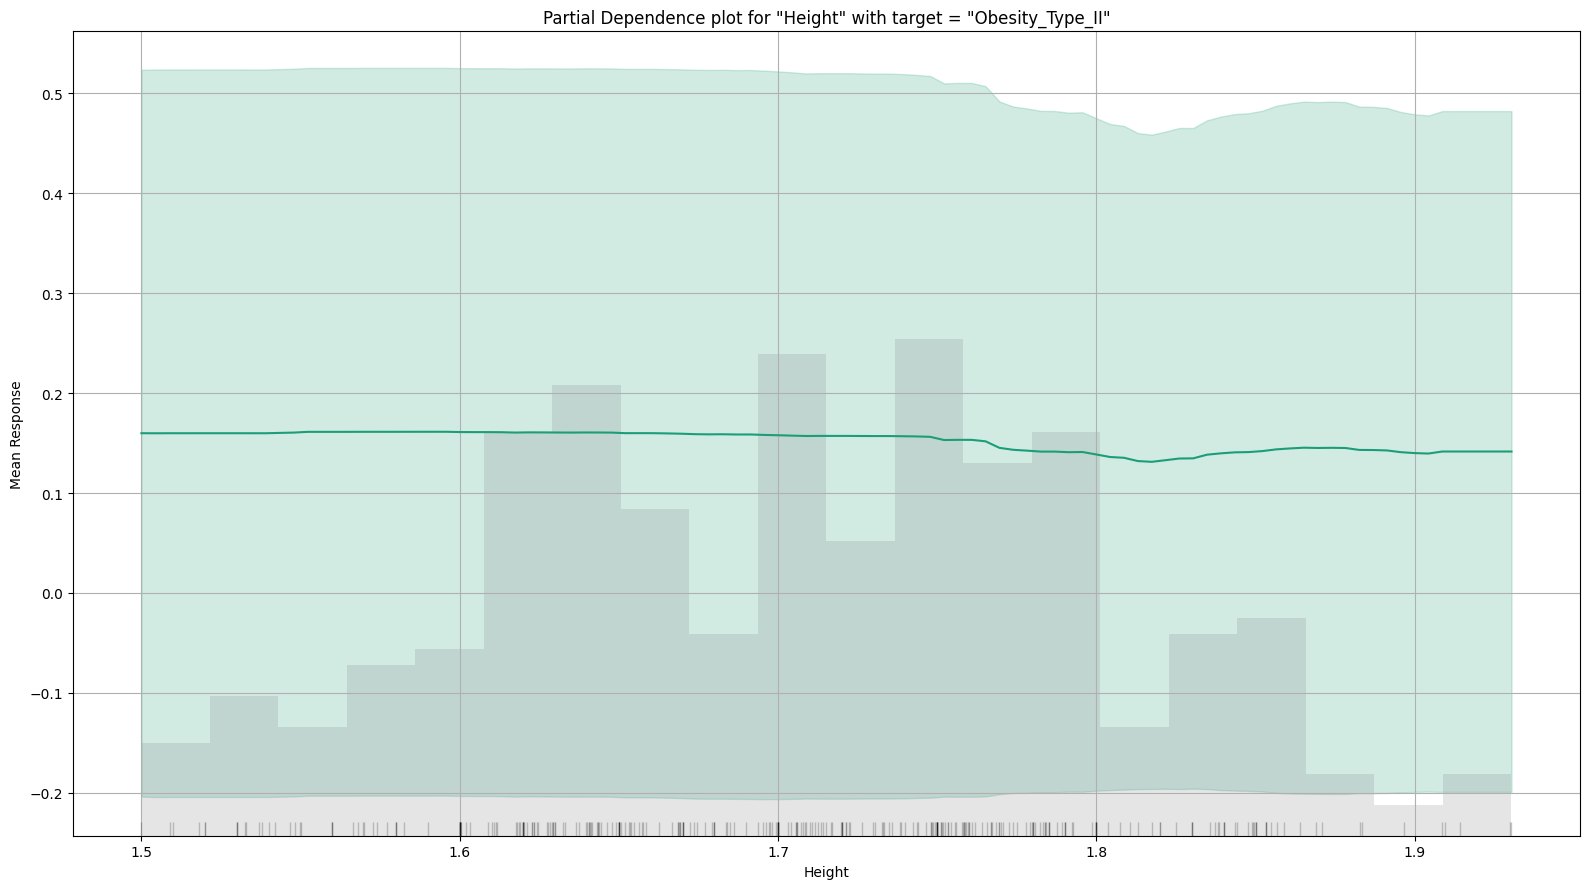

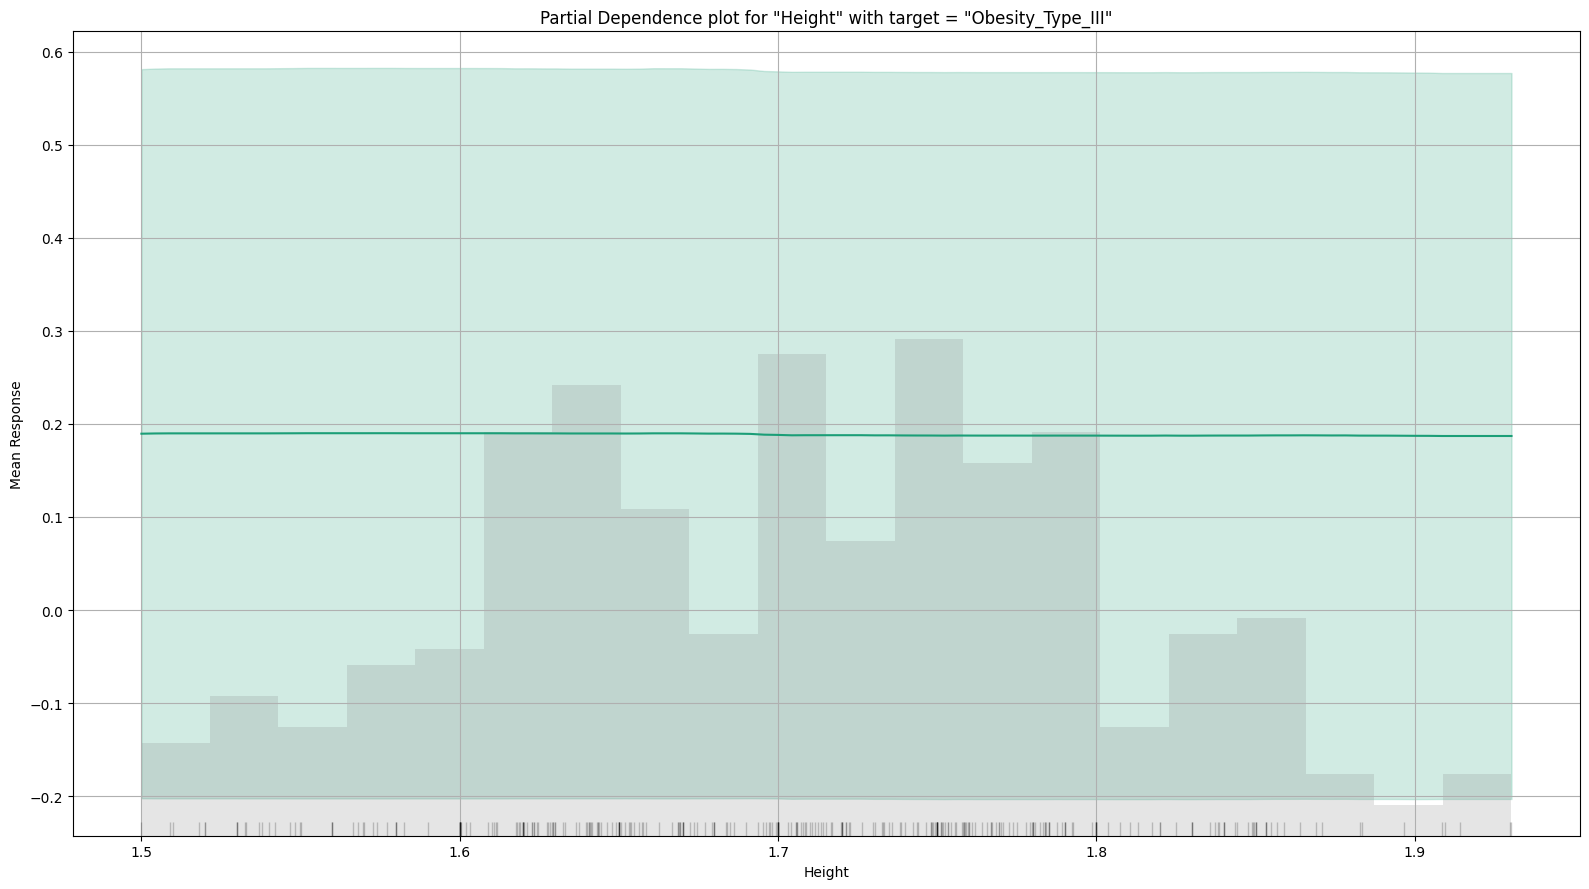

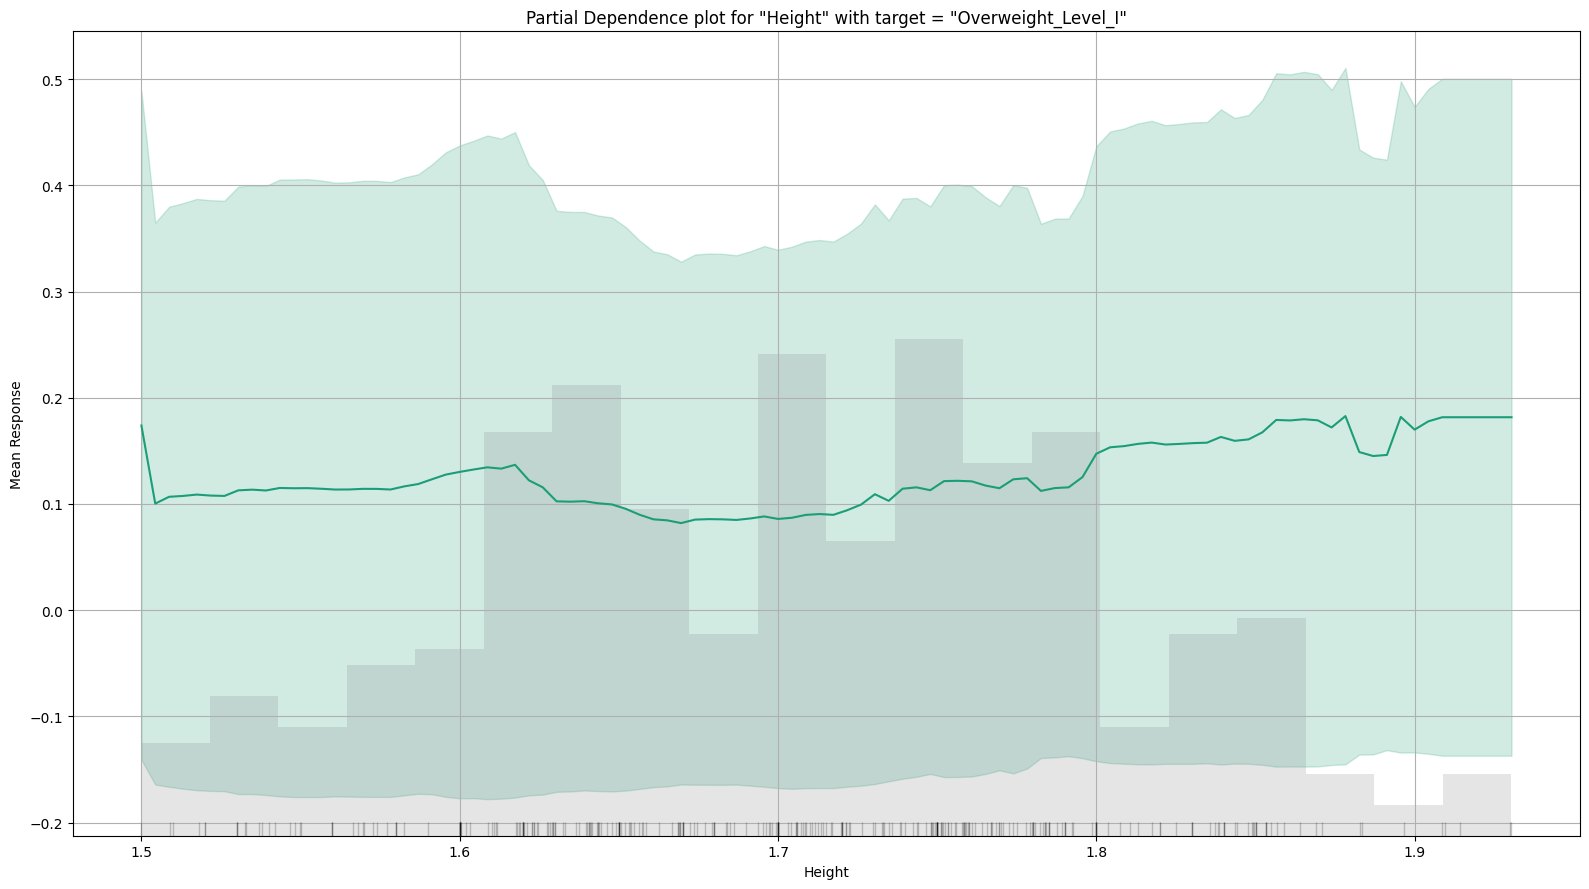

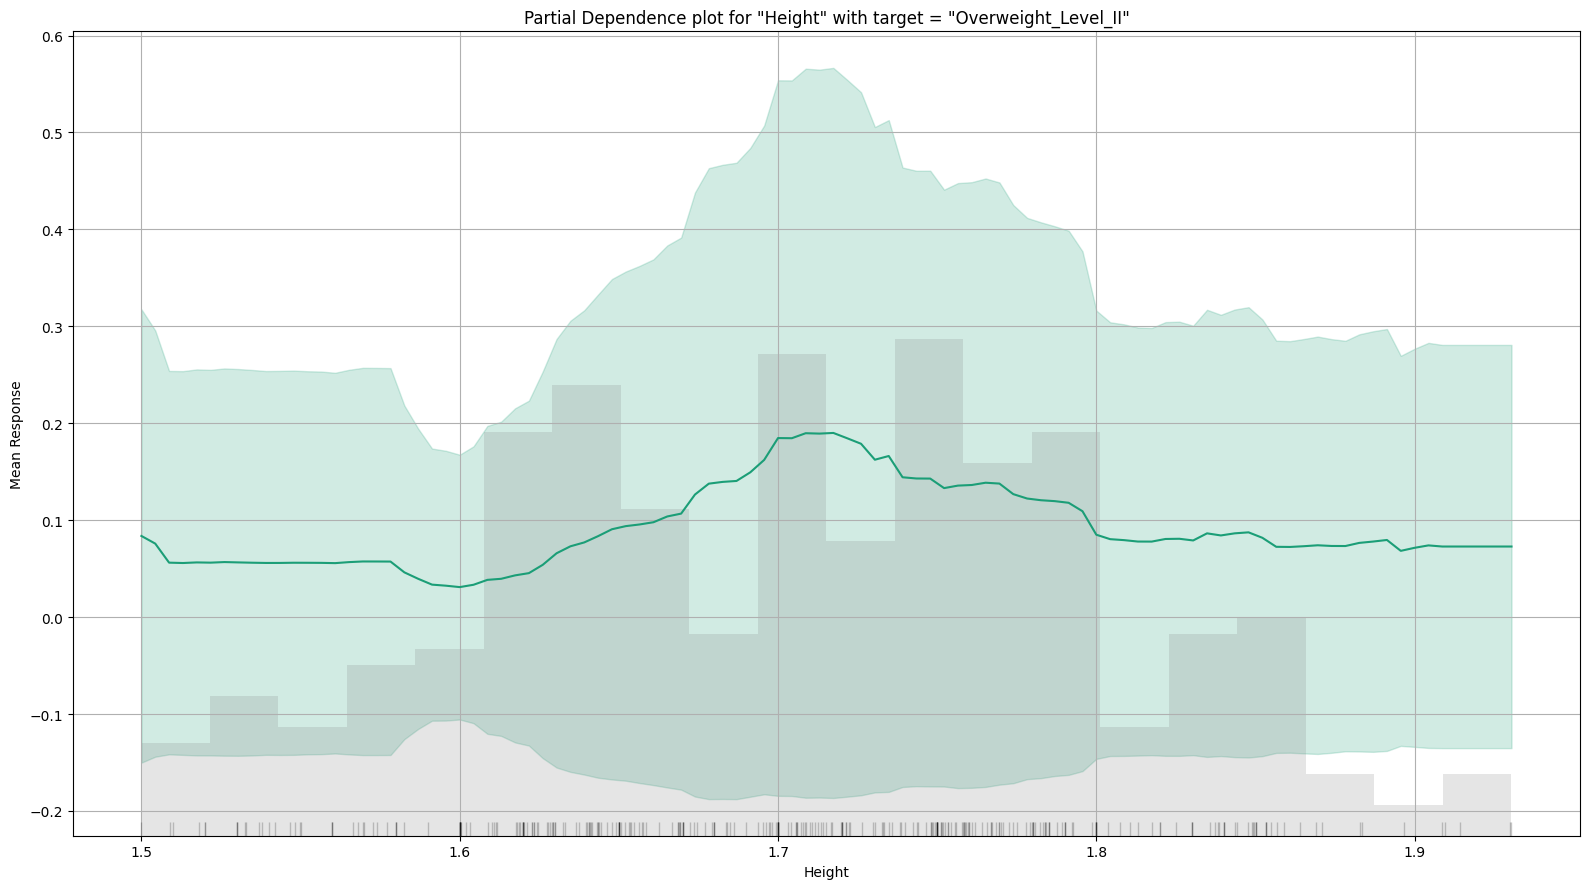

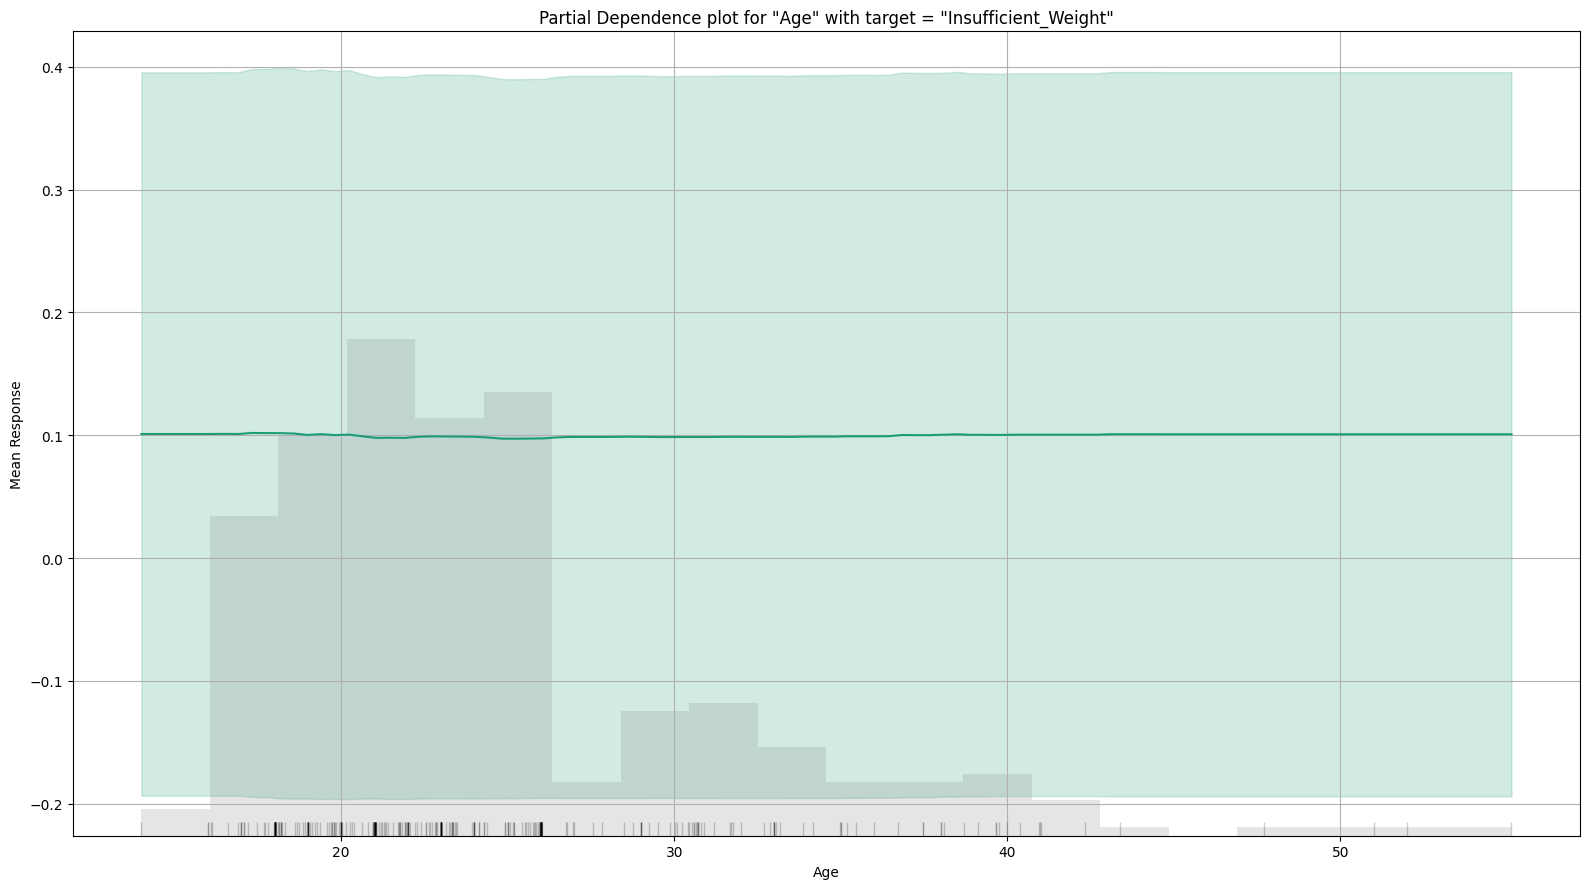

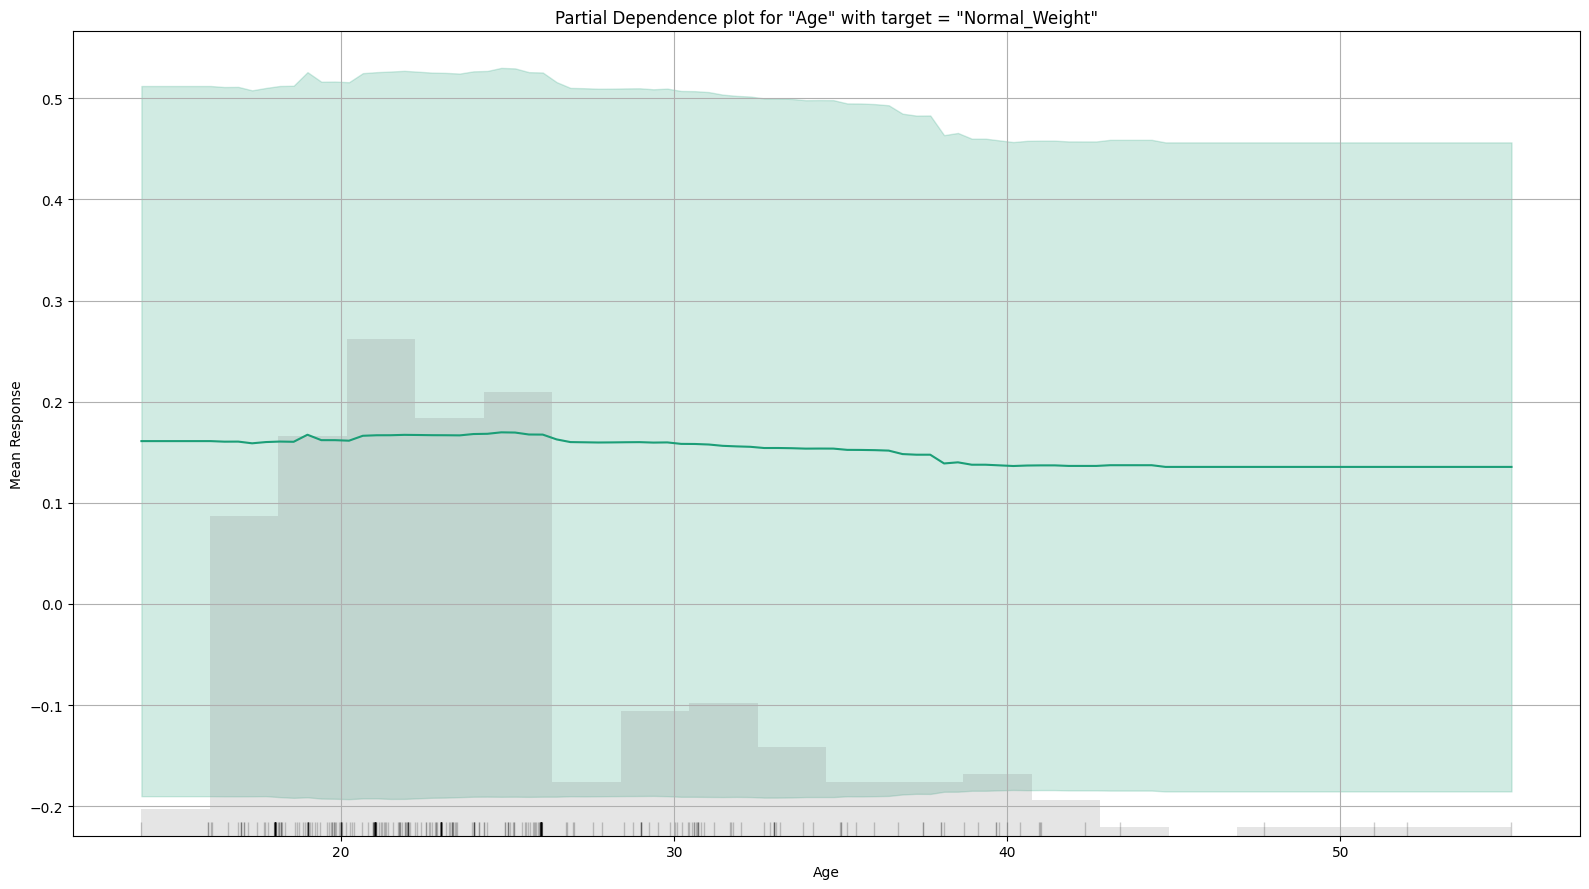

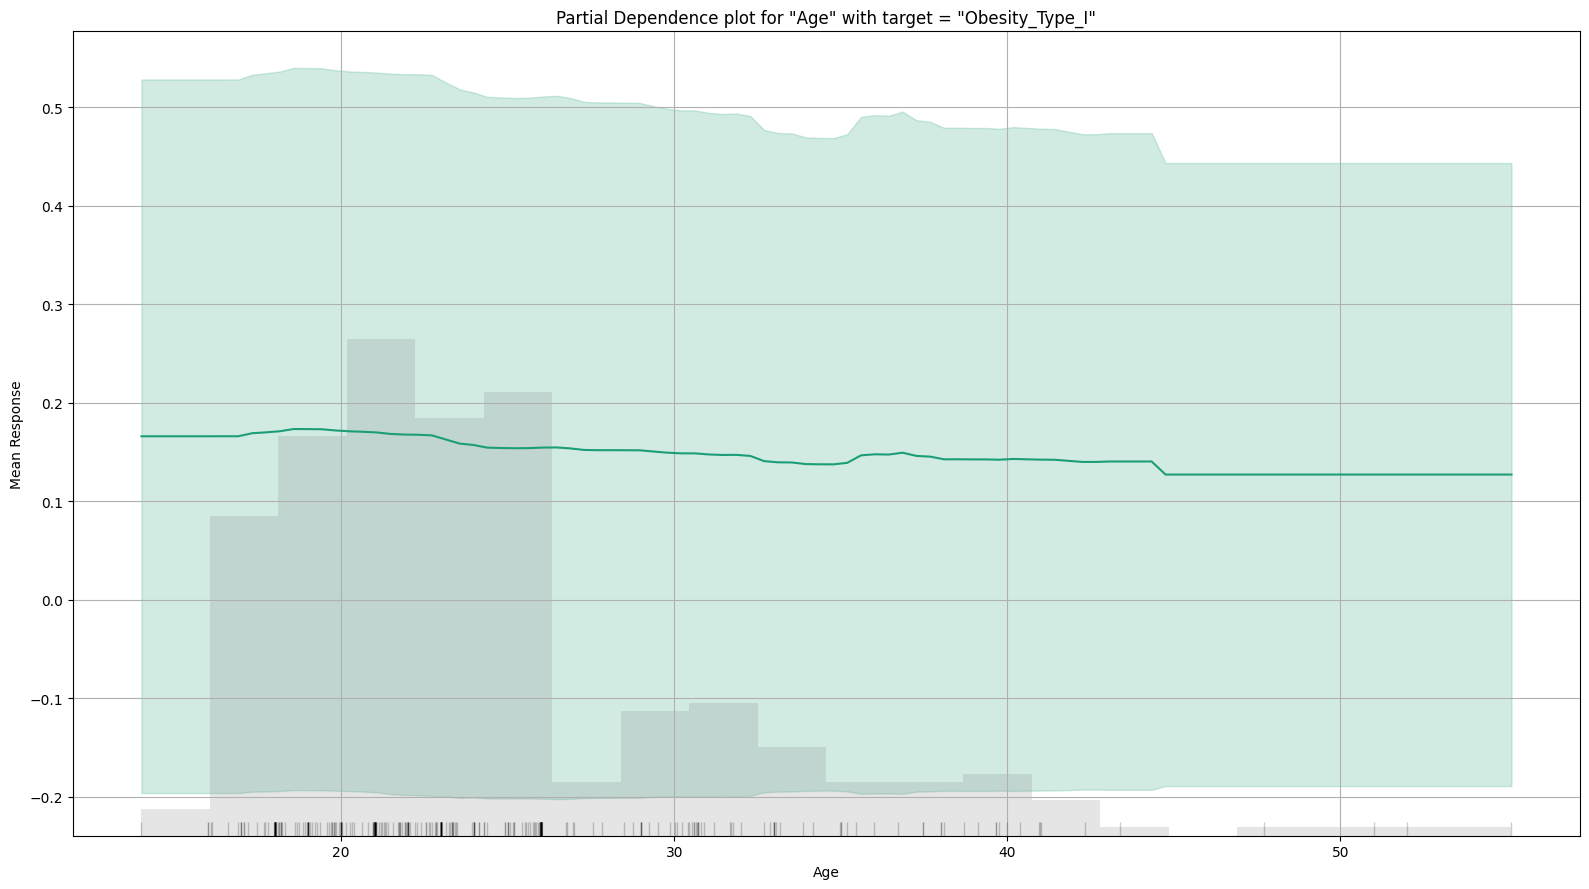

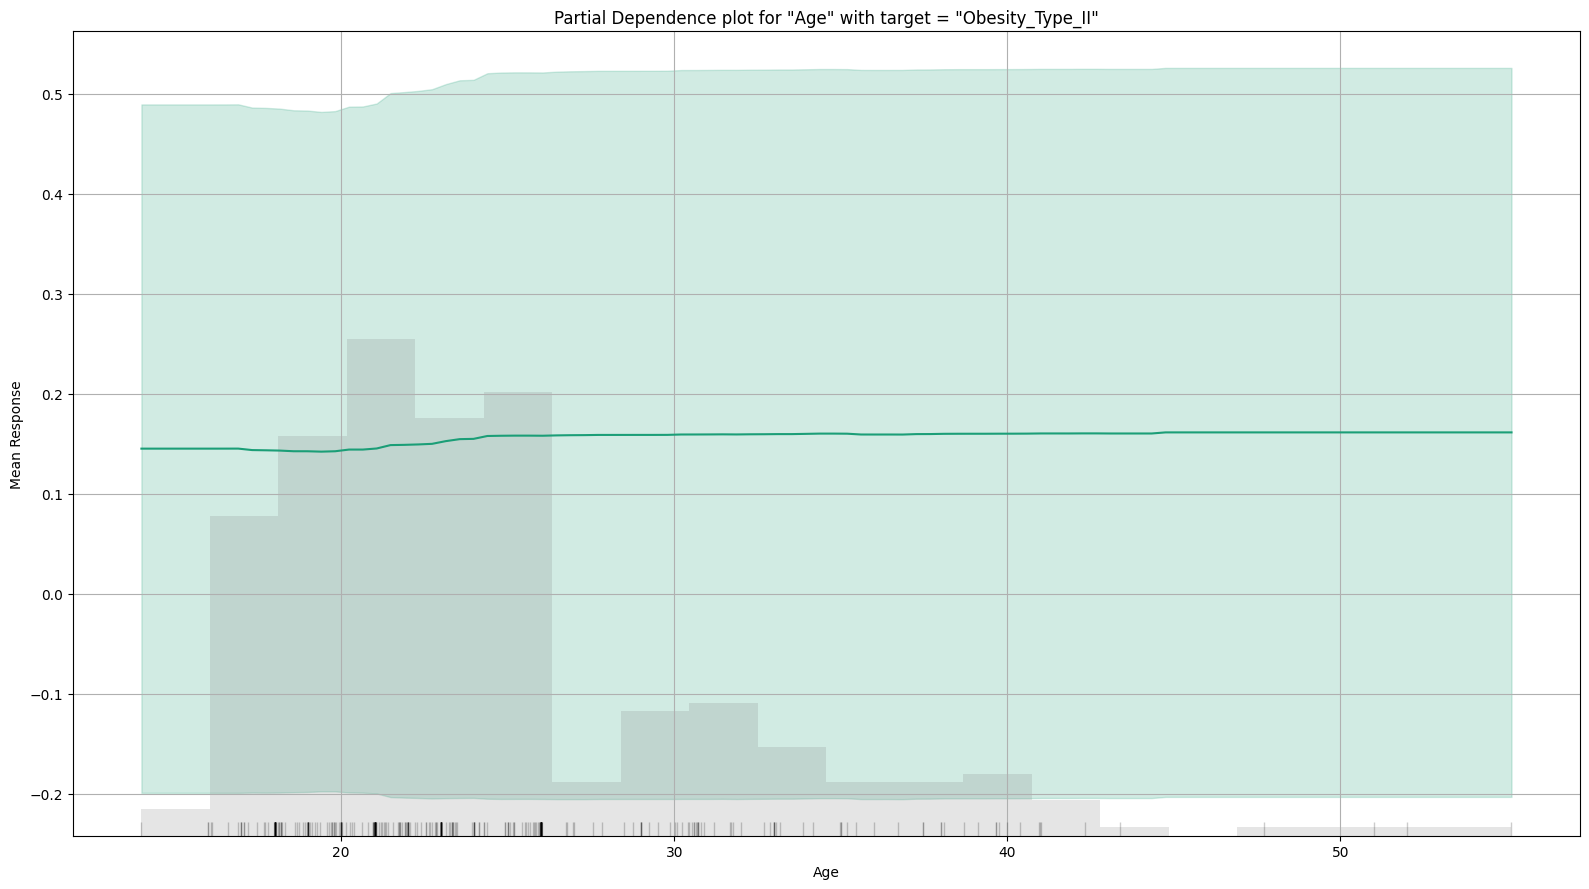

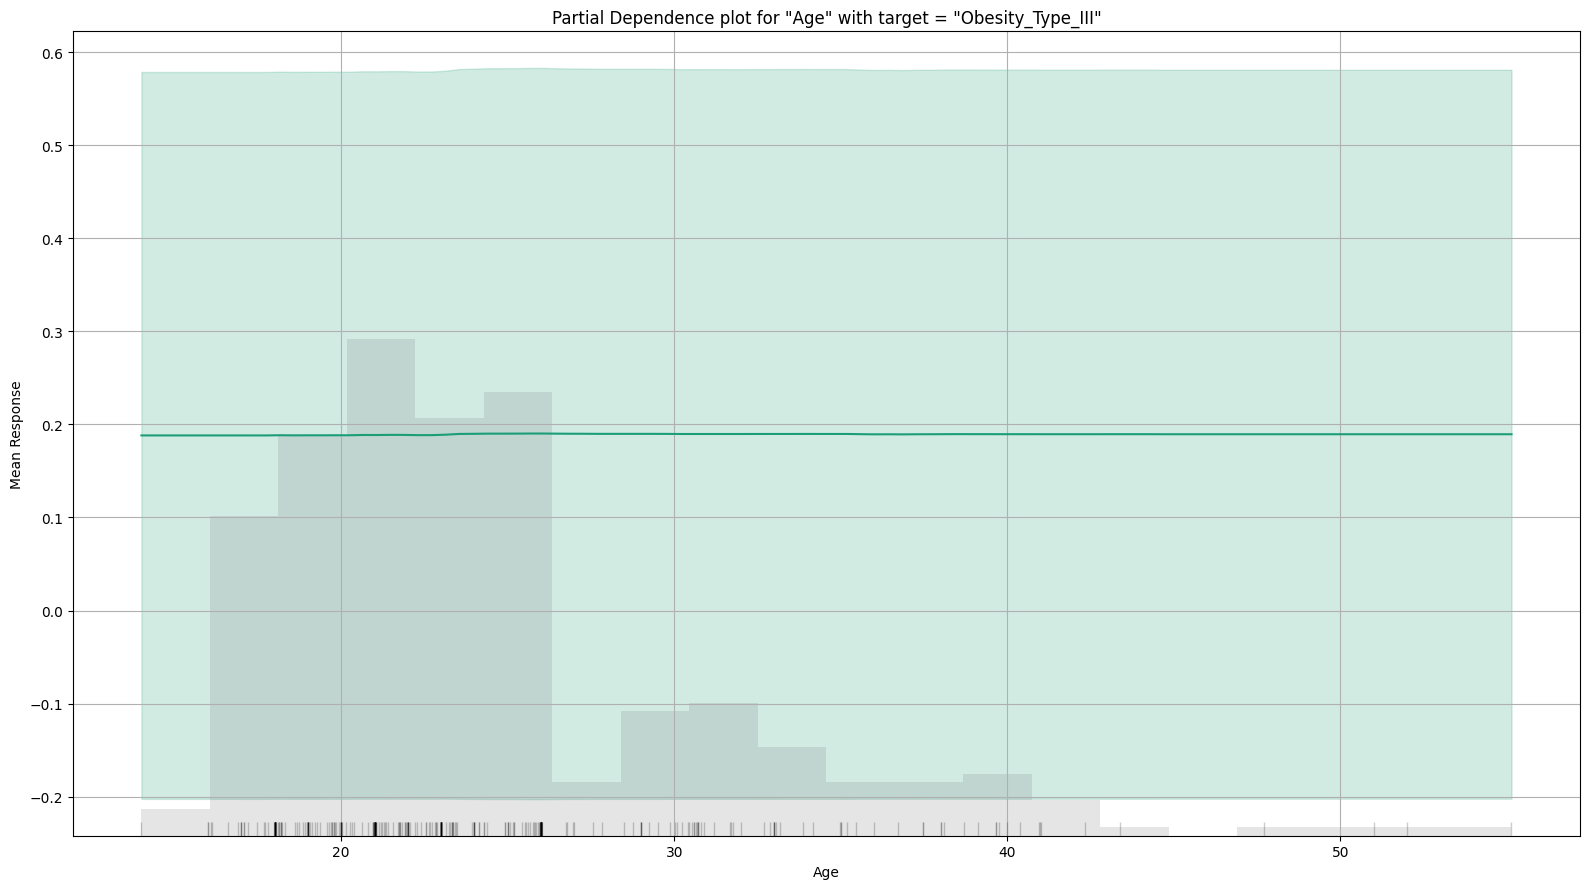

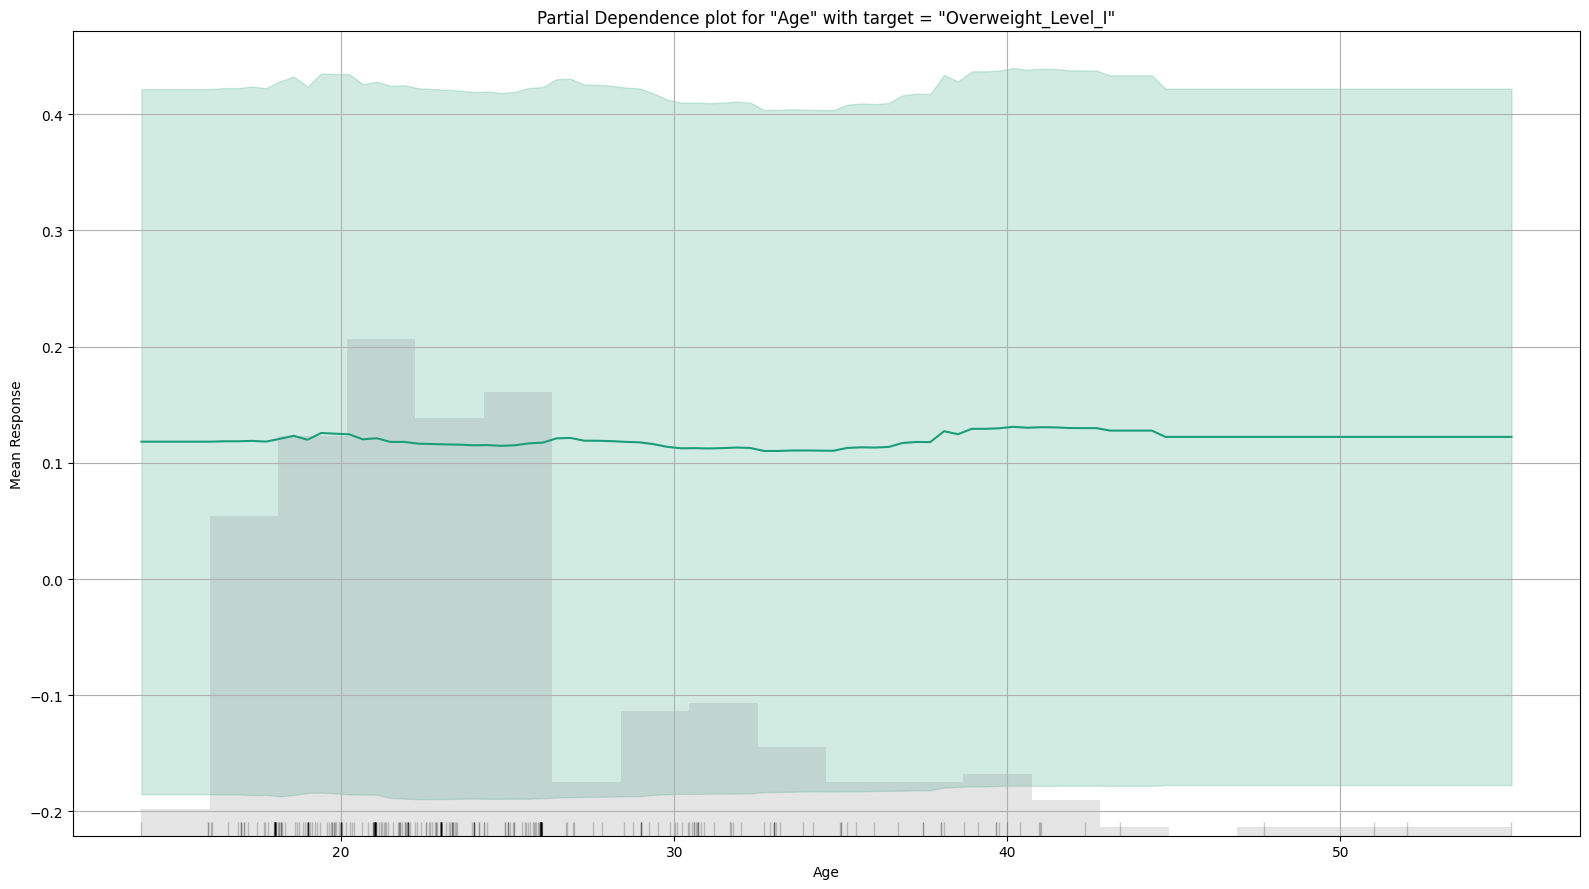

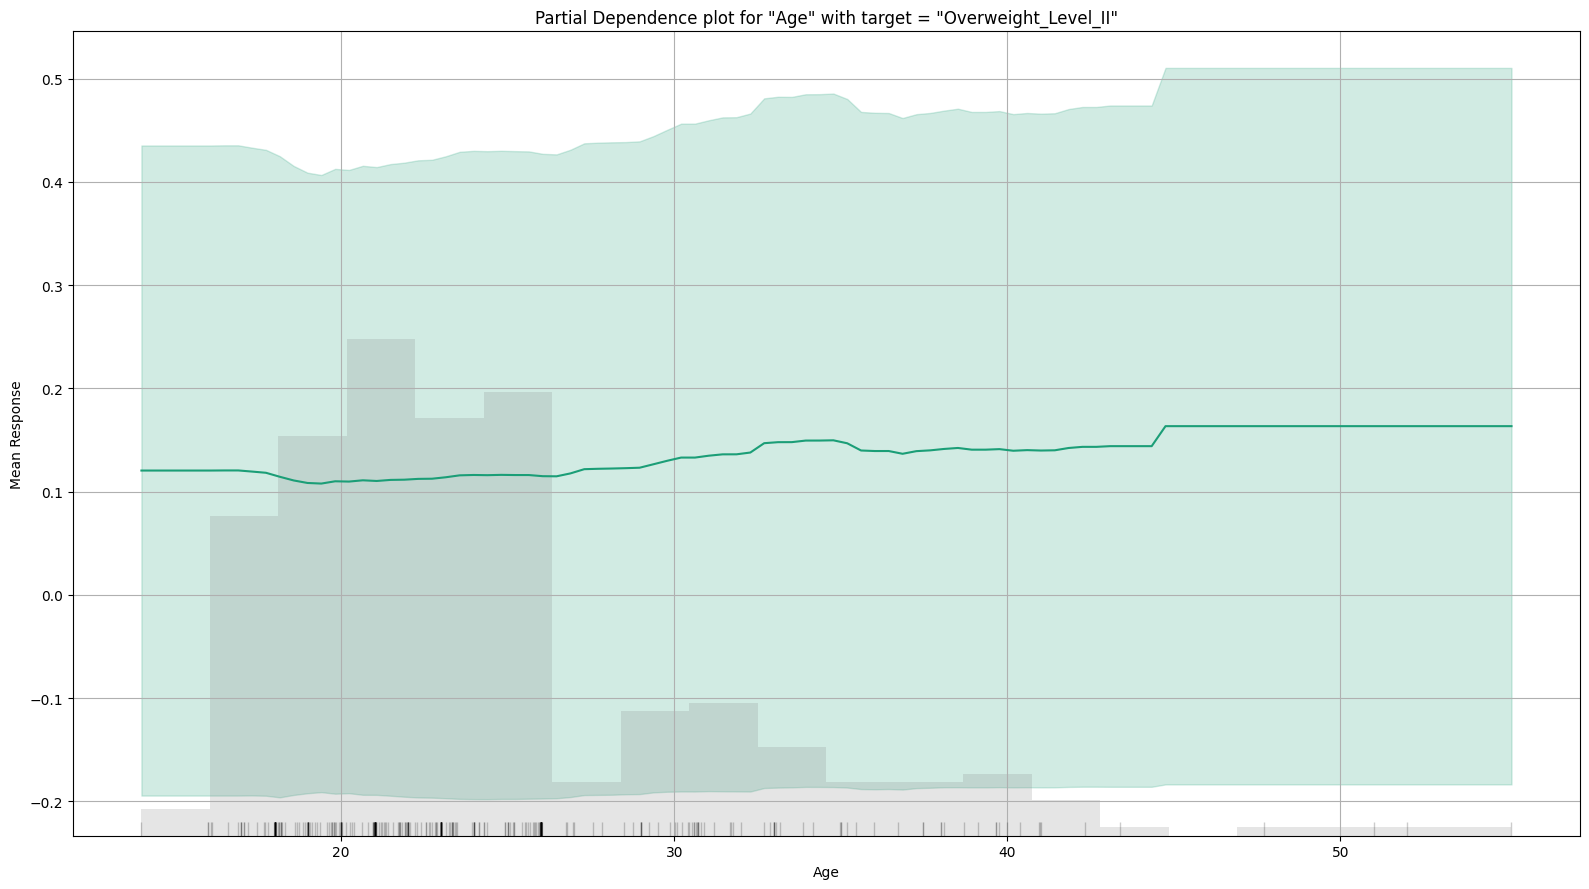

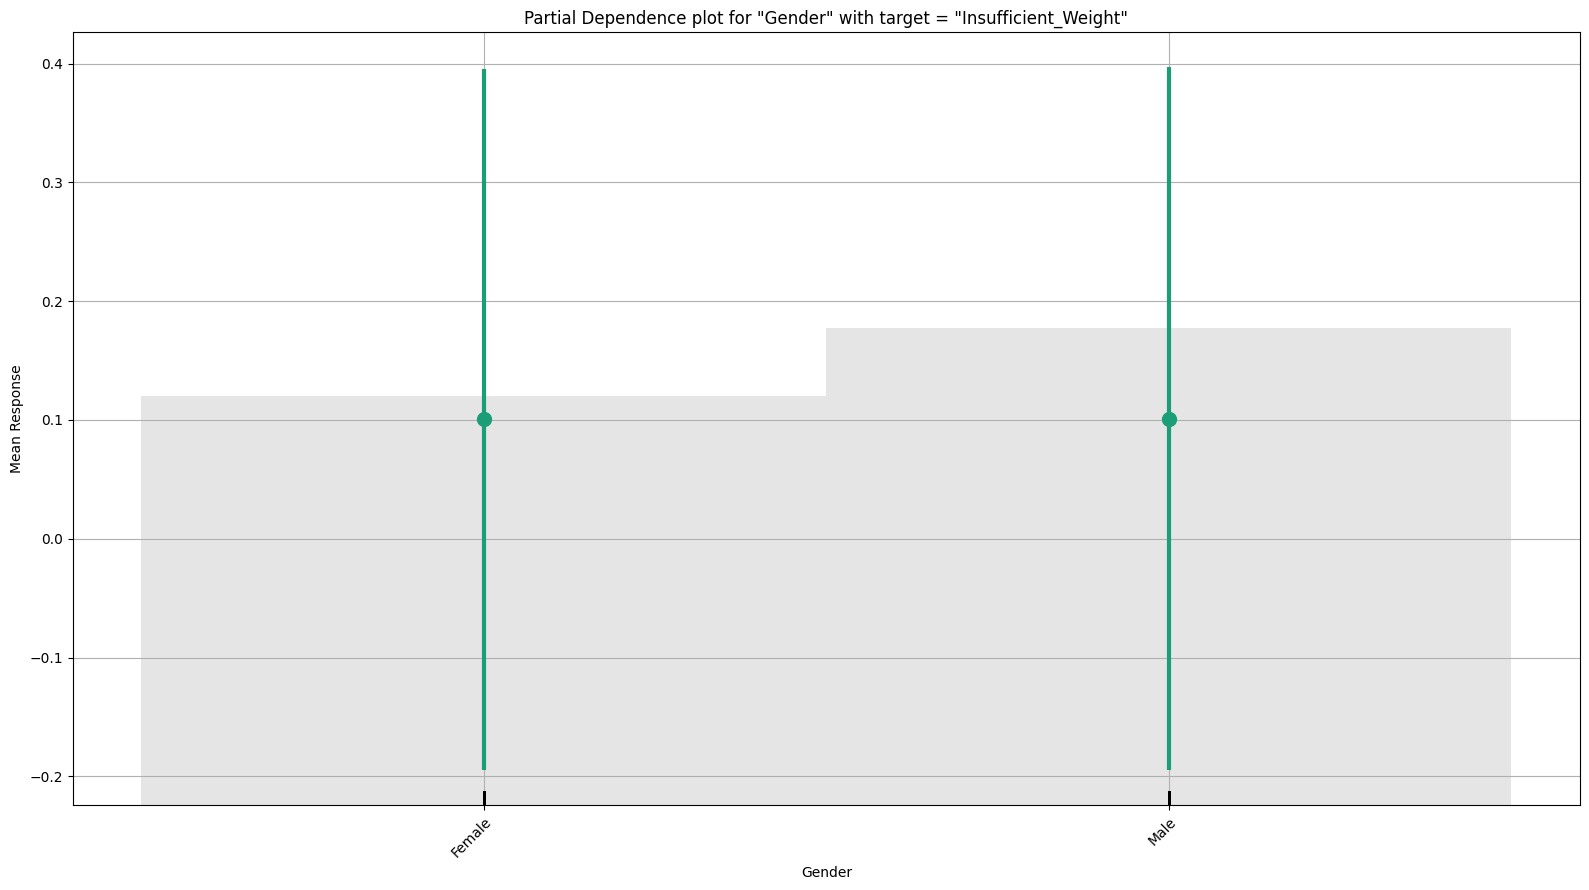

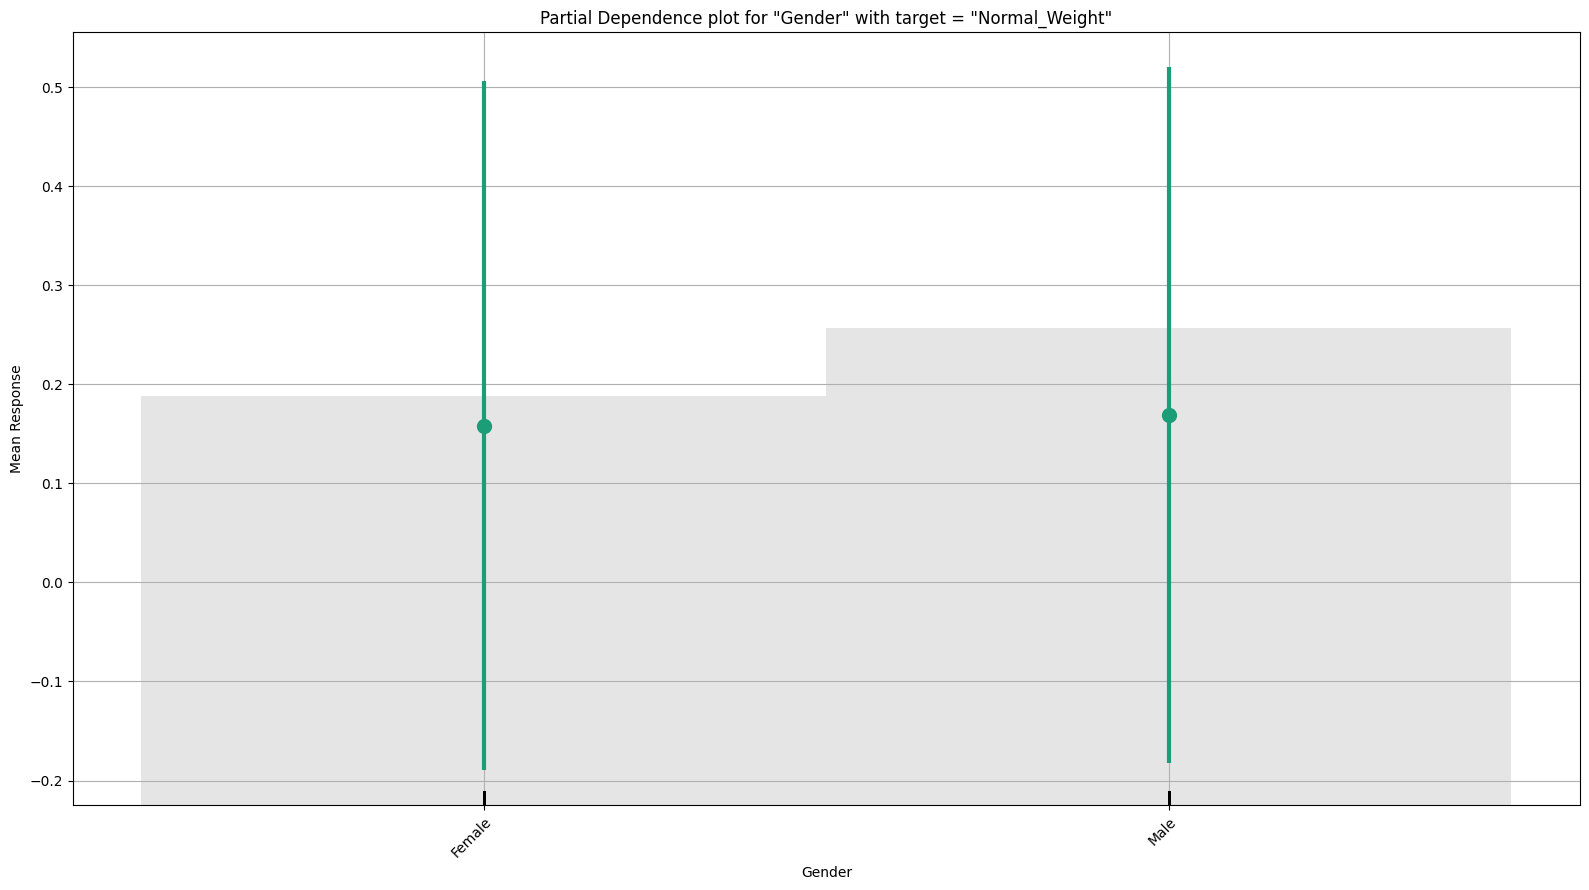

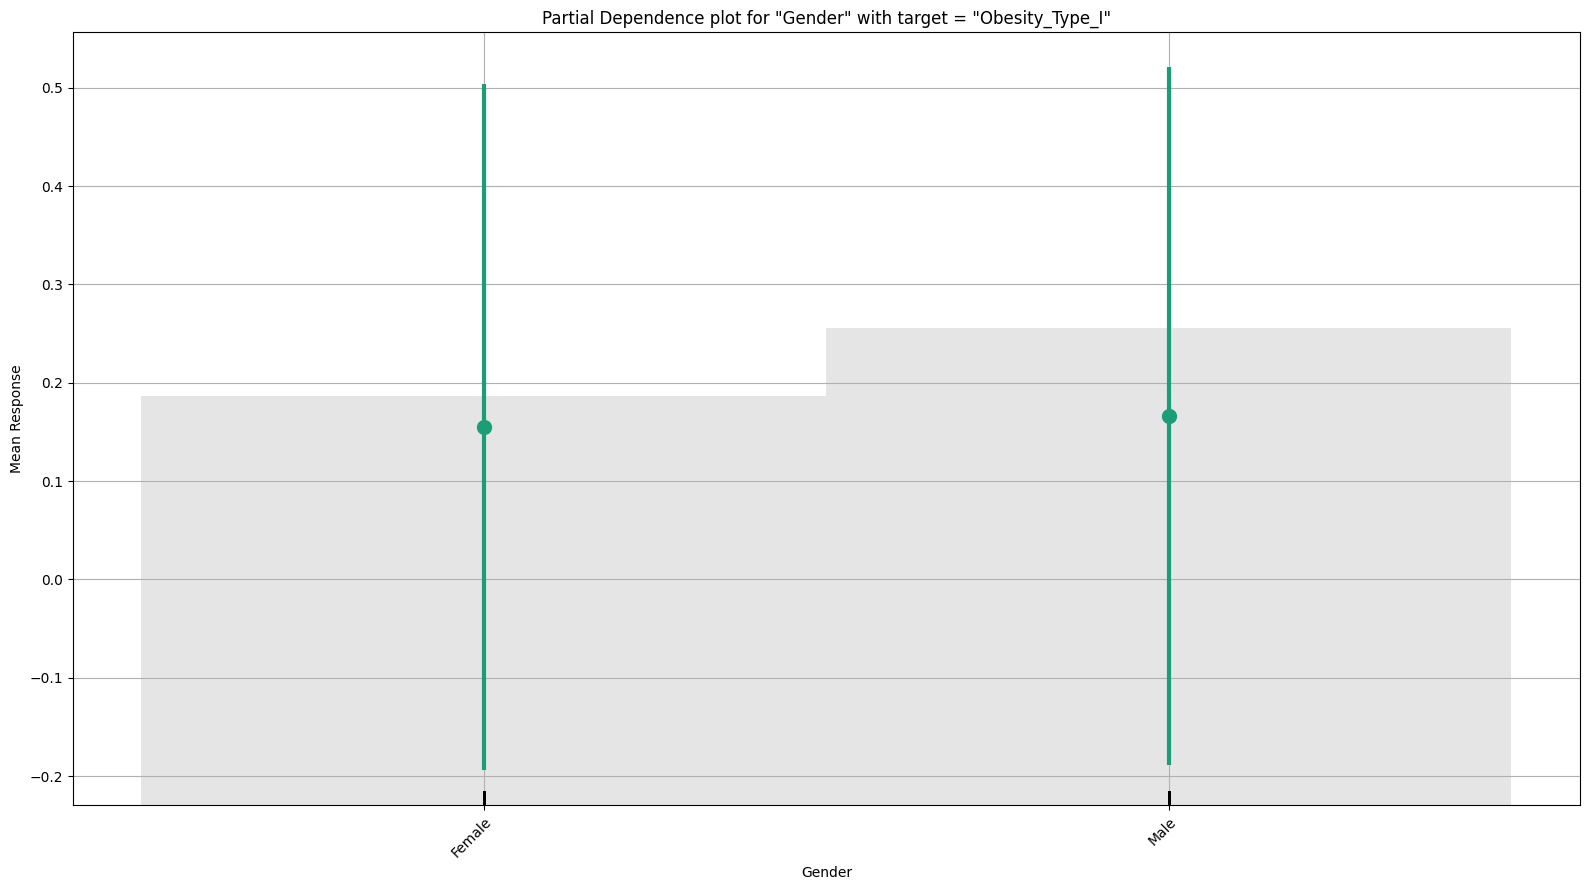

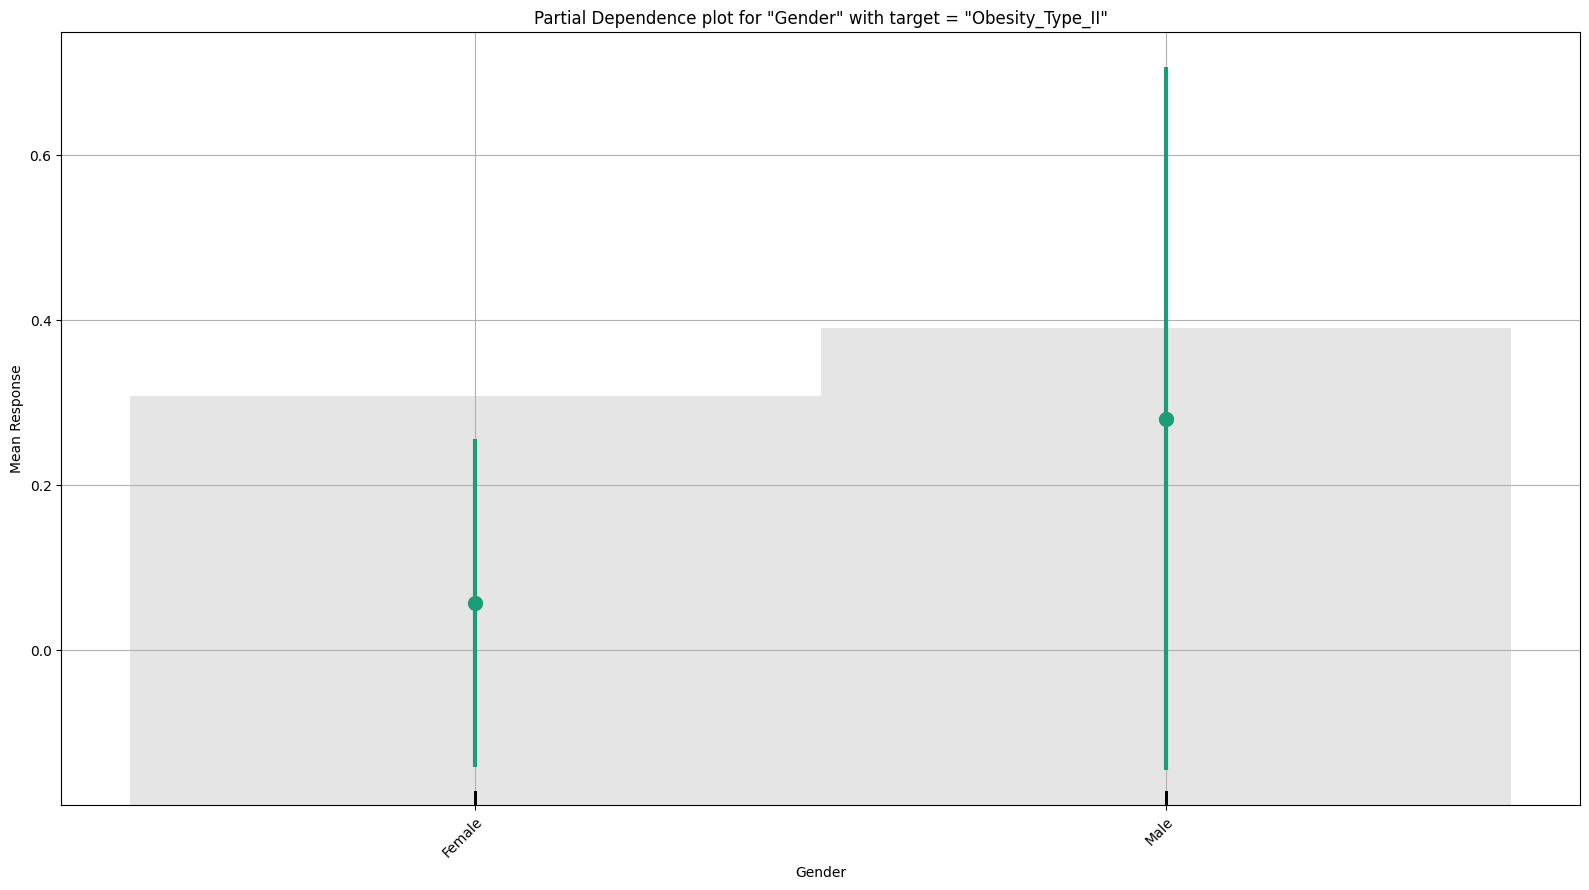

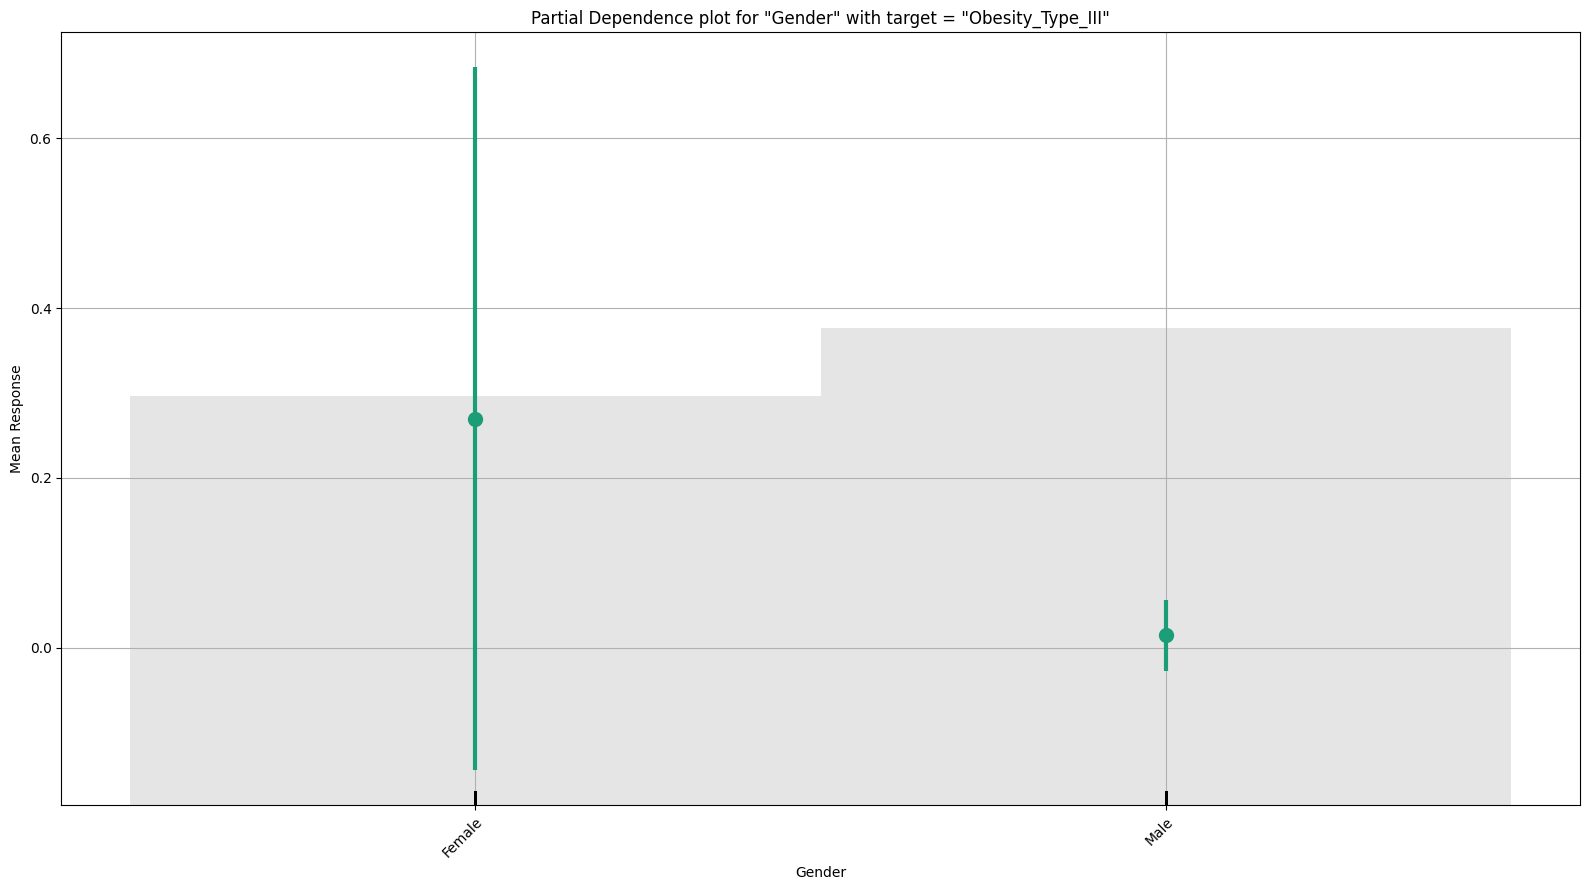

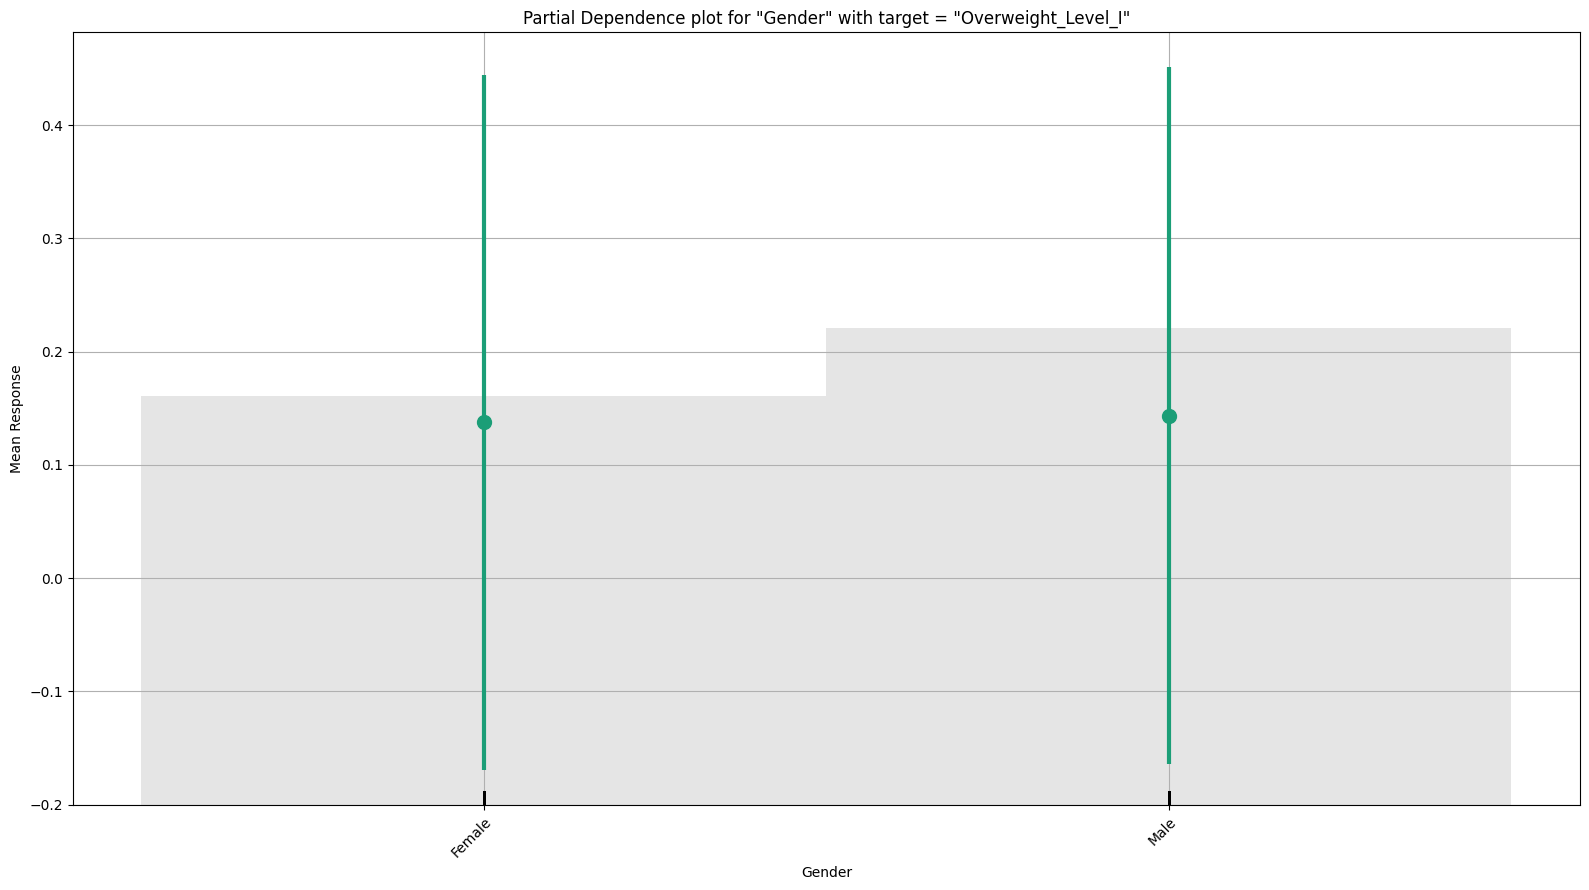

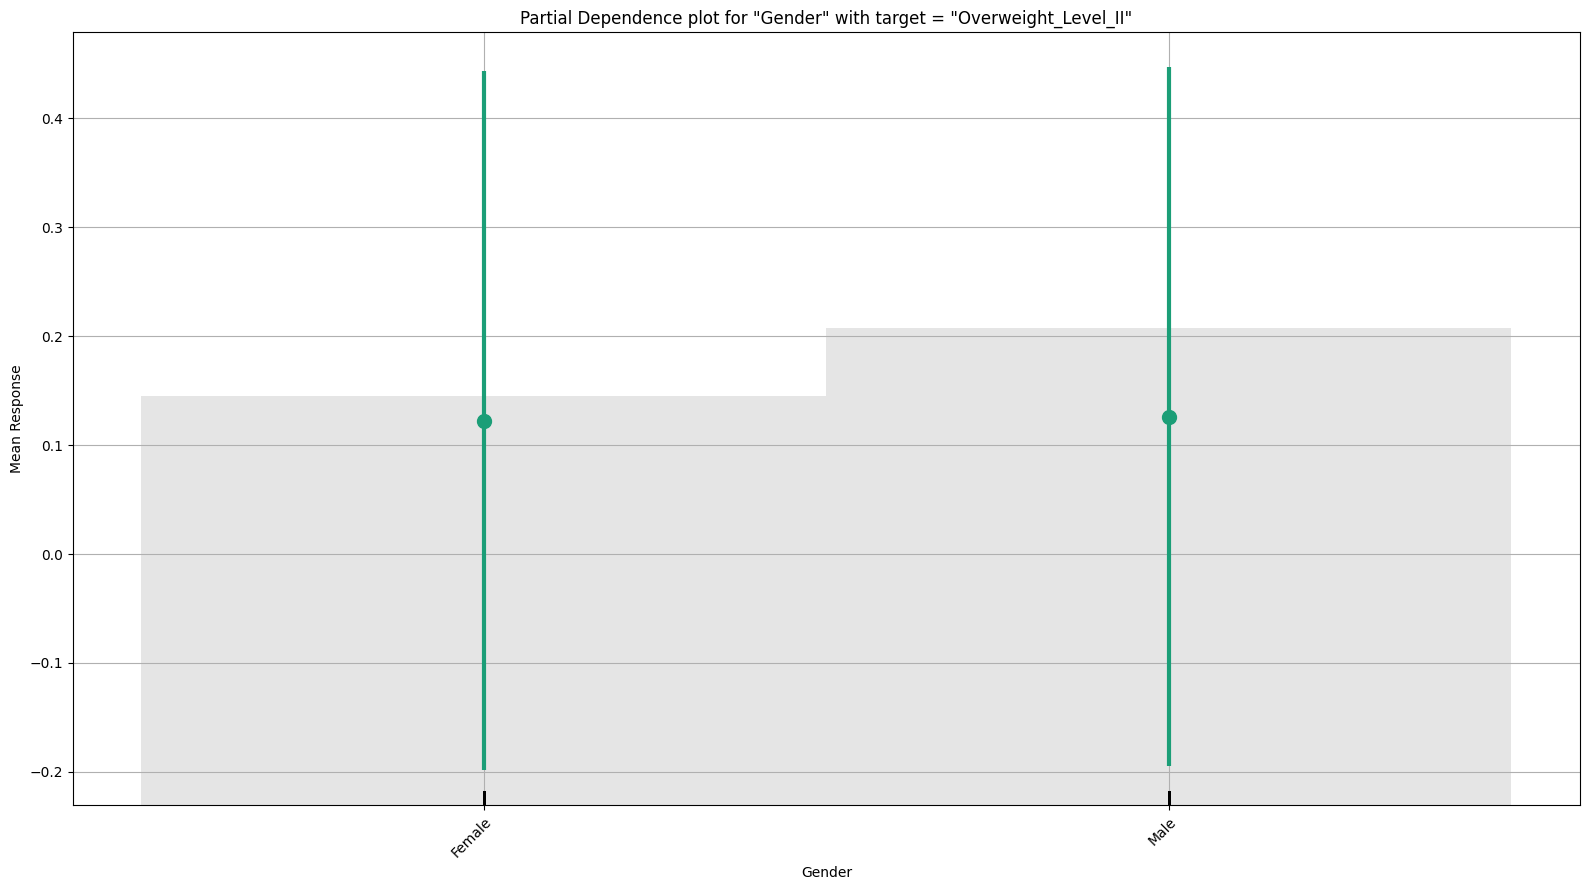

In [ ]:
# Explain a single H2O model (e.g. leader model from AutoML)
exm = aml.leader.explain(df_test)

In [3]:
# # Create the SHAP summary plot
# shap_summary_plot <- h2o.shap_summary_plot(gbm, test)
# print(shap_summary_plot)


# References and citations

https://www.kaggle.com/code/juanfearias/exploring-and-modelling-obesity-dataset

https://www.kaggle.com/code/hassaneskikri/the-uci-obesity-dataset-exploration/notebook

